In [15]:
!conda env list
!ls -l ../data/TongJi/palmprint/ROI_RGB

# conda environments:
#
base                  *  /home/r08942088/miniconda3

總用量 348
drwxrwxr-x 2 r08942088 r08942088 167936  4月  1 18:11 session1
drwxrwxr-x 2 r08942088 r08942088 188416 12月 26 15:31 session2


In [651]:
!nvidia-smi

Wed Aug 31 18:38:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P5    42W / 320W |   6967MiB / 10240MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import gc
# torch.cuda.get_arch_list()
# torch.zeros(1).cuda()

inputs = None
rotated_inputs = None
labels = None
feats = None
rotated_feats = None
rotated_centers = None
images = None
param_norm = None
batch_loss = None
margin_output = None
original_logits = None
# optimizer = None
# optimzer4center = None
# optimizer4mapping = None
gallery_feature_loader = None
probe_feature_loader = None
feature_loader = None
label_loader = None
gc.collect()
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0


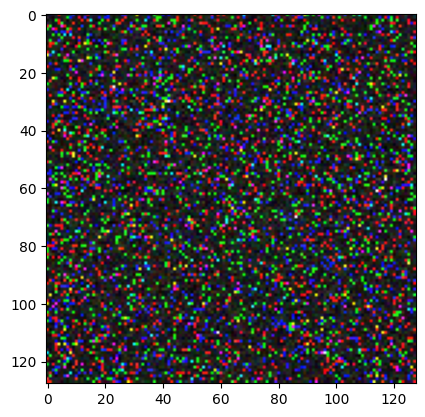

In [114]:
from torchvision.utils import save_image
trainingTransform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize(image_size),
    # baseline
    # transforms.RandomApply([transforms.RandomRotation([-5,5], expand=False)], p=1),
    # transforms.RandomApply([transforms.RandomAffine(0, translate=(0.03, 0.03))], p=1),
    # transforms.RandomApply([transforms.RandomResizedCrop(size=image_size, scale=(1.07, 1.14))], p=1),
    # transforms.RandomResizedCrop(size=image_size, ratio=(1.07, 1.14)),
    # transforms.RandomApply([transforms.ColorJitter(brightness=0.5)], p=1),
    # transforms.RandomApply([transforms.ColorJitter(contrast=0.5)], p=1),
    # transforms.RandomApply([transforms.ColorJitter(hue=0.25)], p=1),
    # transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(1), transforms.GaussianBlur(3), transforms.GaussianBlur(5)])], p=0.6),
    # transforms.RandomAdjustSharpness(1.5, p=0.6),
    transforms.ToPILImage(),
])
optunaTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=(0,2)),
    transforms.ColorJitter(contrast=(0,3)),
    transforms.ColorJitter(saturation=(0,4)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, 10)), transforms.GaussianBlur(5, sigma=(0.1, 10))]),
    AddGaussianNoise(0 , 1,(0,20)),
    # transforms.RandomRotation([0,10], expand=False),
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),
    # transforms.Resize(image_size),
    # transforms.ToTensor(),
])

fnames = ['../data/PolyU/Multispectral_R/127/1_02_s.bmp',
  '../data/PolyU/Multispectral_G/127/1_02_s.bmp',
  '../data/PolyU/Multispectral_B/127/1_02_s.bmp']
imgs = []
for i in fnames:
    imgs.append(Image.open(i))
img = np.dstack(imgs)

# img = trainingTransform(img)
img = optunaTransform(img)

# img.save("images/aug-optuna-shift.jpg")
plt.imshow(img)
plt.show()
plt.close()


In [1]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
import cv2
import math
import torch.nn.functional as F
from torch.autograd import Variable
import random
plt.style.use("default")

class CLAHE(object):
    def __call__(self, img):
        
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L,A,B = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        L = clahe.apply(L)
        lab = cv2.merge([L,A,B])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)
    def __repr__(self):
        return self.__class__.__name__+'()'

class BGR2LAB(object):
    def __call__(self, img):
        lab = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2Lab)
        return Image.fromarray(lab)
    def __repr__(self):
        return self.__class__.__name__+'()'

class RGB2YCrCb(object):
    def __call__(self, img):
        YCrCb = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2YCrCb)
        return Image.fromarray(YCrCb)
    def __repr__(self):
        return self.__class__.__name__+'()'

class RGB2HLS(object):
    def __call__(self, img):
        HLS = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2HLS_FULL)
        return Image.fromarray(HLS)
    def __repr__(self):
        return self.__class__.__name__+'()'

class RGB2HSV(object):
    def __call__(self, img):
        HSV = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2HSV_FULL)
        return Image.fromarray(HSV)
    def __repr__(self):
        return self.__class__.__name__+'()'

class RGBmHSV(object):
    def __call__(self, img):
        HSV = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2HSV_FULL)
        H,S,V = cv2.split(HSV)
        R,G,B = cv2.split(np.asarray(img))
        img = cv2.merge([R,G,B,H,S,V])
        return img
    def __repr__(self):
        return self.__class__.__name__+'()'
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., amplitude=(0,25)):
        self.std = std
        self.mean = mean
        self.amplitude = amplitude
        
    def __call__(self, img):
        img_arr = np.asarray(img)
        gauss = np.random.normal(self.mean,self.std,img_arr.shape) * random.randint(*self.amplitude)
        img = img_arr + gauss
        img[img>255] = 255
        return Image.fromarray(img.astype("uint8")).convert("RGB")
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

batch_size_train = 32
batch_size_test = 32
image_size = 224
# trainingTransform = transforms.Compose([
#     transforms.ToPILImage(),
#     # CLAHE(),
#     # transforms.RandomAdjustSharpness(1.5, p=0.6),
#     transforms.RandomApply([transforms.ColorJitter(brightness=1.1, contrast=1.1, saturation=1.1)], p=0.8),
#     # transforms.RandomApply([transforms.ColorJitter(hue=0.5)], p=0.6),
#     # transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, 5)), 
#     #                                                  transforms.GaussianBlur(5, sigma=(0.1, 5))])], p=0.6),
#     # transforms.RandomApply([transforms.GaussianBlur(5, sigma=(0.1, 5))], p=0.6),
#     # transforms.RandomApply([AddGaussianNoise(0 , 1,(0,1))], p=0.6),
#     # transforms.RandomApply([transforms.RandomRotation([-3,3], expand=False)], p=0.6),
#     # transforms.RandomApply([transforms.RandomAffine(0, translate=(0.03, 0.03))], p=0.6),
#     transforms.Resize(image_size),
#     # transforms.FiveCrop(112),
#     # transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#     transforms.ToTensor(),
# ])
# testingTransform = transforms.Compose([
#     transforms.ToPILImage(),
#     # BGR2LAB(),
#     # RGB2YCrCb(),
#     # RGB2HLS(),
#     # RGB2HSV(),
#     # RGBmHSV(),
#     transforms.Resize(image_size),
#     # transforms.FiveCrop(112),
#     # transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#     transforms.ToTensor(),
# ])
# trainingTransform = transforms.Compose([augmentationTransform, unifiedTransform])
# testingTransform = transforms.Compose([unifiedTransform])

# baseline augmentation
# trainingTransform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.5)], p=0.6),
#     transforms.RandomApply([transforms.ColorJitter(contrast=0.5)], p=0.6),
#     # transforms.RandomApply([transforms.ColorJitter(saturation=0.25)], p=0.6),
#     transforms.RandomApply([transforms.ColorJitter(hue=0.25)], p=0.6),
#     transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(1), transforms.GaussianBlur(3), transforms.GaussianBlur(5)])], p=0.6),
#     transforms.RandomAdjustSharpness(1.5, p=0.6),
#     transforms.RandomApply([transforms.RandomResizedCrop(size=image_size, scale=(1.07, 1.14))], p=0.6),
#     transforms.RandomApply([transforms.RandomRotation([-5,5], expand=False)], p=0.6),
#     # transforms.RandomApply([transforms.RandomAffine([-5,5], translate=(0.01, 0.01))], p=0.6),
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
# ])
# testingTransform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize(image_size)
# ])


    
# Define space search for training settings
from operator import itemgetter
(brightness,
brightness_p,
contrast,
contrast_p,
# saturation,
# saturation_p,
hue,
hue_p,
# blur_sigma,
# blur_p,
noise_amp,
noise_p,
# rotation_degree,
# rotation_p,
# translatation,
# translatation_p
) = itemgetter(
    'brightness',
    'brightness_probability',
    'contrast',
    'contrast_probability',
    # 'saturation',
    # 'saturation_probability',
    'hue',
    'hue_probability',
    # 'blur_sigma',
    # 'blur_probability',
    'noise_amplitude',
    'noise_probability',
    # 'rotation_degree',
    # 'rotation_probability',
    # 'translatation',
    # 'translatation_probability',
)(torch.load("optuna/best_params-reorder-first-50.pt"))

trainingTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.ColorJitter(brightness=brightness)], p=brightness_p),
    transforms.RandomApply([transforms.ColorJitter(contrast=contrast)], p=contrast_p),
    # transforms.RandomApply([transforms.ColorJitter(saturation=saturation)], p=saturation_p),
    transforms.RandomApply([transforms.ColorJitter(hue=hue)], p=hue_p),
    # transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, blur_sigma)), 
    #                                                  transforms.GaussianBlur(5, sigma=(0.1, blur_sigma))])], p=blur_p),
    transforms.RandomApply([AddGaussianNoise(0 , 1, (0, noise_amp))], p=noise_p),
    # transforms.RandomApply([transforms.RandomAffine(degrees=rotation_degree)], p=rotation_p),
    # transforms.RandomApply([transforms.RandomAffine(0, translate=(translatation, translatation))], p=translatation_p),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])
testingTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [540]:
brightness_p, torch.load("optuna/best_params-reorder-third.pt")

(0.3176921664889572,
 {'brightness': 1.0036614101399888,
  'brightness_probability': 0.9433501178991153,
  'contrast': 1.6231200072491143,
  'contrast_probability': 0.15834475654808633,
  'hue': 0.4530429375913488,
  'hue_probability': 0.8204369508205837,
  'noise_amplitude': 1,
  'noise_probability': 0.26790459691982105})

In [2]:
## Tongji dataset
# contain both session of specific indices
class TongjiTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(c*10, c*10+10):
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(i+1)))
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(i+1)))
                # 左右手視為不同的類別
                self.labels.append(c)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
# contain first session of all indices, and second session of not selected
class TongjiTuningDataset(Dataset):
    '''
    testing set include half of the select indices, and this is the remain(useless)
    '''
    def __init__(self, root, indices, transforms):
        self.root = root
        # 註冊的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for i in range(6000):
            c = int(i/10)
            self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(i+1)))
            self.labels.append(c)
            if c not in self.indices:
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

# only contain one session
class TongjiTestingDataset(Dataset):
    '''
    half of the selected indices
    '''
    def __init__(self, root, indices, mode, transforms):
        # 圖片所在的資料夾
        if mode == "probe":
            self.root = os.path.join(root, "session2")
        else:
            self.root = os.path.join(root, "session1")
        # self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(c*10, c*10+10):
                self.fnames.append(os.path.join(self.root, '{:05d}.tiff'.format(i+1)))
                # 左右手視為不同的類別
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiJPGDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1_{:05d}.jpeg'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2_{:05d}.jpeg'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiRotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        img = Image.open(self.fnames[i])
        img = np.asarray(img)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 600 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [3]:
## PolyU dataset
# contain both session of specific indices
class PolyUTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = [[],[],[]]  # R,G,B
        self.labels = []
        for c in self.indices:
            for i in range(6):
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                # 2 sessions
                self.labels.append(c)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img_R = Image.open(self.fnames[0][idx])
        img_G = Image.open(self.fnames[1][idx])
        img_B = Image.open(self.fnames[2][idx])
        img = np.dstack((img_R,img_G,img_B))
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.labels)
    
# only contain one session
class PolyUTestingDataset(Dataset):
    '''
    half of the selected indices
    '''
    def __init__(self, root, indices, mode, transforms):
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        # 決定session
        if mode == "probe":
            self.session = 2
        else:
            self.session = 1

        self.fnames = [[],[],[]]  # R,G,B
        self.labels = []
        for c in self.indices:
            for i in range(6):
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img_R = Image.open(self.fnames[0][idx])
        img_G = Image.open(self.fnames[1][idx])
        img_B = Image.open(self.fnames[2][idx])
        img = np.dstack((img_R,img_G,img_B))
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.labels)
    
# flexibly spliting support set and query set
class PolyUFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        for i in self.fnames[idx]:
            imgs.append(Image.open(i))
        img = np.dstack(imgs)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class PolyUJPGDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{:02d}_s.jpeg'.format(c+1, 1, i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{:02d}_s.jpeg'.format(c+1, 2, i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class PolyURotationSameDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        for path in self.fnames[i]:
            imgs.append(Image.open(path))
        img = np.dstack(imgs)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label
    
    def __len__(self):
        return len(self.fnames)*4
    
# flexibly spliting support set and query set
class PolyURotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        for path in self.fnames[i]:
            imgs.append(Image.open(path))
        img = np.dstack(imgs)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 500 * quotient
    
    def __len__(self):
        return len(self.fnames)*4
    
# flexibly spliting support set and query set 
class PolyURandomRotationDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        size = 20
        indicesOfRotations = data.random_split(indices, [len(indices)-size*3, size, size, size])
        self.rotationMapping = {}
        for rotation, indice  in enumerate(indicesOfRotations):
            for i in indice:
                self.rotationMapping[i] = rotation
        
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        label = self.labels[idx]
        imgs = []
        for i in self.fnames[idx]:
            imgs.append(Image.open(i))
        img = np.dstack(imgs)
        img = np.rot90(img, self.rotationMapping[label.item()], (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        return img, label
    
    def __len__(self):
        return len(self.fnames)

In [4]:
## MPD dataset
# contain all data of specific phone
class MPDTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, phone, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(10):
                for p in self.phone:
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "l", i+1))) # 左手session1
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "l", i+1))) # 左手session2
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "r", i+1))) # 右手session1
                    self.labels.append(2*c+1)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "r", i+1))) # 右手session2
                    self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

# flexibly spliting support set and query set
class MPDFewShotDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 40:
            raise BaseException("Number of samples larger than the limit")
        else:
            if mode == "probe": # count backward
                self.session = [2,1]
                self.phone = "mh"
                self.samples = range(9, -1, -1)
            else:
                self.session = [1,2]
                self.phone = "hm"
                self.samples = range(10)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            count = 0
            for s in self.session:
                for i in self.samples:
                    for p in self.phone:
                        if count >= self.num_samples:
                            break
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "l", i+1))) # 左手session1
                        self.labels.append(2*c)
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "r", i+1))) # 右手session1
                        self.labels.append(2*c+1)
                        count += 1
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
class MPDFewShotSingleDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, phone, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 10 if num_samples > 10 else num_samples
            session2 = num_samples - session1
            if mode == "probe": # count backward
                session1, session2 = session2, session1
                self.session1 = range(10-session1, 10)
                self.session2 = range(10-session2, 10)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "l", i+1))) # 左手session1
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "r", i+1))) # 右手session1
                self.labels.append(2*c+1)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "l", i+1))) # 左手session2
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "r", i+1))) # 右手session2
                self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    

    
class MPDFewShotSingleCopyDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, phone, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 10 if num_samples > 10 else num_samples
            session2 = num_samples - session1
            if mode == "probe": # count backward
                session1, session2 = session2, session1
                self.session1 = range(10-session1, 10)
                self.session2 = range(10-session2, 10)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "l", i+1))) # 左手session1
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "r", i+1))) # 右手session1
                self.labels.append(2*c+1)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "l", i+1))) # 左手session2
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "r", i+1))) # 右手session2
                self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):    
        i = idx % (len(self.indices)*2 * self.num_samples)
        quotient = int(idx / (len(self.indices)*2 * self.num_samples))
        img = Image.open(self.fnames[i])
        img = np.asarray(img)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 400 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [6]:
## Contain multiple dataset, train with all available data
class ConcatDataset(Dataset):
    '''
    @param datasets list 
    @param match means if concated datasets have same class
    '''
    def __init__(self, datasets, num_class, match=False):
        self.datasets = list(zip(datasets, num_class))
        self.length = sum([len(d) for d in datasets])
        self.match = match

    def __getitem__(self, idx):
        label_stack = 0
        for dataset, num_class in self.datasets:
            if idx < len(dataset):
                img, label = dataset[idx]
                if self.match:
                    return img, label
                return img, label+label_stack
            else:
                idx -= len(dataset)
                label_stack += num_class
    
    def __len__(self):
        return self.length

In [5]:
## ResNet 
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0, bias=False):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet20(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        # self.inplanes = 64

        # self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
        #                        bias=False)
        # self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # self.conv1 = BasicConv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        # self.conv2 = BasicConv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1)
        # self.conv3 = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1)
        # self.conv4 = BasicConv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)
        
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*14*14 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
        
        # if stride != 1 or self.inplanes != planes:
        #     downsample = nn.Sequential(
        #         nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
        #         nn.BatchNorm2d(planes),
        #     )

        layers = []
        layers.append(block(planes, planes, stride, downsample))
        
        # self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu(x)
        # x = self.maxpool(x)

        x = self.conv1(x)           # 112x112
        x = self.relu(x)
        x = self.layer1(x)          # 
        x = self.conv2(x)           # 56x56
        x = self.relu(x)
        x = self.layer2(x)          # 
        x = self.conv3(x)           # 28x28
        x = self.relu(x)
        x = self.layer3(x)          # 
        x = self.conv4(x)           # 14x14
        x = self.relu(x)
        x = self.layer4(x)          # 

        # x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x
    
def resnet20(num_classes):
    layers=[1, 2, 4, 1]
    model = ResNet20(BasicBlock, layers, num_classes)
    return model

# add batch norm
class ResNet20_basic(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.conv2 = BasicConv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1)
        self.conv3 = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1)
        self.conv4 = BasicConv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc = nn.Linear(512*14*14 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
        layers = []
        layers.append(block(planes, planes, stride, downsample))
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 112x112
        x = self.layer1(x)          # 
        x = self.conv2(x)           # 56x56
        x = self.layer2(x)          # 
        x = self.conv3(x)           # 28x28
        x = self.layer3(x)          # 
        x = self.conv4(x)           # 14x14
        x = self.layer4(x)          # 

        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x
    
def resnet20_basic(num_classes):
    layers=[1, 2, 4, 1]
    model = ResNet20_basic(BasicBlock, layers, num_classes)
    return model

In [6]:
def downsample_conv(
        in_channels, out_channels, kernel_size, stride=1, dilation=1, first_dilation=None, norm_layer=None):
    norm_layer = norm_layer or nn.BatchNorm2d
    kernel_size = 1 if stride == 1 and dilation == 1 else kernel_size
    first_dilation = (first_dilation or dilation) if kernel_size > 1 else 1
    p = get_padding(kernel_size, stride, first_dilation)

    return nn.Sequential(*[
        nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=stride, padding=p, dilation=first_dilation, bias=False),
        norm_layer(out_channels)
    ])


def downsample_avg(
        in_channels, out_channels, kernel_size, stride=1, dilation=1, first_dilation=None, norm_layer=None):
    norm_layer = norm_layer or nn.BatchNorm2d
    avg_stride = stride if dilation == 1 else 1
    if stride == 1 and dilation == 1:
        pool = nn.Identity()
    else:
        avg_pool_fn = AvgPool2dSame if avg_stride == 1 and dilation > 1 else nn.AvgPool2d
        pool = avg_pool_fn(2, avg_stride, ceil_mode=True, count_include_pad=False)

    return nn.Sequential(*[
        pool,
        nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        norm_layer(out_channels)
    ])

def drop_blocks(drop_prob=0.):
    return [
        None, None,
        partial(DropBlock2d, drop_prob=drop_prob, block_size=5, gamma_scale=0.25) if drop_prob else None,
        partial(DropBlock2d, drop_prob=drop_prob, block_size=3, gamma_scale=1.00) if drop_prob else None]

def make_blocks(
        block_fn, channels, block_repeats, inplanes, reduce_first=1, output_stride=32,
        down_kernel_size=1, avg_down=False, drop_block_rate=0., drop_path_rate=0., **kwargs):
    stages = []
    feature_info = []
    net_num_blocks = sum(block_repeats)
    net_block_idx = 0
    net_stride = 4
    dilation = prev_dilation = 1
    for stage_idx, (planes, num_blocks, db) in enumerate(zip(channels, block_repeats, drop_blocks(drop_block_rate))):
        stage_name = f'layer{stage_idx + 1}'  # never liked this name, but weight compat requires it
        stride = 1 if stage_idx == 0 else 2
        if net_stride >= output_stride:
            dilation *= stride
            stride = 1
        else:
            net_stride *= stride

        downsample = None
        if stride != 1 or inplanes != planes * block_fn.expansion:
            down_kwargs = dict(
                in_channels=inplanes, out_channels=planes * block_fn.expansion, kernel_size=down_kernel_size,
                stride=stride, dilation=dilation, first_dilation=prev_dilation, norm_layer=kwargs.get('norm_layer'))
            downsample = downsample_avg(**down_kwargs) if avg_down else downsample_conv(**down_kwargs)

        block_kwargs = dict(reduce_first=reduce_first, dilation=dilation, drop_block=db, **kwargs)
        blocks = []
        for block_idx in range(num_blocks):
            downsample = downsample if block_idx == 0 else None
            stride = stride if block_idx == 0 else 1
            block_dpr = drop_path_rate * net_block_idx / (net_num_blocks - 1)  # stochastic depth linear decay rule
            blocks.append(block_fn(
                inplanes, planes, stride, downsample, first_dilation=prev_dilation,
                drop_path=DropPath(block_dpr) if block_dpr > 0. else None, **block_kwargs))
            prev_dilation = dilation
            inplanes = planes * block_fn.expansion
            net_block_idx += 1

        stages.append((stage_name, nn.Sequential(*blocks)))
        feature_info.append(dict(num_chs=inplanes, reduction=net_stride, module=stage_name))

    return stages, feature_info

def make_divisible(v, divisor=8, min_value=None, round_limit=.9):
    min_value = min_value or divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < round_limit * v:
        new_v += divisor
    return new_v

class RadixSoftmax(nn.Module):
    def __init__(self, radix, cardinality):
        super(RadixSoftmax, self).__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

class SplitAttn(nn.Module):
    """Split-Attention (aka Splat)
    """
    def __init__(self, in_channels, out_channels=None, kernel_size=3, stride=1, padding=None,
                 dilation=1, groups=1, bias=False, radix=2, rd_ratio=0.25, rd_channels=None, rd_divisor=8,
                 act_layer=nn.ReLU, norm_layer=None, drop_layer=None, **kwargs):
        super(SplitAttn, self).__init__()
        out_channels = out_channels or in_channels
        self.radix = radix
        mid_chs = out_channels * radix
        if rd_channels is None:
            attn_chs = make_divisible(in_channels * radix * rd_ratio, min_value=32, divisor=rd_divisor)
        else:
            attn_chs = rd_channels * radix

        padding = kernel_size // 2 if padding is None else padding
        self.conv = nn.Conv2d(
            in_channels, mid_chs, kernel_size, stride, padding, dilation,
            groups=groups * radix, bias=bias, **kwargs)
        self.bn0 = norm_layer(mid_chs) if norm_layer else nn.Identity()
        self.drop = drop_layer() if drop_layer is not None else nn.Identity()
        self.act0 = act_layer(inplace=True)
        self.fc1 = nn.Conv2d(out_channels, attn_chs, 1, groups=groups)
        self.bn1 = norm_layer(attn_chs) if norm_layer else nn.Identity()
        self.act1 = act_layer(inplace=True)
        self.fc2 = nn.Conv2d(attn_chs, mid_chs, 1, groups=groups)
        self.rsoftmax = RadixSoftmax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn0(x)
        x = self.drop(x)
        x = self.act0(x)

        B, RC, H, W = x.shape
        if self.radix > 1:
            x = x.reshape((B, self.radix, RC // self.radix, H, W))
            x_gap = x.sum(dim=1)
        else:
            x_gap = x
        x_gap = x_gap.mean((2, 3), keepdim=True)
        x_gap = self.fc1(x_gap)
        x_gap = self.bn1(x_gap)
        x_gap = self.act1(x_gap)
        x_attn = self.fc2(x_gap)

        x_attn = self.rsoftmax(x_attn).view(B, -1, 1, 1)
        if self.radix > 1:
            out = (x * x_attn.reshape((B, self.radix, RC // self.radix, 1, 1))).sum(dim=1)
        else:
            out = x * x_attn
        return out.contiguous()

class ResNestBottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4

    def __init__(
            self, inplanes, planes, stride=1, downsample=None,
            radix=1, cardinality=1, base_width=64, avd=False, avd_first=False, is_first=False,
            reduce_first=1, dilation=1, first_dilation=None, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d,
            attn_layer=None, aa_layer=None, drop_block=None, drop_path=None):
        super(ResNestBottleneck, self).__init__()
        assert reduce_first == 1  # not supported
        assert attn_layer is None  # not supported
        assert aa_layer is None  # TODO not yet supported
        assert drop_path is None  # TODO not yet supported

        group_width = int(planes * (base_width / 64.)) * cardinality
        first_dilation = first_dilation or dilation
        if avd and (stride > 1 or is_first):
            avd_stride = stride
            stride = 1
        else:
            avd_stride = 0
        self.radix = radix

        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.act1 = act_layer(inplace=True)
        self.avd_first = nn.AvgPool2d(3, avd_stride, padding=1) if avd_stride > 0 and avd_first else None

        if self.radix >= 1:
            self.conv2 = SplitAttn(
                group_width, group_width, kernel_size=3, stride=stride, padding=first_dilation,
                dilation=first_dilation, groups=cardinality, radix=radix, norm_layer=norm_layer, drop_layer=drop_block)
            self.bn2 = nn.Identity()
            self.drop_block = nn.Identity()
            self.act2 = nn.Identity()
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride, padding=first_dilation,
                dilation=first_dilation, groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)
            self.drop_block = drop_block() if drop_block is not None else nn.Identity()
            self.act2 = act_layer(inplace=True)
        self.avd_last = nn.AvgPool2d(3, avd_stride, padding=1) if avd_stride > 0 and not avd_first else None

        self.conv3 = nn.Conv2d(group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)
        self.act3 = act_layer(inplace=True)
        self.downsample = downsample

    def zero_init_last(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        if self.avd_first is not None:
            out = self.avd_first(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop_block(out)
        out = self.act2(out)

        if self.avd_last is not None:
            out = self.avd_last(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.act3(out)
        return out
    
class GeneralizedMeanPooling(nn.Module):
    """Applies a 2D power-average adaptive pooling over an input signal composed of several input planes.
    The function computed is: :math:`f(X) = pow(sum(pow(X, p)), 1/p)`
        - At p = infinity, one gets Max Pooling
        - At p = 1, one gets Average Pooling
    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.
    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.
    """

    def __init__(self, p=3, eps=1e-6, flatten=True, trainable=True):
        super(GeneralizedMeanPooling,self).__init__()
        if trainable:
            self.p = nn.Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps
        self.flatten = nn.Flatten(1) if flatten else nn.Identity()
        self.trainable = trainable

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        x = F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        x = self.flatten(x)
        return x
        
    def __repr__(self):
        if self.trainable:
            return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
        else:
            return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p) + ', ' + 'eps=' + str(self.eps) + ')'
    
class PixelWisePooling(nn.Module):
    def __init__(self):
        super().__init__()
        # self.proj = nn.Conv2d(512, 1, kernel_size=(2,2), stride=(2,2), bias=False)
        # nn.init.constant_(self.proj.weight, 1/512)
        # self.proj = nn.Conv2d(1024, 1, kernel_size=(1,1), stride=(1,1), bias=False)
        # nn.init.constant_(self.proj.weight, 1/512)
    def forward(self, x):
        # B, C, H, W = x.shape
        # x = self.proj(x)
        # x = x.flatten(2).squeeze(1) # B, C, N(14*14)
        x = x.flatten(2) # B, C, N(14*14)
        # x = x.max(dim=1).values
        x = x.mean(dim=1)
        return x
    
class BlockWiseModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        # change forward here
        feats = [torch.flatten(self.model(img)) for img in x]
        feats = torch.stack(feats, dim=0)
        return feats

In [6]:
## Loss functions
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

class CurricularFace(nn.Module):
    def __init__(self, in_features, out_features, s = 64., m = 0.5, centers=False):
        super(CurricularFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.s = s
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.threshold = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('t', torch.zeros(1))
        nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits

    def forward(self, embbedings, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(weights, axis = 1)
        cos_theta = torch.mm(embbedings, torch.transpose(kernel_norm, 0, 1))
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        mask = cos_theta > cos_theta_m
        final_target_logit = torch.where(target_logit > self.threshold, cos_theta_m, target_logit - self.mm)

        hard_example = cos_theta[mask]
        with torch.no_grad():
            self.t = target_logit.mean() * 0.01 + (1 - 0.01) * self.t
        cos_theta[mask] = hard_example * (self.t + hard_example)
        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        margin_output = cos_theta * self.s
        original_logits = origin_cos * self.s
        return margin_output, original_logits

class ArcFace(torch.nn.Module):
    """ ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """
    def __init__(self, in_features=128, out_features=10575, s=32.0, m=0.50, easy_margin=False, centers=False):
        super(ArcFace, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, label):
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        with torch.no_grad():
            origin_cos = cosine.clone()
        # cos(theta + m)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        margin_output = origin_cos * self.s
        return margin_output, output
    
class LMCL(nn.Module):
    def __init__(self, in_features=128, out_features=600, s=30.0, m=0.65, centers=False):
        super(LMCL, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        # self.featureMapping_90 = nn.Linear(feature_dim, feature_dim)
        # self.featureMapping_180 = nn.Linear(feature_dim, feature_dim)
        # self.featureMapping_270 = nn.Linear(feature_dim, feature_dim)
        if torch.is_tensor(centers) and centers.shape == (out_features, in_features):
            self.weight = nn.Parameter(centers)
        else:
            self.weight = nn.Parameter(torch.randn(out_features, in_features))
            # nn.init.xavier_uniform_(self.weight)
            # nn.init.kaiming_uniform_(self.weight)
            # nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits

    # def centers(self):     
    #     weights_90 = self.featureMapping_90(self.weight)
    #     weights_180 = self.featureMapping_180(self.weight)
    #     weights_270 = self.featureMapping_270(self.weight)
    #     weights = torch.cat([self.weight, weights_90, weights_180, weights_270], 0)
    #     return weights
    
    def forward(self, x, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        # else:
        #     weights = self.centers()
        cosine = F.linear(F.normalize(x), F.normalize(weights))
        with torch.no_grad():
            origin_cos = cosine.clone()
            
        # one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        margin_output = self.s * (cosine - one_hot * self.m)
        original_logits = self.s * origin_cos
        return margin_output, original_logits
    
class CenterLoss(nn.Module):
    def __init__(self):
        super(CenterLoss, self).__init__()

    def forward(self, feats, label, centers):
        center = centers[label]
        dist = (feats-center).pow(2).sum(dim=-1) / 2
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss

class CenterHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CenterHuberLoss, self).__init__()
        self.HuberLoss = nn.HuberLoss(delta=delta)
        self.delta = delta

    def forward(self, feats, label, centers):
        center = centers[label]
        # dist = (feats-center).pow(2).sum(dim=-1) / 2
        dist = self.HuberLoss(feats, center)
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss
    
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

from typing import Tuple
class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()
        
    def convert_label_to_similarity(self, normed_feature: torch.Tensor, label: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
        label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

        positive_matrix = label_matrix.triu(diagonal=1)
        negative_matrix = label_matrix.logical_not().triu(diagonal=1)

        similarity_matrix = similarity_matrix.view(-1)
        positive_matrix = positive_matrix.view(-1)
        negative_matrix = negative_matrix.view(-1)
        return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]

    def forward(self, normed_feature: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        sp, sn = self.convert_label_to_similarity(normed_feature, label)
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [7]:
dataset_params = {}
dataset_params["Tongji"] = ["../data/TongJi/palmprint/ROI_RGB", 600]
dataset_params["Tongji_JPG"] = ["../data/TongJi/palmprint/ROI_JPG", 600]
dataset_params["PolyU"] = ["../data/PolyU", 500]
dataset_params["PolyU_JPG"] = ["../data/PolyU/ROI_JPG", 500]
dataset_params["MPD"] = ["../data/MPD/ROI", 200]
dataset_params["MPD_h"] = dataset_params["MPD_m"] = dataset_params["MPD"]

def buildDatasets(dataset, shot=5, val_ratio=0.2, test_ratio=0.2, indices=False):
    if indices:
        training_class_indices, testing_class_indices = indices
    elif test_ratio == 0:
        training_class_indices = range(dataset_params[dataset][1])
        testing_class_indices = range(dataset_params[dataset][1])
    else:
        training_class_indices, testing_class_indices = data.random_split(
            range(dataset_params[dataset][1]), [int(dataset_params[dataset][1]*(1-test_ratio)), int(dataset_params[dataset][1]*test_ratio)])
    
    if(dataset == "Tongji"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "gallery", trainingTransform)
        validationDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "probe", testingTransform)
        galleryDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, 20-shot, "probe", testingTransform)
    elif(dataset == "Tongji_JPG"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = TongjiJPGDataset(dataset_params[dataset][0], training_class_indices, 20, "gallery", trainingTransform)
        validationDataset = TongjiJPGDataset(dataset_params[dataset][0], training_class_indices, 20, "probe", testingTransform)
        galleryDataset = TongjiJPGDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = TongjiJPGDataset(dataset_params[dataset][0], testing_class_indices, 20-shot, "probe", testingTransform)
    elif(dataset == "PolyU"):
        num_val_samples = int(12*val_ratio)
        trainingDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "gallery", trainingTransform)
        validationDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "probe", testingTransform)
        galleryDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, 12-shot, "probe", testingTransform)
    elif(dataset == "PolyU_JPG"):
        num_val_samples = int(12*val_ratio)
        trainingDataset = PolyUJPGDataset(dataset_params[dataset][0], training_class_indices, 12, "gallery", trainingTransform)
        validationDataset = PolyUJPGDataset(dataset_params[dataset][0], training_class_indices, 12, "probe", testingTransform)
        galleryDataset = PolyUJPGDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = PolyUJPGDataset(dataset_params[dataset][0], testing_class_indices, 12-shot, "probe", testingTransform)
    elif(dataset == "MPD_h"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", 20-shot, "probe", testingTransform)
    elif(dataset == "MPD_m"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", 20-shot, "probe", testingTransform)
    # elif(dataset == "MPD"):
    #     trainingDataset = MPDTrainingDataset(dataset_params[dataset][0], training_class_indices, "hm", trainingTransform)
    #     galleryDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
    #     probeDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, 40-shot, "probe", testingTransform)
    else:
        print(dataset)
        
    return trainingDataset, validationDataset, galleryDataset, probeDataset, training_class_indices, testing_class_indices

def buildDataloaders(trainingDataset, validationDataset, galleryDataset, probeDataset, batch_size_train = 55, batch_size_test = 128):
    trainingDataloader = DataLoader(trainingDataset, batch_size=batch_size_train, shuffle=True)
    validationDataloader = DataLoader(validationDataset, batch_size=batch_size_test, shuffle=False)
    galleryDataloader = DataLoader(galleryDataset, batch_size=batch_size_test, shuffle=False)
    probeDataloader = DataLoader(probeDataset, batch_size=batch_size_test, shuffle=False)
    return trainingDataloader, validationDataloader, galleryDataloader, probeDataloader

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def initModel(model_type, head_type, num_classes, feature_dim, loss_func, lamb, lr=0.01, l2=0, mm=0.9, feature_norm=False):
    if model_type == "ResNet20_basic":
        model = resnet20_basic(feature_dim)
    elif model_type == "Modified_Inception_ResNet_v2":
        model = Modified_Inception_ResNet_V2(num_features = feature_dim)
    elif model_type == "SE_Modified_Inception_ResNet_v2":
        model = SE_Modified_Inception_ResNet_V2(num_features = feature_dim)
    elif model_type == "SE_Inception_ResNet_v2":
        model = SE_Inception_ResNet_V2(num_features = feature_dim)
    elif model_type == "ResNet18":
        model = models.resnet18(pretrained = False)
        model.avgpool = Identity()
        model.fc = nn.Linear(model.fc.in_features*7*7, feature_dim) 
    elif model_type == "ResNet18_default":
        model = models.resnet18(pretrained = False)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "pretrained_ResNet18":
        model = models.resnet18(pretrained = True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "reduced_ResNet18":
        model = models.resnet18(pretrained = True)
        model.layer4 = Identity()
        model.fc = nn.Linear(256, feature_dim) 
    elif model_type == "SE_ResNeXt26d_pretrained":
        model = timm.create_model('seresnext26d_32x4d', pretrained=True)
        # model.global_pool = nn.Flatten()
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "SE_ResNeXt26d":
        model = timm.create_model('seresnext26d_32x4d')
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    # elif model_type == "ResNeXt50":
    #     model = timm.create_model('resnext50_32x4d')
    #     model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    # elif model_type == "SK_ResNeXt50_pretrained":
    #     model = timm.create_model('skresnext50_32x4d', pretrained=True)
    #     model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        # model.global_pool = GeneralizedMeanPooling(p=3, trainable=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.layer4 = Identity()
        # model.global_pool = GeneralizedMeanPooling(p=3, trainable=True)
        model.fc = nn.Linear(1024, feature_dim) 
    elif model_type == "Double_Reduced_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.layer4 = Identity()
        model.layer3 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    elif model_type == "Modified_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        resnest101e = timm.create_model('resnest101e', pretrained=True)
        
        act_layer=nn.ReLU
        norm_layer=nn.BatchNorm2d
        stem_chs = (64, 64)
        model.conv1 = nn.Sequential(*[nn.Conv2d(3, stem_chs[0], 3, stride=2, padding=1, bias=False),
                        norm_layer(stem_chs[0]),
                        act_layer(inplace=True),
                        nn.Conv2d(stem_chs[0], stem_chs[1], 3, stride=1, padding=1, bias=False),
                        norm_layer(stem_chs[1]),
                        act_layer(inplace=True),
                        nn.Conv2d(stem_chs[1], 64, 3, stride=1, padding=1, bias=False)])
        conv1_states = resnest101e.conv1.state_dict()
        conv1_states["6.weight"] = conv1_states["6.weight"][:64]
        model.conv1.load_state_dict(conv1_states)
        
        model.layer4 = Identity()
        model.global_pool = GeneralizedMeanPooling(p=3, trainable=True)
        model.fc = nn.Linear(1024, feature_dim) 
    elif model_type == "ResNeSt26d":
        model = timm.create_model('resnest26d')
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt14d_pretrained":
        model = timm.create_model('resnest14d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        
        # conv1_state = model.conv1[0].state_dict()
        # conv1_state["weight"] = torch.cat([conv1_state["weight"], torch.zeros([32,3,3,3])], dim=1)
        # model.conv1[0] = nn.Conv2d(6, model.conv1[0].out_channels, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False)
        # model.conv1[0].load_state_dict(conv1_state)
        
        model.layer4 = Identity()
        # model.layer3 = Identity()
        # model.layer4 = nn.AvgPool2d((2,2), stride=(2,2))
        
        # model.global_pool = GeneralizedMeanPooling(p=3, trainable=True)
        # model.global_pool = PixelWisePooling()
        # model.global_pool.proj.weight.requires_grad_(False)
        
        # model.fc = nn.Linear(14*14, feature_dim) 
        model.fc = nn.Linear(1024, feature_dim)
        # model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Double_Reduced_ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.layer3 = Identity()
        model.layer4 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    elif model_type == "Block_Reduced_ResNeSt50d_pretrained":
        resnest = timm.create_model('resnest50d', pretrained=True)        
        resnest.layer4 = Identity()
        resnest.fc = nn.Linear(1024, feature_dim)
        model = BlockWiseModel(resnest)
    elif model_type == "Reduced_resnest101e_pretrained":
        model = timm.create_model('resnest101e', pretrained=True)
        # model.layer3 = model.layer3[:10]
        model.layer4 = Identity()
        # model.global_pool = GeneralizedMeanPooling(p=3, trainable=True)
        model.fc = nn.Linear(1024, feature_dim) 
        # model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Double_Reduced_ResNeSt200e_pretrained":
        model = timm.create_model('resnest200e', pretrained=True)
        model.layer3 = Identity()
        model.layer4 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    elif model_type == "Double_Reduced_ResNeSt269e_pretrained":
        model = timm.create_model('resnest269e', pretrained=True)
        model.layer3 = Identity()
        model.layer4 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    elif model_type == "convnext_tiny_1k_pretrained":
        model = convnext_tiny(pretrained=True,in_22k=False)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "convnext_tiny_22k_pretrained":
        model = convnext_tiny(pretrained=True,in_22k=True,num_classes=21841)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "convnext_tiny":
        model = convnext_tiny(pretrained=False,in_22k=False)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "vit_small_patch32_224_pretrained":
        model = timm.create_model('vit_small_patch32_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "pit_s_distilled_224_pretrained":
        model = timm.create_model('pit_s_distilled_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
        model.head_dist = nn.Linear(model.head_dist.in_features, feature_dim) 
    elif model_type == "volo_d1_224_pretrained":
        model = timm.create_model('volo_d1_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, feature_dim) #修改類別為600
        model.aux_head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "swinv2_cr_tiny_ns_224_pretrained":
        model = timm.create_model('swinv2_cr_tiny_ns_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    elif model_type == "resmlp_12_224_pretrained":
        model = timm.create_model('resmlp_12_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, feature_dim) 
    else:
        raise BaseException("Invalid model type")

    if head_type == "LMCL":
        head = LMCL(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
        # head = LMCL_loss(num_classes, feature_dim, s=30.00, m=0.65)
    elif head_type == "CurricularFace":
        head = CurricularFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    elif head_type == "ArcFace":
        head = ArcFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    else:
        raise BaseException("Invalid loss function type")
        
    if loss_func == "CE+Center":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Center":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Huber":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterHuberLoss(delta=12), "Lambda": lamb}
    elif loss_func == "CE+Huber":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterHuberLoss(delta=10), "Lambda": lamb}
    elif loss_func == "CE+Circle":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CircleLoss": CircleLoss(m=0.25, gamma=80), "Lambda": lamb}
    else:
        raise BaseException("Invalid loss function type")
    

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
    optimizer4center = torch.optim.Adam(head.parameters(), lr=0.1, weight_decay=l2)
    return model, head, criterion, optimizer, optimizer4center

In [9]:
## initial dataset parameters
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

## dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m","PolyU_JPG","Tongji_JPG"]
dataset = dataset_choices[0]
val_ratio = 0
test_ratio = 0.1
shot = 5
num_classes_source = dataset_params[dataset][1]*2 if dataset.startswith("MPD") else dataset_params[dataset][1]
dataset_type = f'{dataset}' if test_ratio else f'{dataset}_full'

print("------ dataset parameters ------")
print("dataset: ", dataset)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_source, 
validationDataset_source, 
galleryDataset_source, 
probeDataset_source, 
training_class_indices_source, 
testing_class_indices_source) = buildDatasets(dataset, shot, val_ratio, test_ratio)
trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
    trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
print("------ source dataset parameters ------")
print("training classes: ", len(training_class_indices_source))
print("testing classes: ", len(testing_class_indices_source))
print("training samples: ", len(trainingDataset_source))
print("validation samples: ", len(validationDataset_source))
print("gallery samples: ", len(galleryDataset_source))
print("probe samples: ", len(probeDataset_source))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  PolyU
val ratio:  0
test ratio:  0.1
number of shots:  5
------ source dataset parameters ------
training classes:  450
testing classes:  50
training samples:  5400
validation samples:  5400
gallery samples:  250
probe samples:  350
------ end dataset parameters ------


In [79]:
# dataset_type += "-3rot"
# dataset_type += "-0.03shift"
# dataset_type += "-5blur-5k"
# dataset_type += "-5noise"
# dataset_type += "-0.5hue"
# dataset_type += "-1.1color"
# dataset_type += "-0.8p"

dataset_type += "-optuna-third"


In [688]:
# trainingDataset_source = PolyURotationSameDataset("../data/PolyU", training_class_indices_source, 12, "gallery", trainingTransform)
# trainingDataset_source = PolyURandomRotationDataset("../data/PolyU", training_class_indices_source, 12, "gallery", trainingTransform)


trainingDataset_source = PolyURotationCopyDataset("../data/PolyU", training_class_indices_source, 12, "gallery", trainingTransform)
# trainingDataset_source = TongjiRotationCopyDataset("../data/TongJi/palmprint/ROI_RGB", training_class_indices_source, 20, "gallery", trainingTransform)
# trainingDataset_source = MPDFewShotSingleCopyDataset("../data/MPD/ROI", training_class_indices_source, "h", 20, "gallery", trainingTransform)
# trainingDataset_source = MPDFewShotSingleCopyDataset("../data/MPD/ROI", training_class_indices_source, "m", 20, "gallery", trainingTransform)
dataset_type += "-rotation"

trainingDataloader_source = DataLoader(trainingDataset_source, batch_size=batch_size_train, shuffle=True)
num_classes_source *= 4
print("training classes: ", num_classes_source)


training classes:  2000


In [85]:
len(trainingDataset_source), trainingDataset_source.labels.max()#, trainingDataset_source.rotationMapping

(28800, tensor(399))

In [18]:
## initial model parameters
epoch = 0
log_train_acc = []
log_train_loss = []
log_val_acc = []
log_val_loss = []
log_test_acc = []
log_test_loss = []
log_gradient_norm = []
log_max_feature_norm = []

feature_dim = 128
## model type
model_type = "ResNet20_basic"
# model_type = "ResNet18"
# model_type = "ResNet18_default"
# model_type = "pretrained_ResNet18"
# model_type = "reduced_ResNet18"
# model_type = "SE_ResNeXt26d_pretrained"
# model_type = "SE_ResNeXt26d"
# model_type = "ResNeSt26d"
# model_type = "ResNeSt26d_pretrained"
# model_type = "Reduced_ResNeSt26d_pretrained"
# model_type = "Double_Reduced_ResNeSt26d_pretrained"
# model_type = "Modified_ResNeSt26d_pretrained"
# model_type = "ResNeSt50d_pretrained"
# model_type = "Reduced_ResNeSt50d_pretrained"

# model_type = "Double_Reduced_ResNeSt50d_pretrained"
# model_type = "Block_Reduced_ResNeSt50d_pretrained"
# model_type = "Reduced_resnest101e_pretrained"
# model_type = "Double_Reduced_ResNeSt200e_pretrained"
# model_type = "Double_Reduced_ResNeSt269e_pretrained"
# model_type = "swinv2_cr_tiny_ns_224_pretrained"
# model_type = "resmlp_12_224_pretrained"

## loss functinos
head_type = "LMCL"
# head_type = "CurricularFace"
# head_type = "ArcFace"


# loss_func = "CE+Center"
# loss_func = "Focal+Center"
loss_func = "Focal+Huber"
# loss_func = "CE+Huber"
# loss_func = "CE+Circle"
lamb = 1

# optimzer
lr = 0.001
mm = 0.9
l2 = 0

model, head, criterion, optimizer, optimzer4center = initModel(
    model_type, head_type, num_classes_source, feature_dim, loss_func, lamb, lr, l2, mm)
prefix = "{}-{}s-{}-{}emb-{}-{}-{}l-{}lr-{}mm-{}l2".format(dataset_type, shot, model_type, feature_dim, head_type, loss_func, lamb, lr, mm, l2)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("------ model parameters ------")
print("model type: ", model_type)
print("loss function: ", loss_func, ", lambda: ", lamb)
print("learning rate: ", lr, ", L2 Norm(weight decay): ", l2, ", momentum: ", mm)
print("sameple model name: {}-{}e.pt".format(prefix, epoch))
print('parameter total:{}, trainable:{}'.format(total, trainable))
print("------ end model parameters ------")

------ model parameters ------
model type:  ResNet20_basic
loss function:  Focal+Huber , lambda:  1
learning rate:  0.001 , L2 Norm(weight decay):  0 , momentum:  0.9
sameple model name: PolyU-5s-ResNet20_basic-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-0e.pt
parameter total:24505280, trainable:24505280
------ end model parameters ------


In [69]:
images_polyu = next(enumerate(validationDataloader_source))[1][0][:8]
# images_tongji = next(enumerate(validationDataloader_source))[1][0][:8]
# images_mpdh = next(enumerate(validationDataloader_source))[1][0][:16:2]
# images_mpdm = next(enumerate(validationDataloader_source))[1][0][1:16:2]

In [76]:
image = images_polyu[0]
toPIL = transforms.ToPILImage()
original = image# original
horizontal = torch.flip(image, (-1,)) # horizantal
vertical = torch.flip(image, (-2,)) # vertical
rotation180 = torch.flip(image, (-1,-2)) # h+v = 180 degree
rotation90 = torch.rot90(image, 1, (-1,-2)) # 90 degree
rotation90_horizontal = torch.flip(rotation90, (-1,)) # 90 degree
rotation270 = torch.rot90(image, 3, (-1,-2)) # 270 degree
rotation270_horizontal = torch.flip(rotation270, (-1,)) # 270 degree

toPIL(original).save("images/original.jpg") # original
toPIL(horizontal).save("images/horizontal.jpg") # original
toPIL(vertical).save("images/vertical.jpg") # original
toPIL(rotation180).save("images/rotation180.jpg") # original
toPIL(rotation90).save("images/rotation90.jpg") # original
toPIL(rotation90_horizontal).save("images/rotation90_horizontal.jpg") # original
toPIL(rotation270).save("images/rotation270.jpg") # original
toPIL(rotation270_horizontal).save("images/rotation270_horizontal.jpg") # original


In [13]:
import torchvision
from torchvision.utils import make_grid
plt.style.use('default')
images = next(enumerate(validationDataloader_source))[1][0][:8]
# grid = make_grid(images[0].unsqueeze(1))
# grid = make_grid(images)
# grid = make_grid(torch.cat([images_polyu, images_tongji, images_mpdh, images_mpdm], dim=0), nrow=8)
grid = make_grid(images_polyu, nrow=8)
print("size of grid:", grid.size())
img = torchvision.transforms.ToPILImage()(grid)
# img.save("images/source_images_same_palm_mpdm.png")
# img.save("images/rotated_images.png")
img.show()

size of grid: torch.Size([3, 228, 1810])


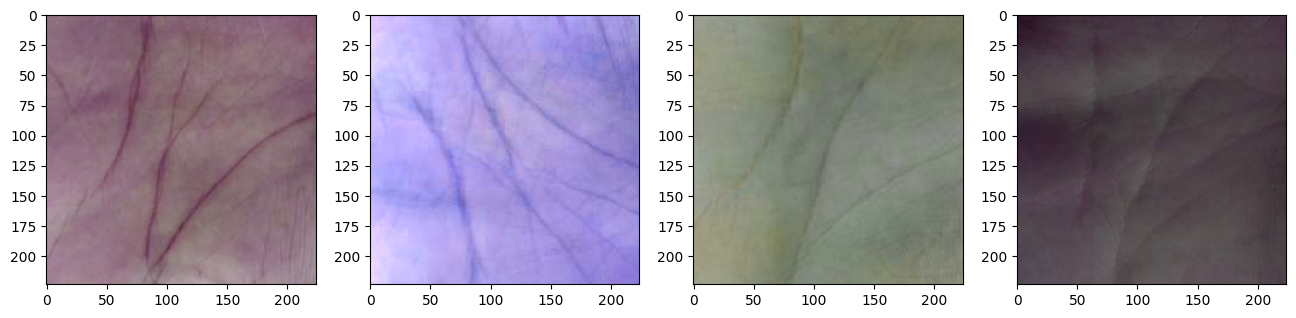

In [549]:
%matplotlib inline
plt.style.use('default')
## show training images
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
images = next(enumerate(trainingDataloader_source))[1][0]
for i in range(4):
    # b,g,r = img.split(3)[0]
    # rgb_img = torch.stack([r,g,b])
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())

# plt.savefig("images/modified_augmentation2.png")
plt.show()
plt.close()

In [809]:
model.load_state_dict(model_source.state_dict())

<All keys matched successfully>

In [98]:
# scheduler = StepLR(optimizer, step_size=1, gamma=0.65)
# scheduler.step()
optimizer

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.001
    lr: 3.088378945169074e-05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [40]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR

elr = 0.95
scheduler = ExponentialLR(optimizer, gamma=elr)
scheduler4center = ExponentialLR(optimzer4center, gamma=elr)
# scheduler4mapping = ExponentialLR(optimizer4mapping, gamma=elr)
prefix = "{}-{}s-{}-{}emb-{}-{}-{}l-{}lr_ELR{}-{}mm".format(dataset_type, shot, model_type, feature_dim, head_type, loss_func, lamb, lr, elr, mm)

# scheduler = StepLR(optimizer, step_size=5, gamma=0.65)
# scheduler4center = StepLR(optimzer4center, step_size=5, gamma=0.65)
# prefix += "-SLR0.65"
# prefix = "{}-{}s-{}-{}emb-{}-{}l-{}lr_{}-{}mm".format(dataset_type, shot, model_type, feature_dim, loss_func, lamb, lr, "SLR0.65", mm)

print("sameple model name: {}-{}e.pt".format(prefix, epoch))

sameple model name: PolyU-optuna-third-rotation-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr_ELR0.95-0.9mm-20e.pt


In [16]:
i, (img, labels) = next(enumerate(trainingDataloader_source))
inputs = img[:2].cuda()
labels = labels[:2].cuda()
model = model.cuda()
head = head.cuda()

feats = model(inputs) # output feature embeddings
# inputs = torch.rot90(inputs, 2, (-1,-2)) # 180 degree
# rotated_feats = model(inputs) # output feature embeddings
# mapped_feats = featureMapping(feats)
# mapped2_feats = featureMapping(rotated_feats)

margin_output, original_logits = head(feats, labels)
batch_loss = criterion["Softmax"](margin_output, labels) + criterion["CenterLoss"](feats, labels, head.centers()) * criterion["Lambda"]
optimizer.zero_grad() 
optimzer4center.zero_grad()
batch_loss.backward() 
optimizer.step() 
optimzer4center.step()
# nn.HuberLoss(delta=1)(rotated_feats, mapped_feats), cos(rotated_feats, mapped_feats), cos(feats, mapped_feats)

In [59]:
for i, (img, labels) in enumerate(trainingDataloader_source):
    inputs = img
    labels = labels
        
    feats = model(inputs) # output feature embeddings
    margin_output, original_logits = head(feats, labels)
    cosine_loss = criterion["Softmax"](margin_output, labels)
    centerloss = criterion["CenterLoss"](feats, labels, head.weight) * criterion["Lambda"]
    batch_loss = cosine_loss+centerloss
    _, train_pred = torch.max(original_logits.data, 1)
    optimizer.zero_grad() 
    optimzer4center.zero_grad()
    batch_loss.backward() 
    optimizer.step() 
    optimzer4center.step()

KeyboardInterrupt: 

In [553]:
## training
model = model.cuda()
head = head.cuda()
# featureMapping = featureMapping.cuda()
num_epoch = 20
for e in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    train_cosine_loss = 0.0
    train_center_loss = 0.0
    norm_max = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    head.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    # featureMapping.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, (img, labels) in enumerate(trainingDataloader_source):
        inputs = img.cuda()
        labels = labels.cuda()
            
        feats = model(inputs) # output feature embeddings
        margin_output, original_logits = head(feats, labels)
        # batch_loss = criterion["Softmax"](margin_output, labels) + criterion["CenterLoss"](feats, labels, head.centers()) * criterion["Lambda"]
        # batch_loss = criterion["Softmax"](margin_output, labels) + criterion["CenterLoss"](feats, labels, head.weight) * criterion["Lambda"]
        cosine_loss = criterion["Softmax"](margin_output, labels)
        centerloss = criterion["CenterLoss"](feats, labels, head.weight) * criterion["Lambda"]
        batch_loss = cosine_loss+centerloss
        # batch_loss = criterion["Softmax"](margin_output, labels) + criterion["CircleLoss"](feats, labels) * criterion["Lambda"]
        _, train_pred = torch.max(original_logits.data, 1)
        
        # 180 degree
        # inputs = torch.rot90(inputs, 2, (-1,-2))
        # rotated_centers = featureMapping[0](head.weight)
        # rotated_feats = model(inputs) # output feature embeddings
        # margin_output, original_logits = head(rotated_feats, labels, rotated_centers)
        # batch_loss += criterion["Softmax"](margin_output, labels) + criterion["CenterLoss"](rotated_feats, labels, rotated_centers) * criterion["Lambda"]
        
        optimizer.zero_grad() 
        optimzer4center.zero_grad()
        # optimizer4mapping.zero_grad()
        batch_loss.backward() 
        optimizer.step() 
        optimzer4center.step()
        # optimizer4mapping.step()
        
        train_acc += torch.sum(train_pred == labels).item()
        train_loss += batch_loss.item() * inputs.size(0)
        train_cosine_loss += cosine_loss.item() * inputs.size(0)
        train_center_loss += centerloss.item() * inputs.size(0)
        print("batch loss: {}".format(batch_loss.item()), end="\r")
        
        # max feature norm
        with torch.no_grad():
            norms = feats.norm(dim=-1)
            norm_max = norms.max().item() if norms.max() > norm_max else norm_max
        
    epoch += 1
    # scheduler.step()
    # if epoch >= 20:
    #     scheduler.step()
    #     scheduler4center.step()
        # scheduler4mapping.step()
    
    train_acc /=len(trainingDataset_source)
    train_loss /= len(trainingDataset_source)
    train_cosine_loss /= len(trainingDataset_source)
    train_center_loss /= len(trainingDataset_source)
    log_train_acc.append(train_acc)
    log_train_loss.append((train_loss, train_cosine_loss, train_center_loss))
    log_max_feature_norm.append(norm_max)
        
    # calculate norm of gradients
    total_norm = 0.0
    for p in model.parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
    total_norm = total_norm ** (1. / 2)
    log_gradient_norm.append(total_norm)
    
    # calculate val acc
    # val_acc = 0.0
    # val_loss = 0.0
    # if val_ratio != 0:
    #     model.eval()
    #     criterion.eval()
    #     with torch.no_grad():
    #         for i, (img, labels) in enumerate(validationDataloader_source):
    #             inputs = img.cuda()
    #             labels = labels.cuda()
    #             feats = model(inputs) # output feature embeddings
    #             logits, batch_loss = criterion(feats, labels)
    #             _, val_pred = torch.max(logits, 1)
    #             val_acc += torch.sum(val_pred == labels)
    #             val_loss += batch_loss.item() * inputs.size(0)
    #         log_test_acc.append(test_acc)
    #         val_acc /= len(validationDataset_source)
    #         val_loss /= len(validationDataset_source)
    #         log_val_acc.append(val_acc.cpu())
    #         log_val_loss.append(val_loss)
        
    # l = '[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f Val Acc: %3.6f Loss: %3.6f norm of gradient: %3.6f' % \
    #     (epoch, num_epoch, time.time()-epoch_start_time, train_acc, train_loss, val_acc, val_loss, total_norm)
    # print(l)
    
    # calculate test acc
    # model.eval()
    # gallery_feature_loader = torch.Tensor().cuda()
    # gallery_label_loader = torch.Tensor()
    # probe_feature_loader = torch.Tensor().cuda()
    # probe_label_loader = torch.Tensor()
    # with torch.no_grad():
    #     for i, (img, labels) in enumerate(galleryDataloader_source):
    #         inputs = img.cuda()
    #         feats = model(inputs)
    #         gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
    #         gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    #     for i, (img, labels) in enumerate(probeDataloader_source):
    #         inputs = img.cuda()
    #         feats = model(inputs)
    #         probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
    #         probe_label_loader = torch.cat([probe_label_loader, labels], 0)
    # cos = nn.CosineSimilarity()
    # test_acc = 0.0
    # for i,p in enumerate(probe_feature_loader):
    #     cosine = cos(p, gallery_feature_loader)
    #     test_pred = torch.max(cosine, 0).indices.item()
    #     test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    # test_acc /= len(probe_feature_loader)
    # log_test_acc.append(test_acc)
    
    model.eval()
    test_loss = 0.0
    gallery_feature_loader = torch.Tensor().cuda()
    gallery_label_loader = torch.Tensor().long()
    probe_feature_loader = torch.Tensor().cuda()
    probe_label_loader = torch.Tensor().long()
    with torch.no_grad():
        for i, (img, labels) in enumerate(galleryDataloader_target):
            inputs = img.cuda()
            feats = model(inputs)
            gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
            gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)

        # calculate centers of each class
        labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
        unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
        centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
        counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
        counts[unique_labels[:,0]] = labels_count
        centers = centers / counts.unsqueeze(1) # divide by label counts

        for i, (img, labels) in enumerate(probeDataloader_target):
            inputs = img.cuda()
            feats = model(inputs)
            probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
            probe_label_loader = torch.cat([probe_label_loader, labels], 0)

        centers = centers.cuda()
        probe_label_loader = probe_label_loader.cuda()
        logits = head.classify(probe_feature_loader, centers)     
        cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
        center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
        # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
        # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

    log_test_loss.append((cosine_loss+center_loss, cosine_loss, center_loss))
    cos = nn.CosineSimilarity()
    test_acc = 0.0
    for i,p in enumerate(probe_feature_loader):
        cosine = cos(p, gallery_feature_loader)
        test_pred = torch.max(cosine, 0).indices.item()
        test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    test_acc /= len(probe_feature_loader)
    log_test_acc.append(test_acc.item())
    
    ## testing loss
#     if epoch % 10 == 0:
#         model.eval()
#         test_loss = 0.0
#         gallery_feature_loader = torch.Tensor().cuda()
#         gallery_label_loader = torch.Tensor().long()
#         probe_feature_loader = torch.Tensor().cuda()
#         probe_label_loader = torch.Tensor().long()
#         with torch.no_grad():
#             for i, (img, labels) in enumerate(galleryDataloader_target):
#                 inputs = img.cuda()
#                 feats = model(inputs)
#                 gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
#                 gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)

#             # calculate centers of each class
#             labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
#             unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
#             centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
#             counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
#             counts[unique_labels[:,0]] = labels_count
#             centers = centers / counts.unsqueeze(1) # divide by label counts

#             for i, (img, labels) in enumerate(probeDataloader_target):
#                 inputs = img.cuda()
#                 feats = model(inputs)
#                 probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
#                 probe_label_loader = torch.cat([probe_label_loader, labels], 0)

#             centers = centers.cuda()
#             probe_label_loader = probe_label_loader.cuda()
#             logits = head.classify(probe_feature_loader, centers)     
#             cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
#             center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
            # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
            # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

#         log_test_loss.append((cosine_loss, center_loss))
#         cos = nn.CosineSimilarity()
#         test_acc = 0.0
#         for i,p in enumerate(probe_feature_loader):
#             cosine = cos(p, gallery_feature_loader)
#             test_pred = torch.max(cosine, 0).indices.item()
#             test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
#         test_acc /= len(probe_feature_loader)
#         log_test_acc.append(test_acc.item())
    
    l = '[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f test Acc: %3.6f norm of gradient: %3.6f' % \
        (epoch, num_epoch, time.time()-epoch_start_time, train_acc, train_loss, test_acc, total_norm)
    print(l)
    
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
            # 'featureMapping_state_dict': featureMapping.state_dict(),
            # 'featureMapping_180_state_dict': featureMapping[0].state_dict(),
            # 'featureMapping_90_state_dict': featureMapping[1].state_dict(),
            # 'featureMapping_270_state_dict': featureMapping[2].state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            # 'optimzer4center_state_dict': optimzer4center.state_dict(),
            # 'optimizer4mapping_state_dict': optimizer4mapping.state_dict(),
            'criterion': criterion,
            'training_class_indices': training_class_indices_source,
            'testing_class_indices': testing_class_indices_source,
            'trainingTransform': trainingTransform,
            'testingTransform': testingTransform
        }, "model/{}-{}e-optuna-third.pt".format(prefix, epoch))
        

[001/020] 70.58 sec(s) Train Acc: 0.008611 Loss: 27.264852 test Acc: 0.280667 norm of gradient: 11.787927
[002/020] 57.72 sec(s) Train Acc: 0.195278 Loss: 24.286312 test Acc: 0.535000 norm of gradient: 39.256597
[003/020] 58.92 sec(s) Train Acc: 0.784583 Loss: 17.353152 test Acc: 0.949333 norm of gradient: 42.535383
[004/020] 58.77 sec(s) Train Acc: 0.952778 Loss: 10.379092 test Acc: 0.991333 norm of gradient: 38.488941
[005/020] 59.50 sec(s) Train Acc: 0.970000 Loss: 6.553864 test Acc: 0.993667 norm of gradient: 36.133065
[006/020] 59.56 sec(s) Train Acc: 0.971667 Loss: 4.665862 test Acc: 0.997667 norm of gradient: 41.452281
[007/020] 59.14 sec(s) Train Acc: 0.970556 Loss: 3.582576 test Acc: 0.991667 norm of gradient: 29.555035
[008/020] 59.09 sec(s) Train Acc: 0.968472 Loss: 2.941718 test Acc: 0.995333 norm of gradient: 35.440363
[009/020] 61.88 sec(s) Train Acc: 0.974722 Loss: 2.208610 test Acc: 0.998000 norm of gradient: 41.469110
[010/020] 58.97 sec(s) Train Acc: 0.977778 Loss: 1.

In [554]:
log_test_loss

[(4.377110493183136, 4.329819202423096, 0.04729129076004029),
 (2.8307965993881226, 2.499969482421875, 0.33082711696624756),
 (0.2504912048578262, 0.1965673416852951, 0.05392386317253113),
 (0.08421281427145005, 0.03576000779867172, 0.048452806472778324),
 (0.057781656831502916, 0.02164643630385399, 0.03613522052764893),
 (0.03609126638621092, 0.008752266876399517, 0.027338999509811404),
 (0.06729543656110763, 0.0374971404671669, 0.029798296093940736),
 (0.048978489264845854, 0.026012307032942772, 0.022966182231903078),
 (0.037219437584280965, 0.014335079118609428, 0.02288435846567154),
 (0.03527089692652226, 0.011672722175717354, 0.023598174750804904),
 (0.040291573852300644, 0.017107028514146805, 0.02318454533815384),
 (0.04884069040417671, 0.02723626419901848, 0.021604426205158234),
 (0.06036262661218643, 0.03953494876623154, 0.020827677845954896),
 (0.04121867865324021, 0.017403103411197662, 0.023815575242042544),
 (0.042868273332715034, 0.020540961995720863, 0.02232731133699417),


In [817]:
log_loader = []

In [822]:
log_loader.append({
    "log_train_loss":log_train_loss,
    "log_test_loss":log_test_loss,
    "log_train_acc":log_train_acc,
    "log_test_acc":log_test_acc,
    "log_gradient_norm":log_gradient_norm,
    "log_max_feature_norm":log_max_feature_norm,
})
len(log_loader)

3

In [557]:
torch.save(log_loader, "plot/{}-{}e-train-optuna-third.pt".format(prefix, epoch))

In [821]:
## load log
checkpoint = torch.load("plot/PolyU-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-optuna-third.pt")[0]
log_train_loss = checkpoint['log_train_loss']
log_test_loss = checkpoint['log_test_loss']
log_train_acc = checkpoint['log_train_acc']
log_test_acc = checkpoint['log_test_acc']
log_gradient_norm = checkpoint['log_gradient_norm']
log_max_feature_norm = checkpoint['log_max_feature_norm']
# log_loader = []

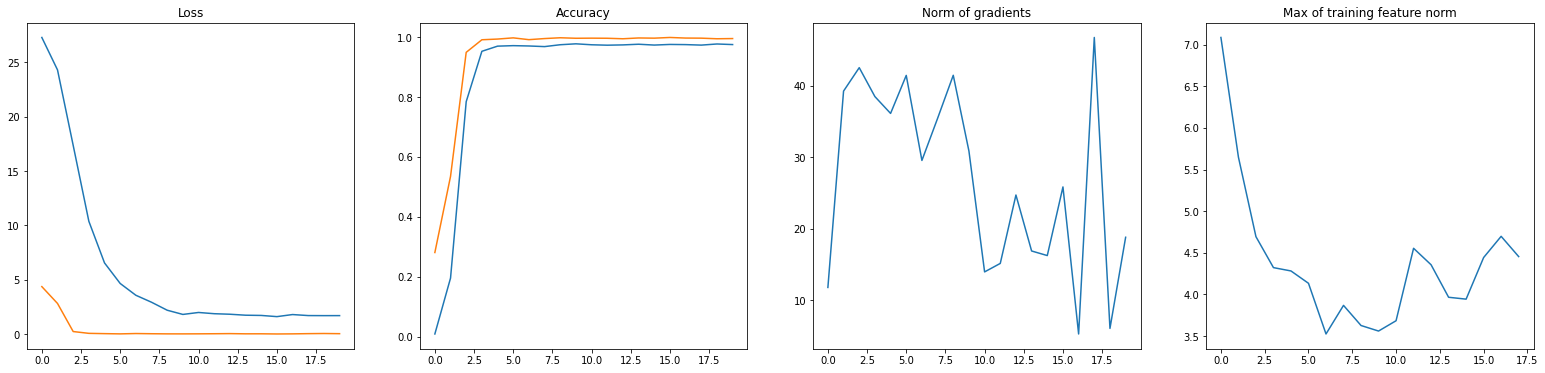

In [558]:
## training curve
%matplotlib inline

# training_record = (log_loss, log_acc, log_test_acc, log_gradient_norm)
fig, axs = plt.subplots(1, 4, figsize=(27, 6))
# axs[0].plot(log_train_loss)
axs[0].plot([loss[0] for loss in log_train_loss])
axs[0].plot([loss[0] for loss in log_test_loss])
# axs[0].plot([loss[1] for loss in log_test_loss])
# axs[0].set_ylim([0,2])
axs[0].set_title("Loss")
axs[1].plot(log_train_acc)
# axs[1].plot(log_val_acc)
axs[1].plot(log_test_acc)
axs[1].set_title("Accuracy")
axs[2].plot(log_gradient_norm)
axs[2].set_title("Norm of gradients")
axs[3].plot(log_max_feature_norm[2:])
axs[3].set_title("Max of training feature norm")
plt.savefig('plot/{}-{}e-train-optuna-third.jpg'.format(prefix, epoch))
plt.show()

# torch.save({
#     "log_train_loss":log_train_loss,
#     "log_test_loss":log_test_loss,
#     "log_train_acc":log_train_acc,
#     "log_test_acc":log_test_acc,
#     "log_gradient_norm":log_gradient_norm,
#     "log_max_feature_norm":log_max_feature_norm,
# }, "plot/{}-{}e-train.pt".format(prefix, epoch))

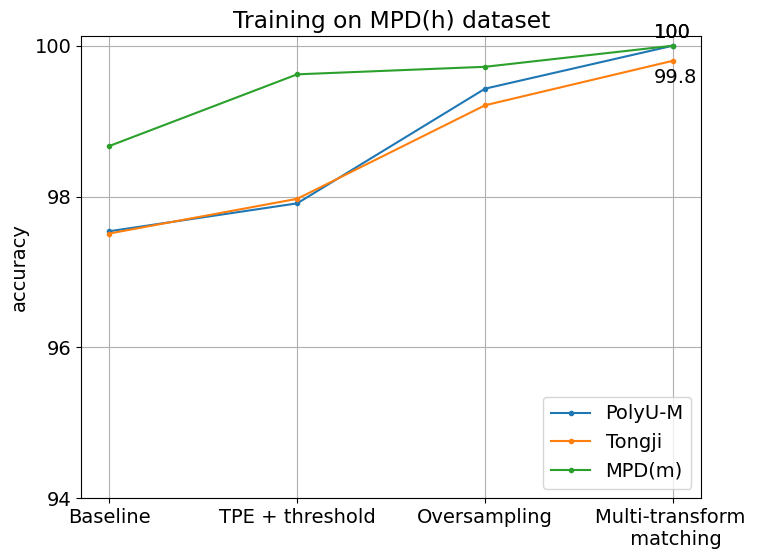

In [321]:
# chap 5.5 cumulative improvement
%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(8,6), dpi=100)

xlabels = ["Baseline", "TPE + threshold", "Oversampling", "Multi-transform \n matching"]

# p_t = [92.03, 93.76, 97.46, 98.81]
# p_mh = [72.87, 85.27, 90.03, 94.33]
# p_mm = [71.53, 84.08, 89.42, 94.08]
# plt.plot(xlabels, p_t, marker='.', label="Tongji")
# plt.plot(xlabels, p_mh, marker='.', label="MPD(h)")
# plt.plot(xlabels, p_mm, marker='.', label="MPD(m)")
# plt.text(len(p_t)-1.15, p_t[-1]-1.1, p_t[-1], size=14)
# plt.text(len(p_mh)-1.15, p_mh[-1]+0.6, p_mh[-1], size=14)
# plt.text(len(p_mm)-1.15, p_mm[-1]-1.4, p_mm[-1], size=14)
# plt.title("Training on PolyU-M dataset")
# plt.ylim([70,100])

# t_p = [97, 98, 99.77, 100]
# t_mh = [77.28, 85.77, 94.27, 95.78]
# t_mm = [76.13, 86.67, 92.80, 94.28]
# plt.plot(xlabels, t_p, marker='.', label="PolyU-M")
# plt.plot(xlabels, t_mh, marker='.', label="MPD(h)")
# plt.plot(xlabels, t_mm, marker='.', label="MPD(m)")
# plt.text(len(t_p)-1.15, t_p[-1]-1.1, t_p[-1], size=14)
# plt.text(len(t_mh)-1.15, t_mh[-1]+0.6, t_mh[-1], size=14)
# plt.text(len(t_mm)-1.15, t_mm[-1]-1.2, t_mm[-1], size=14)
# plt.title("Training on Tongji dataset")
# plt.ylim([70,100])

mh_p = [97.54, 97.91, 99.43, 100]
mh_t = [97.51, 97.97, 99.21, 99.8]
mh_mm = [98.67, 99.62, 99.72, 100]
plt.plot(xlabels, mh_p, marker='.', label="PolyU-M")
plt.plot(xlabels, mh_t, marker='.', label="Tongji")
plt.plot(xlabels, mh_mm, marker='.', label="MPD(m)")
plt.text(len(mh_p)-1.1, mh_p[-1]+0.1, mh_p[-1], size=14)
plt.text(len(mh_t)-1.1, mh_t[-1]-0.3, mh_t[-1], size=14)
plt.text(len(mh_mm)-1.1, mh_mm[-1]+0.1, mh_mm[-1], size=14)
plt.title("Training on MPD(h) dataset")
plt.yticks(range(94, 102, 2))

# mm_p = [94.63, 96.86, 99.23, 100]
# mm_t = [94.90, 95.82, 98.79, 99.66]
# mm_mh = [98.92, 99.22, 99.77, 99.98]
# plt.plot(xlabels, mm_p, marker='.', label="PolyU-M")
# plt.plot(xlabels, mm_t, marker='.', label="Tongji")
# plt.plot(xlabels, mm_mh, marker='.', label="MPD(h)")
# plt.text(len(mm_p)-1.1, mm_p[-1]+0.05, mm_p[-1], size=14)
# plt.text(len(mm_t)-1.15, mm_t[-1]-0.4, mm_t[-1], size=14)
# plt.text(len(mm_mh)-1, mm_mh[-1]-0.2, mm_mh[-1], size=14)
# plt.title("Training on MPD(m) dataset")
# plt.yticks(range(94, 102, 2))

# plt.ylim([70,100])
plt.ylabel("accuracy")
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

# fig.savefig('plot/cumulative-accuracy-improvement-polyu.pdf') 
# fig.savefig('plot/cumulative-accuracy-improvement-tongji.pdf')
fig.savefig('plot/cumulative-accuracy-improvement-mpdh.pdf') 
# fig.savefig('plot/cumulative-accuracy-improvement-mpdm.pdf') 

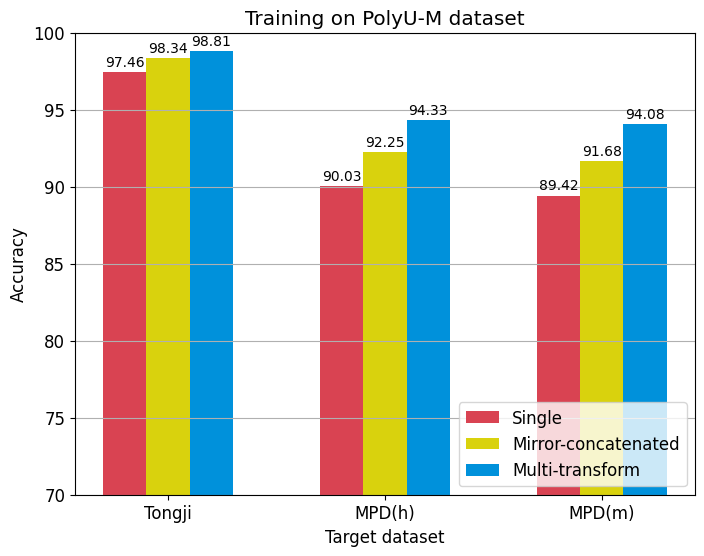

In [7]:
# chap 5.4 mathcing
%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})

def plot_accuracy_bar(subplot, baseline, TPE, TPE_threshold, target_dataset, title):
    X = np.arange(len(target_dataset))
    width = 0.2
    single_bar = subplot.bar(X, baseline, width, color="#D94352", label='Single')
    mirror_bar = subplot.bar(X + width, TPE, width, color="#D9D20D", label='Mirror-concatenated')
    multi_bar = subplot.bar(X + width*2, TPE_threshold, width, color="#0091DB", label='Multi-transform')
    subplot.bar_label(single_bar, padding=2, size=10)
    subplot.bar_label(mirror_bar, padding=2, size=10)
    subplot.bar_label(multi_bar, padding=2, size=10)

    subplot.title(title)
    subplot.xticks(X + width, target_dataset)
    subplot.xlabel('Target dataset')
    subplot.ylabel('Accuracy')
    subplot.ylim([70,100])
    subplot.gca().yaxis.grid(True)
    

# plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(8,6), dpi=100)
# fig, axs = plt.subplots(1, 2, figsize=(16, 7), dpi=100)

# polyu
target_dataset = ['Tongji', 'MPD(h)', 'MPD(m)']
single = [97.46, 90.03, 89.42]
mirror = [98.34, 92.25, 91.68]
multi = [98.81, 94.33, 94.08]
plot_accuracy_bar(plt, single, mirror, multi, target_dataset, 'Training on PolyU-M dataset')

# tongji
# target_dataset = ['PolyU-M', 'MPD(h)', 'MPD(m)']
# single = [99.77, 94.27, 92.80]
# mirror = [100, 95.63, 93.55]
# multi = [100, 95.78, 94.28]
# plot_accuracy_bar(plt, single, mirror, multi, target_dataset, 'Training on Tongji dataset')

# bars, labels = fig.axes[0].get_legend_handles_labels()
# fig.legend(bars, labels, loc='upper center')
plt.legend(["Single", "Mirror-concatenated", "Multi-transform"], loc='lower right')
plt.show()

fig.savefig('images/matching-comparison-polyu-train.pdf')
# fig.savefig('images/matching-comparison-tongji-train.pdf')

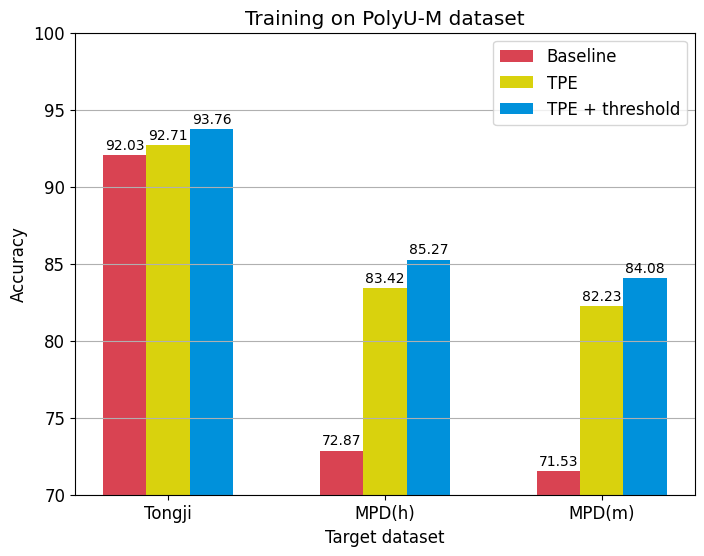

In [219]:
# chap 5.3 data warping
%matplotlib inline
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})
# plt.rc('axes', titlesize=14)
# plt.rc('axes', labelsize=14)
# plt.rc('xtick', labelsize=12)
# plt.rc('ytick', labelsize=12)
# plt.rc('legend', fontsize=12)

def plot_accuracy_bar(subplot, baseline, TPE, TPE_threshold, target_dataset, title):
    X = np.arange(len(target_dataset))
    width = 0.2
    baseline_bar = subplot.bar(X, baseline, width, color="#D94352", label='Baseline')
    TPE_bar = subplot.bar(X + width, TPE, width, color="#D9D20D", label='TPE')
    TPE_threshold_bar = subplot.bar(X + width*2, TPE_threshold, width, color="#0091DB", label='TPE + threshold')
    subplot.bar_label(baseline_bar, padding=2, fmt="%.2f", size=10)
    subplot.bar_label(TPE_bar, padding=2, fmt="%.2f", size=10)
    subplot.bar_label(TPE_threshold_bar, padding=2, fmt="%.2f", size=10)

    subplot.title(title)
    subplot.xticks(X + width, target_dataset)
    subplot.xlabel('Target dataset')
    subplot.ylabel('Accuracy')
    subplot.ylim([70,100])
    subplot.gca().yaxis.grid(True)
    

# plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(8,6), dpi=100)
# fig, axs = plt.subplots(1, 2, figsize=(16, 7), dpi=100)

# polyu
target_dataset = ['Tongji', 'MPD(h)', 'MPD(m)']
baseline = [92.03, 72.87, 71.53]
TPE = [92.71, 83.42, 82.23]
TPE_threshold = [93.76, 85.27, 84.08]
plot_accuracy_bar(plt, baseline, TPE, TPE_threshold, target_dataset, 'Training on PolyU-M dataset')

# tongji
# target_dataset = ['PolyU-M', 'MPD(h)', 'MPD(m)']
# baseline = [97.00, 77.28, 76.13]
# TPE = [97.60, 85.95, 84.07]
# TPE_threshold = [98.00, 85.77, 86.67]
# plot_accuracy_bar(plt, baseline, TPE, TPE_threshold, target_dataset, 'Training on Tongji dataset')

# MPD(h)
# target_dataset = ['PolyU-M', 'Tongji', 'MPD(m)']
# baseline = [97.54, 97.51, 99.62]
# TPE = [98.23, 96.49, 98.72]
# TPE_threshold = [97.91, 97.97, 98.67]
# plot_accuracy_bar(axs[1][0], baseline, TPE, TPE_threshold, target_dataset, 'Training on MPD(h)')

# MPD(h)
# target_dataset = ['PolyU-M', 'Tongji', 'MPD(h)']
# baseline = [94.63, 94.90, 99.22]
# TPE = [97.66, 95.48, 98.97]
# TPE_threshold = [96.89, 95.82, 98.92]
# plot_accuracy_bar(axs[1][1], baseline, TPE, TPE_threshold, target_dataset, 'Training on MPD(m)')

# bars, labels = fig.axes[0].get_legend_handles_labels()
# fig.legend(bars, labels, loc='upper center')
plt.legend(bars, labels, loc='best')
plt.show()

fig.savefig('images/aug-comparison-polyu-train.pdf')
# fig.savefig('images/aug-comparison-tongji-train.pdf')

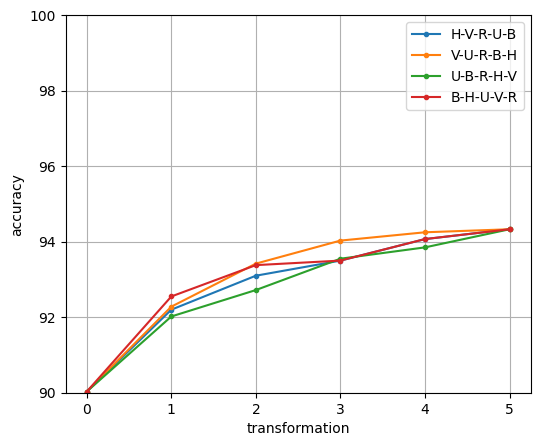

In [829]:
%matplotlib inline
# plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,5), dpi=100)
# degree_sign = u'\N{DEGREE SIGN}'
HVRUB = [90.03,92.20,93.10,93.50,94.07,94.33]
VURBH = [90.03,92.28,93.42,94.03,94.25,94.33]
UBRHV = [90.03,92.02,92.72,93.55,93.85,94.33]
BHUVR = [90.03,92.55,93.38,93.50,94.07,94.33]
plt.plot(HVRUB, marker='.')
plt.plot(VURBH, marker='.')
plt.plot(UBRHV, marker='.')
plt.plot(BHUVR, marker='.')
plt.xlabel("transformation")

plt.ylim([90,100])
plt.ylabel("accuracy")
plt.grid(True)
plt.legend(["H-V-R-U-B", "V-U-R-B-H", "U-B-R-H-V", "B-H-U-V-R"])
plt.show()

fig.savefig('plot/cumulative-matching-accuracy.pdf')

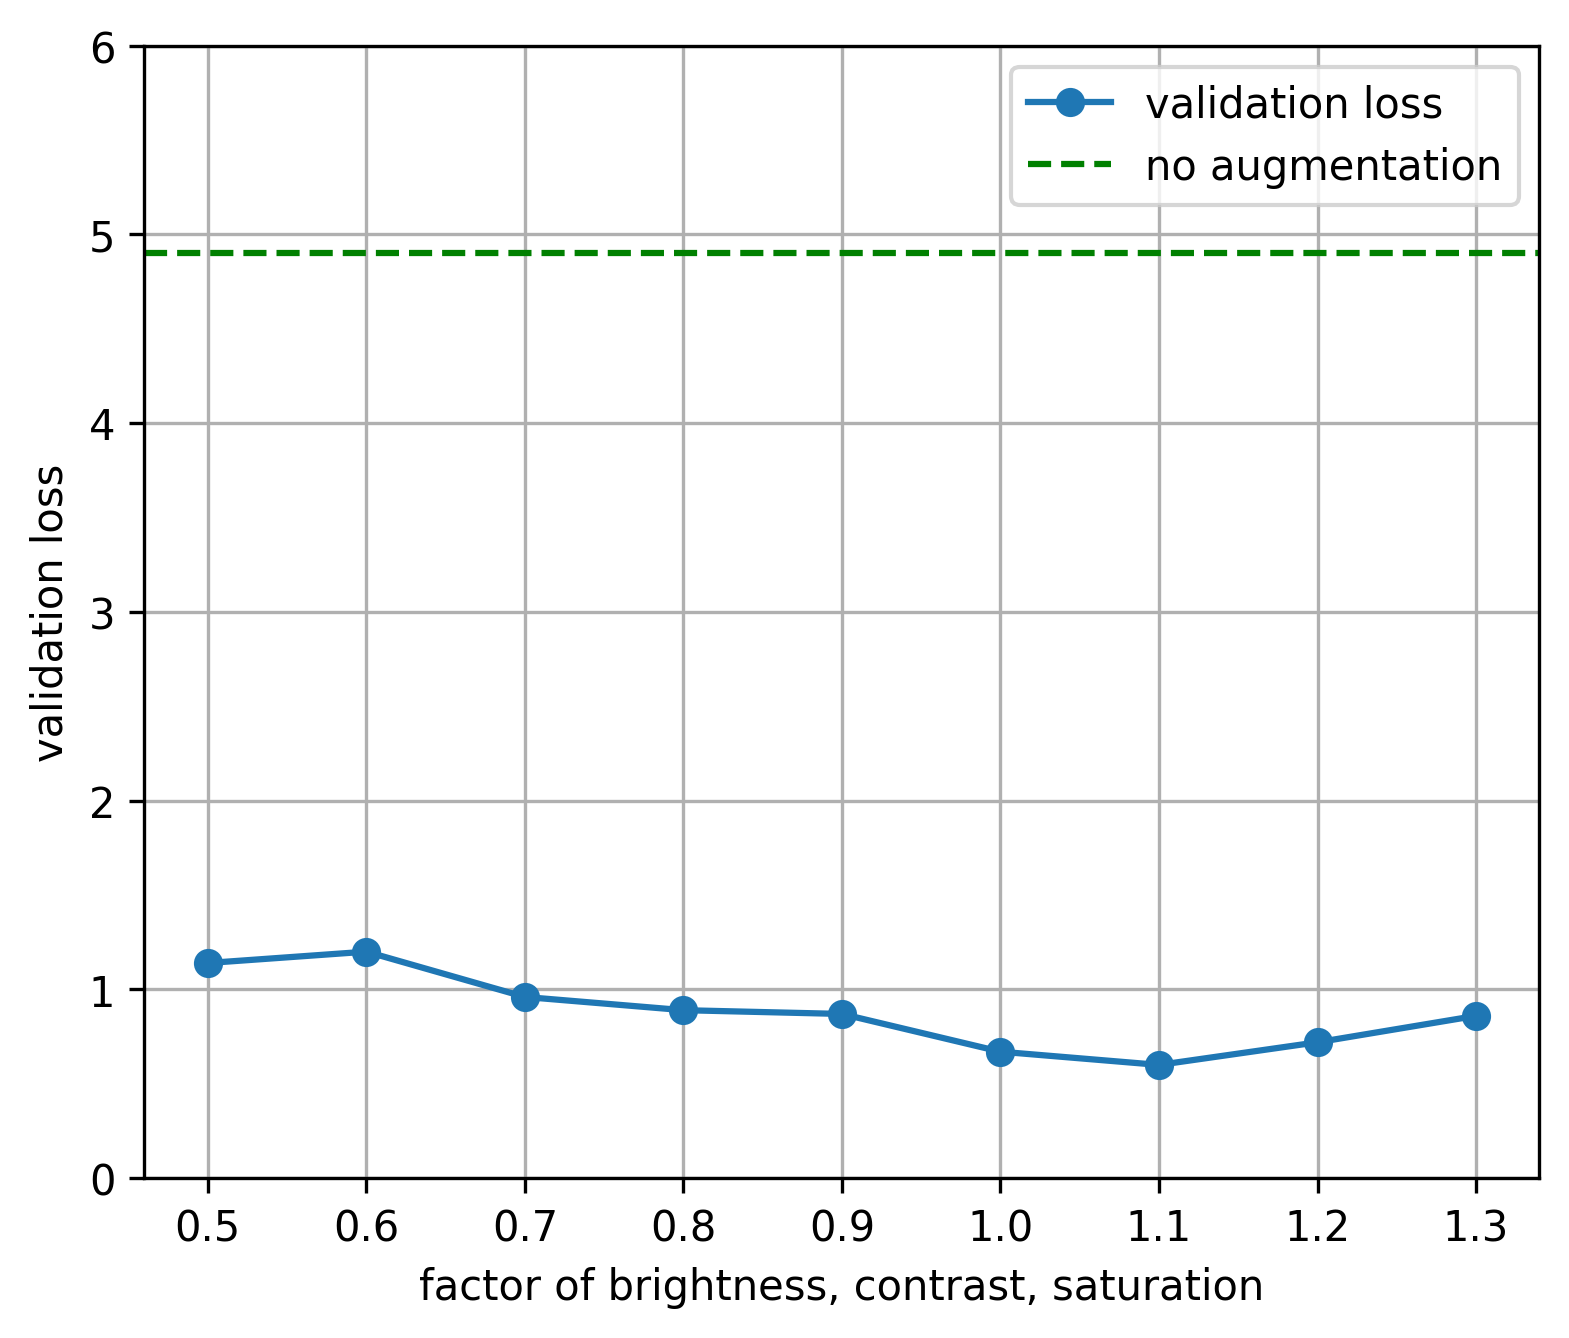

In [52]:
# manual augmentation
%matplotlib inline
fig = plt.figure(figsize=(6,5), dpi=300)

# rotation = [3.41,4.33,2.8,3,4.28,3.01,3.37,3.41]
# rotation_i = range(1,9)
# plt.plot(rotation_i, rotation, marker='o')
# plt.xlabel("degree")

# shift = [3.79,4.94,2.95,3.77,4.36]
# shift_i = [i/10 for i in range(1,6)]
# plt.plot(shift_i, shift, marker='o')
# plt.xlabel("translation coefficient")

# blur = [4.71,4.77,4.13,5.86,3.82,5.14,5.38]
# blur_i = range(1,8)
# plt.plot(blur_i, blur, marker='o')
# plt.xlabel("sigma")

# noise = [4.19,5.87,4.52,5.81,5.7]
# noise_i = range(1,6)
# plt.plot(noise_i, noise, marker='o')
# plt.xlabel("noise magnification")

# hue = [3.83,3.44,2.83,3.09,2.16]
# hue_i = [i/10 for i in range(1,6)]
# plt.plot(hue_i, hue, marker='o')
# plt.xlabel("hue")

color = [1.14,1.2,0.96,0.89,0.87,0.67,0.6,0.72,0.86]
color_i = [i/10 for i in range(5,14)]
plt.plot(color_i, color, marker='o')
plt.xlabel("factor of brightness, contrast, saturation")

plt.axhline(y=4.9, color='g', linestyle='--', label="no augmentation")
plt.ylim([0,6])
plt.ylabel("validation loss")
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)
plt.legend(["validation loss", "no augmentation"])
plt.show()

# fig.savefig('plot/rotations-validation-loss.pdf')
# fig.savefig('plot/shift-validation-loss.pdf')
# fig.savefig('plot/blur-validation-loss.pdf')
# fig.savefig('plot/noise-validation-loss.pdf')
# fig.savefig('plot/hue-validation-loss.pdf')
fig.savefig('plot/color-validation-loss.pdf')



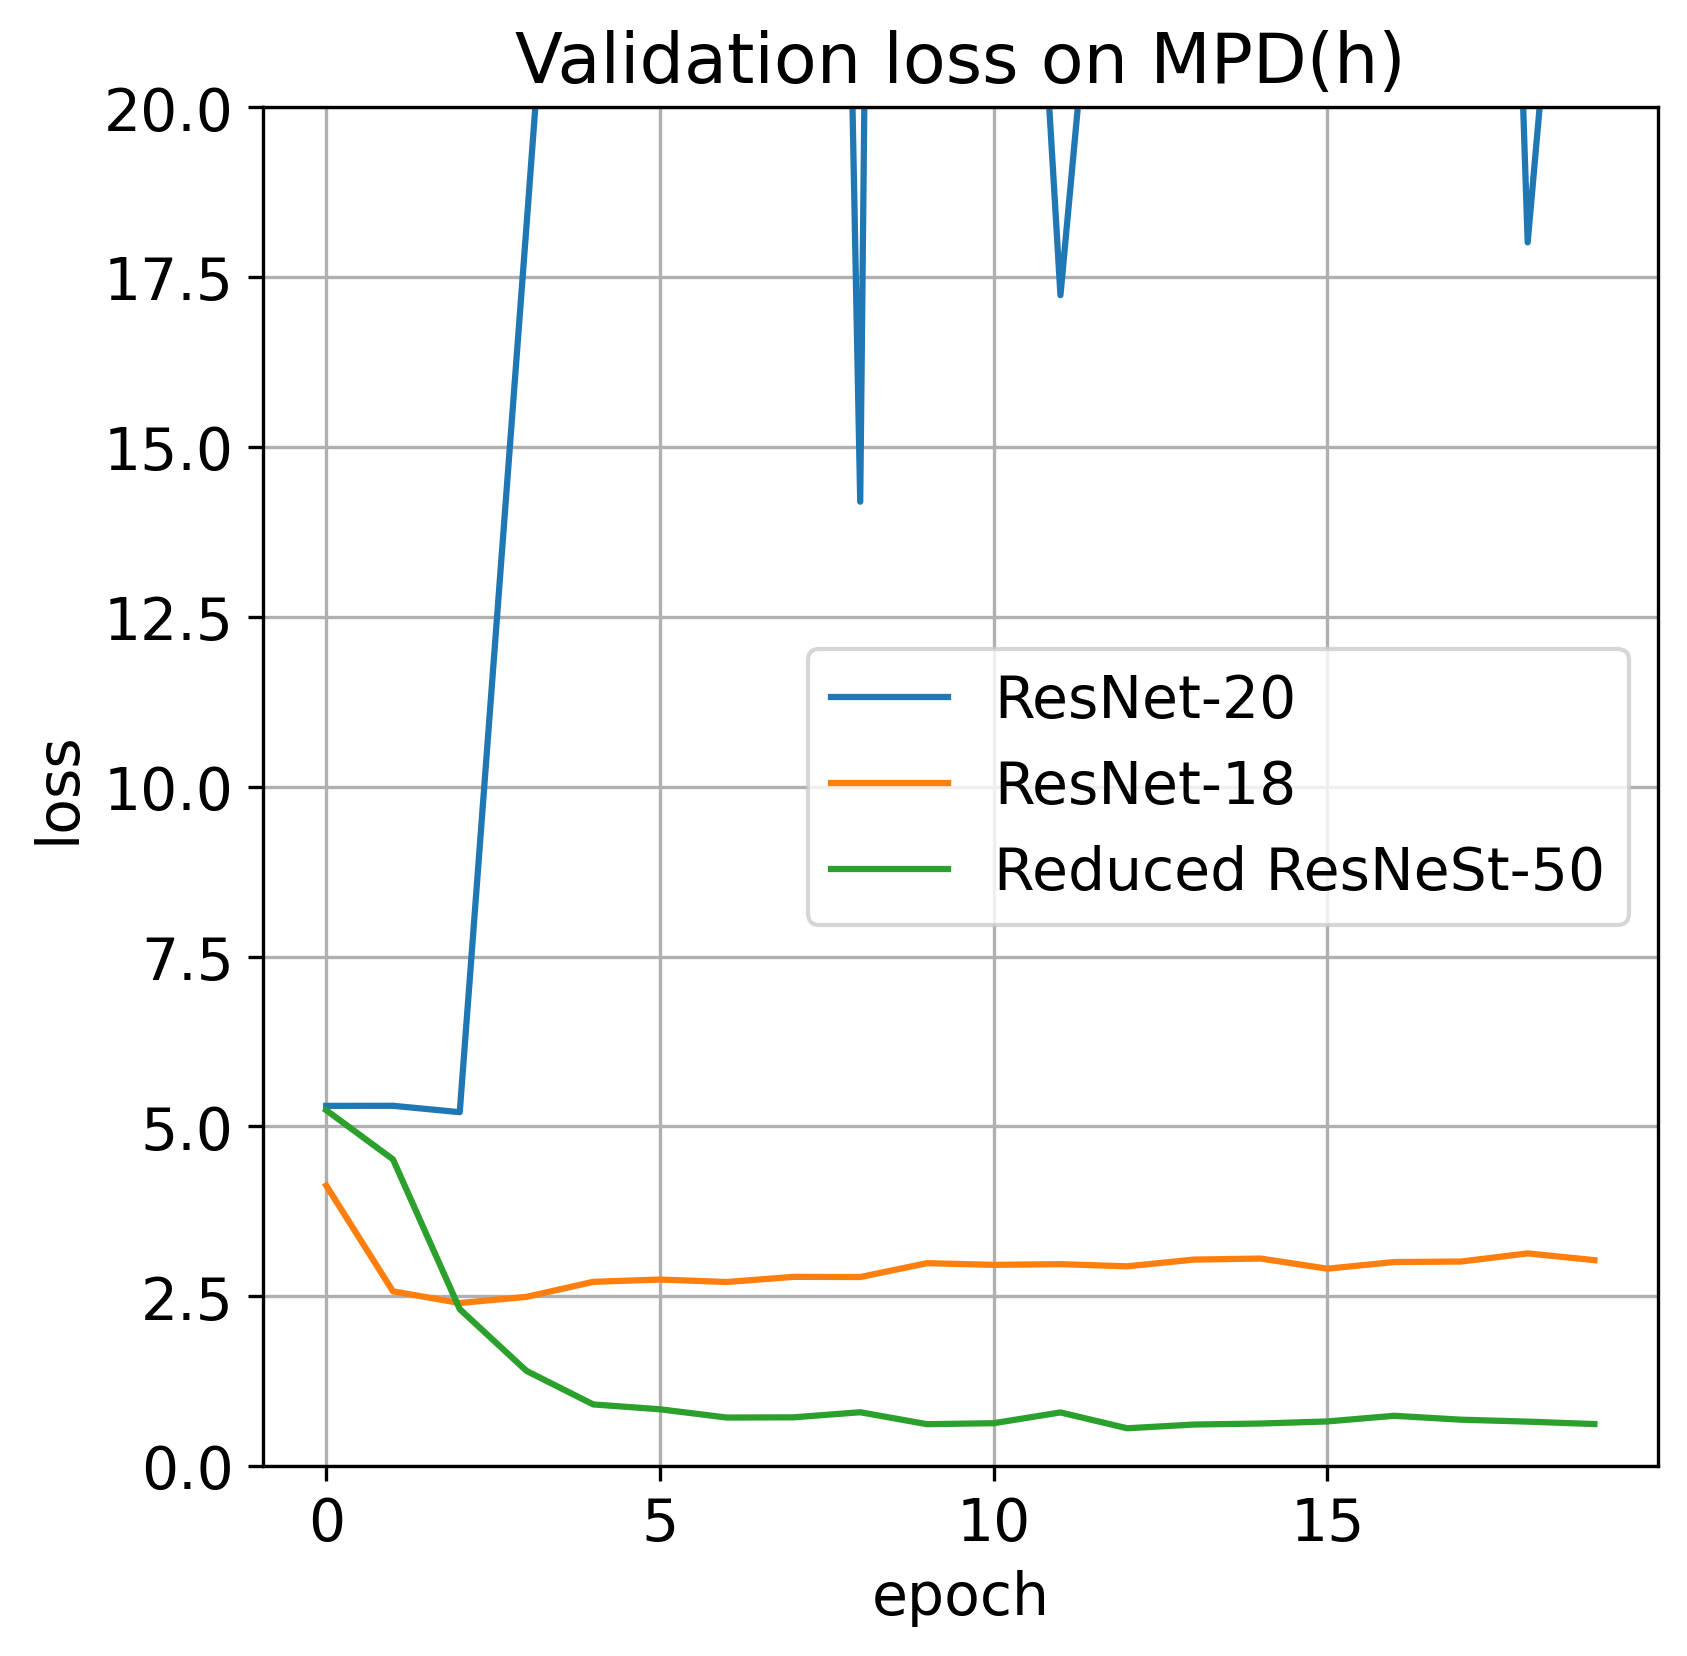

In [811]:
## training curve
%matplotlib inline
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,6), dpi=300)

def fig_setting():
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)

# chap 4.1.1.2 pretrained model
# MPD_m-5s-ResNeSt26d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-pretrained
# PolyU-5s-ResNeSt26d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-0e-train-pretrained
# train_loss_pretrained = [l[0] for l in log_loader[1]["log_train_loss"]]
# test_loss_pretrained = [l[0] for l in log_loader[1]["log_test_loss"]]
# plt.plot(train_loss_pretrained)
# plt.plot(test_loss_pretrained)
# fig_setting()
# plt.title("Pre-trained model")
# plt.legend(["training loss", "validation loss"])
# plt.savefig('plot/pretrained-model-loss.pdf')
# plt.show()

# chap 4.1.1.2 nopretrained model
# MPD_m-5s-ResNeSt26d-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-200e-train-nopretrained
# PolyU-5s-ResNeSt26d-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-200e-train-nopretrained
# train_loss_nopretrained = [l[0] for l in log_loader[0]["log_train_loss"]]
# test_loss_nopretrained = [l[0] for l in log_loader[0]["log_test_loss"]]
# plt.plot(train_loss_nopretrained)
# plt.plot(test_loss_nopretrained)
# fig_setting()
# plt.title("Training from scratch")
# plt.legend(["training loss", "validation loss"])
# plt.savefig('plot/nopretrained-model-loss.pdf')
# plt.show()

# chap 4.1.1.3 reduced ResNeSt-50
# MPD_m-5s-ResNeSt26d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-pretrained
# MPD_m-5s-Reduced_ResNeSt26d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-pretrained-reduced1
# MPD_m-5s-Double_Reduced_ResNeSt26d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-pretrained-reduced2
# test_loss_reduced0 = [l[0] for l in log_loader[0]["log_test_loss"]]
# test_loss_reduced1 = [l[0] for l in log_loader[1]["log_test_loss"]]
# test_loss_reduced2 = [l[0] for l in log_loader[2]["log_test_loss"]]
# plt.plot(test_loss_reduced0)
# plt.plot(test_loss_reduced1)
# plt.plot(test_loss_reduced2)
# fig_setting()
# plt.title("Validation loss on MPD(h)")
# plt.legend(["ResNeSt-26", "ResNeSt-26 - layer 4", "ResNeSt-26 - layer [3,4]"])
# plt.savefig('plot/reduced-resnest26-validation-loss-compare.pdf')
# # plt.legend(["ResNeSt-50", "ResNeSt-50 - layer 4", "ResNeSt-50 - layer [3,4]"])
# # plt.savefig('plot/reduced-resnest50-validation-loss-compare.pdf')
# plt.show()

# chap 4.1.1.3 reduced ResNeSt-50
# train_loss_reduced0 = [l[0] for l in log_loader[0]["log_train_loss"]]
# train_loss_reduced1 = [l[0] for l in log_loader[1]["log_train_loss"]]
# train_loss_reduced2 = [l[0] for l in log_loader[2]["log_train_loss"]]
# plt.plot(train_loss_reduced0)
# plt.plot(train_loss_reduced1)
# plt.plot(train_loss_reduced2)
# fig_setting()
# plt.title("Training loss on PolyU-M dataset")
# plt.legend(["ResNeSt-26", "ResNeSt-26 - layer 4", "ResNeSt-26 - layer [3,4]"])
# plt.savefig('plot/reduced-resnest26-train-loss-compare.pdf')
# # plt.legend(["ResNeSt-50", "ResNeSt-50 - layer 4", "ResNeSt-50 - layer [3,4]"])
# # plt.savefig('plot/reduced-resnest50-train-loss-compare.pdf')
# plt.show()

# chap 5.4.3 model comparison
# PolyU-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-comparison
# PolyU-5s-pretrained_ResNet18-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-comparison
# PolyU-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-comparison
# train_loss_resnet20 = [l[0] for l in log_loader[0]["log_train_loss"]]
# train_loss_resnet18 = [l[0] for l in log_loader[1]["log_train_loss"]]
# train_loss_resnest50 = [l[0] for l in log_loader[2]["log_train_loss"]]
# plt.plot(train_loss_resnet20)
# plt.plot(train_loss_resnet18)
# plt.plot(train_loss_resnest50)
# fig_setting()
# plt.title("Training loss on PolyU-M dataset")
# plt.legend(["ResNet-20", "ResNet-18", "Reduced ResNeSt-50"])
# plt.savefig('plot/model-comparison-train-loss.pdf')
# plt.show()

test_loss_resnet20 = [l[0] for l in log_loader[0]["log_test_loss"]]
test_loss_resnet18 = [l[0] for l in log_loader[1]["log_test_loss"]]
# test_loss_resnest26 = [l[0] for l in log_loader[2]["log_test_loss"]]
test_loss_resnest50 = [l[0] for l in log_loader[2]["log_test_loss"]]
plt.plot(test_loss_resnet20)
plt.plot(test_loss_resnet18)
# plt.plot(test_loss_resnest26)
plt.plot(test_loss_resnest50)
fig_setting()
plt.ylim([0,20])
plt.title("Validation loss on MPD(h)")
plt.legend(["ResNet-20", "ResNet-18", "Reduced ResNeSt-50"])
plt.savefig('plot/model-comparison-validation-loss.pdf')
plt.show()

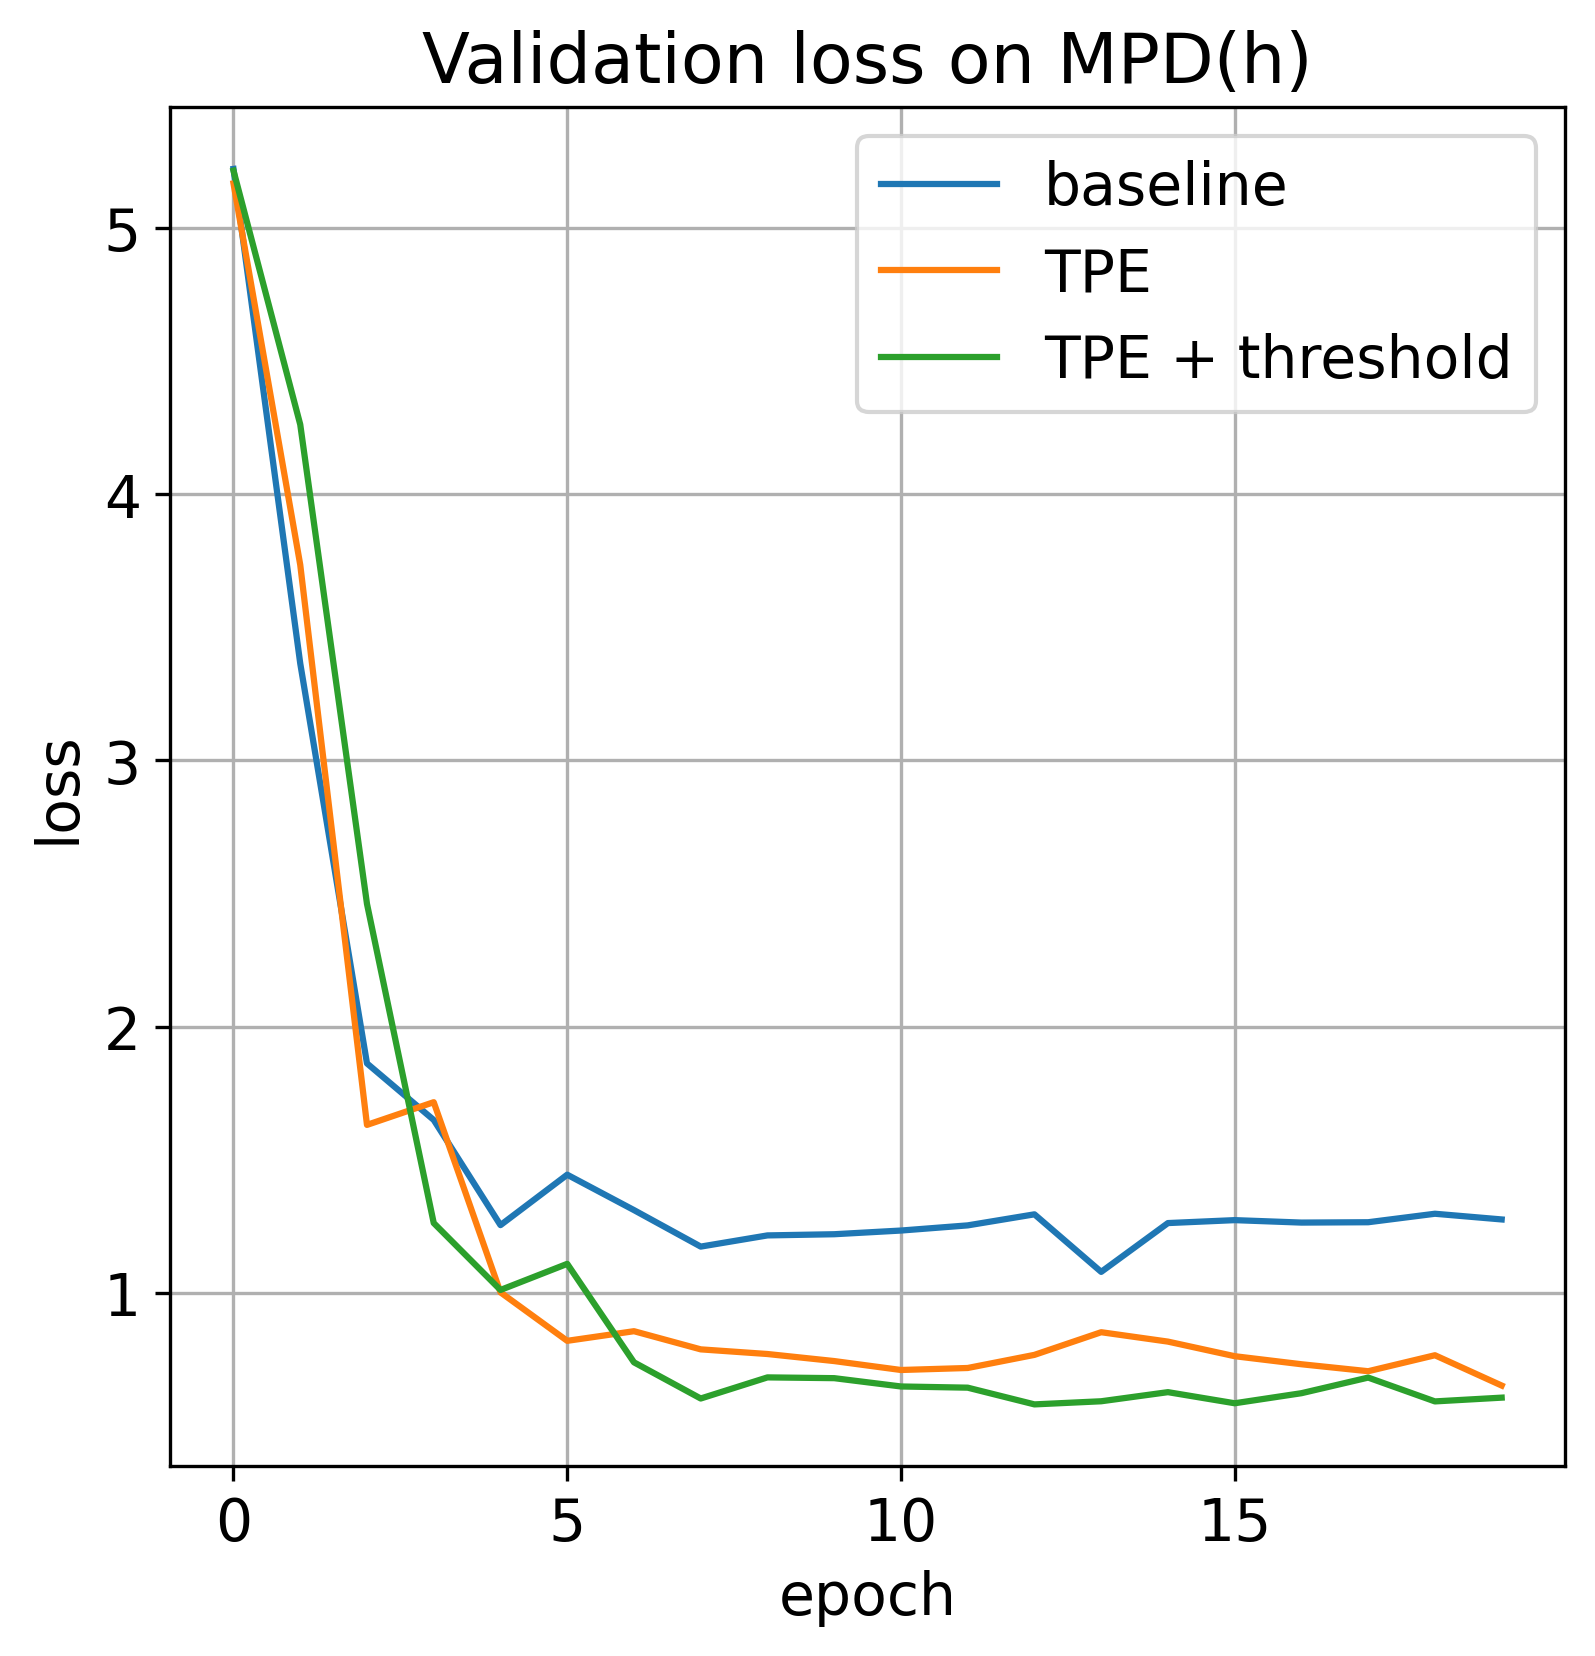

In [827]:
## training curve
%matplotlib inline
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,6), dpi=300)

def fig_setting():
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)

# chap 5.5.3 augmentation compare
# train_loss_baseline = [l[0] for l in log_loader[0]["log_train_loss"]]
# # train_loss_manual = [l[0] for l in log_loader[1]["log_train_loss"]]
# train_loss_first = [l[0] for l in log_loader[1]["log_train_loss"]]
# train_loss_third = [l[0] for l in log_loader[2]["log_train_loss"]]
# plt.plot(train_loss_baseline)
# # plt.plot(train_loss_manual)
# plt.plot(train_loss_first)
# plt.plot(train_loss_third)
# fig_setting()
# plt.title("Training loss on PolyU dataset")
# # plt.legend(["baseline", "manual", "TPE", "TPE + threshold"])
# plt.legend(["baseline", "TPE", "TPE + threshold"])
# plt.savefig('plot/aumentation-train-loss-compare.pdf')
# plt.show()

test_loss_baseline = [l[0] for l in log_loader[0]["log_test_loss"]]
# test_loss_manual = [l[0] for l in log_loader[1]["log_test_loss"]]
test_loss_first = [l[0] for l in log_loader[1]["log_test_loss"]]
test_loss_third = [l[0] for l in log_loader[2]["log_test_loss"]]
plt.plot(test_loss_baseline)
# plt.plot(test_loss_manual)
plt.plot(test_loss_first)
plt.plot(test_loss_third)
fig_setting()
# plt.ylim([0,2])
plt.title("Validation loss on MPD(h)")
# plt.legend(["baseline", "manual", "TPE", "TPE + threshold"])
plt.legend(["baseline", "TPE", "TPE + threshold"])
plt.savefig('plot/augmentation-Validation-loss-compare.pdf')
plt.show()

In [267]:
## save model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'optimzer4center_state_dict': optimzer4center.state_dict(),
    'training_class_indices': training_class_indices_source,
    'testing_class_indices': testing_class_indices_source
}, "model/{}-{}e.pt".format(prefix, epoch))

In [263]:
## load model
checkpoint = torch.load("model/MPD_m-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-10e-optuna-first.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
# featureMapping.load_state_dict(checkpoint['featureMapping_state_dict'])
criterion = checkpoint['criterion']
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimzer4center.load_state_dict(checkpoint['optimzer4center_state_dict'])
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']


model = model.cuda()
head = head.cuda()
# featureMapping = featureMapping.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
optimizer4center = torch.optim.Adam(head.parameters(), lr=0.1, weight_decay=l2)
# optimizer4mapping = torch.optim.Adam(featureMapping.parameters(), lr=0.1, weight_decay=l2)

In [32]:
## test training acc and plot features
train_acc = 0.0
feature_loader = torch.Tensor().cuda()
label_loader = torch.Tensor().cuda()
model= model.cuda()
head= head.cuda()
model.eval()
if hasattr(criterion, "easy_margin"):
    criterion.easy_margin = True
with torch.no_grad():
    for i, (img, labels) in enumerate(validationDataloader_source):
        inputs = img.cuda()
        labels = labels.cuda()
        feats = model(inputs)
        margin_output, original_logits = head(feats, labels)
        # logits, batch_loss = criterion(feats, labels)
        # logits, mlogits = lmcl_loss(feats, labels)
        
        _, train_pred = torch.max(original_logits, 1)
        train_acc += torch.sum(train_pred == labels)
        feature_loader = torch.cat([feature_loader, feats], 0)
        label_loader = torch.cat([label_loader, labels], 0)
        
    norms = feature_loader.norm(dim=1).cpu()
    norm_max = norms.max().ceil()
    norm_min = norms.min().floor()
    print("Train Acc: %3.6f" % (train_acc/len(trainingDataset_source)))
    print("max norm: %d, min norm: %d" % (norm_max, norm_min))

Train Acc: 1.000000
max norm: 6, min norm: 1


In [492]:
# calculate test acc with mirror
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_source):
        inputs = img.cuda()
        feats = model(inputs)
        
        # inputs_mirror = torch.fliplr(img).cuda()
        # feats_mirror = model(inputs_mirror)
        # # feats =  feats_mirror
        # feats = torch.cat([feats, feats_mirror], 1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_source):
        inputs = img.cuda()
        feats = model(inputs)
        
        # inputs_mirror = torch.fliplr(img).cuda()
        # feats_mirror = model(inputs_mirror)
        # # feats =  feats_mirror
        # feats = torch.cat([feats, feats_mirror], 1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

# gallery_feature_loader = gallery_feature_loader.view(-1, shot, feature_dim*2).sum(dim=1)
# gallery_label_loader = gallery_label_loader.view(-1, shot)[:,0]
        
cos = nn.CosineSimilarity()
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    test_pred = torch.max(cosine, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    # fail += gallery_label_loader[test_pred] != probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        # fail_loader.append([test_pred, i, cosine])
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print(len(fail_loader))

Test Acc: 1.000000
0


In [ ]:
# calculate test acc with mirror
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_source):
        inputs = img.cuda()
        inputs_H = torch.flip(img, (-1,)).cuda()
        inputs_V = torch.flip(img, (-2,)).cuda()
        inputs_HV = torch.flip(img, (-1,-2)).cuda()

        feats = model(inputs).unsqueeze(1)
        feats_H = model(inputs_H).unsqueeze(1)
        feats_V = model(inputs_V).unsqueeze(1)
        feats_HV = model(inputs_HV).unsqueeze(1)
        feats = torch.cat([feats, feats_H, feats_V, feats_HV], 1)
        
        # check norm
        feat_norms = feats.norm(dim=-1)
        outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] > norm_max)], 1)
        feats[outlier_indexes] = 0
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] < norm_min)], 1)
        # feats[outlier_indexes] = 0
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_source):
        inputs = img.cuda()
        inputs_H = torch.flip(img, (-1,)).cuda()
        inputs_V = torch.flip(img, (-2,)).cuda()
        inputs_HV = torch.flip(img, (-1,-2)).cuda()

        feats = model(inputs).unsqueeze(1)
        feats_H = model(inputs_H).unsqueeze(1)
        feats_V = model(inputs_V).unsqueeze(1)
        feats_HV = model(inputs_HV).unsqueeze(1)
        feats = torch.cat([feats, feats_H, feats_V, feats_HV], 1)
        
        # check norm
        feat_norms = feats.norm(dim=-1)
        outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] > norm_max)], 1)
        feats[outlier_indexes] = 0
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] < norm_min)], 1)
        # feats[outlier_indexes] = 0
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

# gallery_feature_loader = gallery_feature_loader.view(-1, shot, feature_dim*2).sum(dim=1)
# gallery_label_loader = gallery_label_loader.view(-1, shot)[:,0]
        
cos = nn.CosineSimilarity(dim=-1)
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader).cpu()
    
    cosine_mirrors = cosine[:, 1:]
    counts = (cosine_mirrors!=0).sum(1)
    counts[counts < 1] = 1
    cosine_mirrors /= counts.unsqueeze(1)
    similarity_mean = cosine.sum(dim=-1) / 2
    
    # similarity_mean = cosine.sum(dim=-1) / (cosine!=0).sum(1)
    
    test_pred = torch.max(similarity_mean, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    # fail += gallery_label_loader[test_pred] != probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].cpu(), cosine[true_indexes].cpu()])
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print(len(fail_loader))

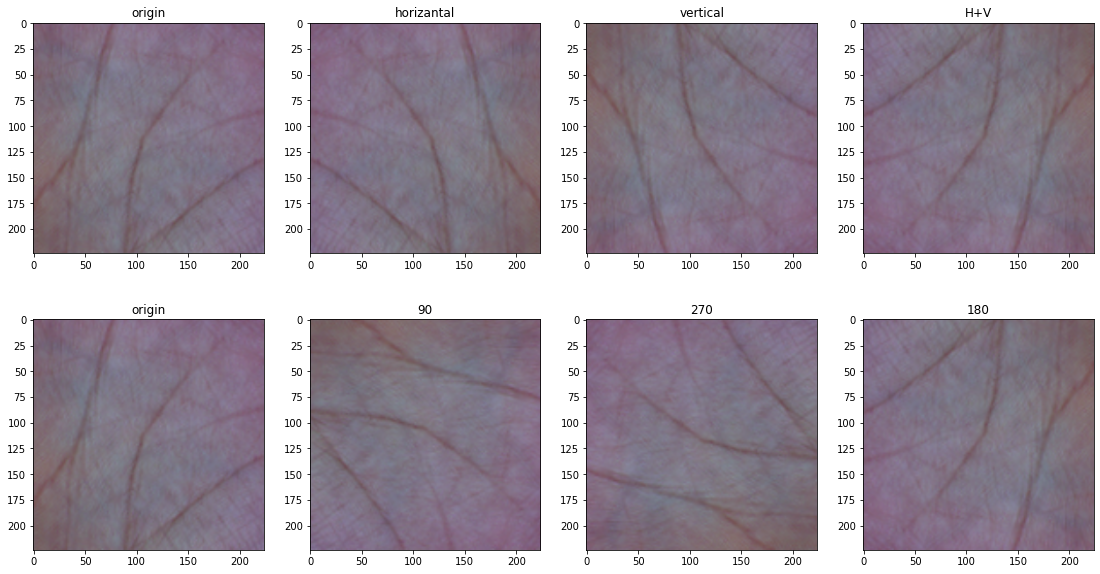

In [570]:
## show training images
%matplotlib inline
fig, axs = plt.subplots(2, 4, figsize=(19, 10))

image = validationDataset_source[0][0]
images = [image]
images.append(torch.flip(image, (-1,))) # horizantal
images.append(torch.flip(image, (-2,))) # vertical
images.append(torch.flip(image, (-1,-2))) # h+v = 180 degree
titels = ["origin", "horizantal", "vertical", "H+V"]
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0).numpy())
    axs[0][i].set_title(titels[i])

image = validationDataset_source[0][0]
images = [image]
images.append(torch.rot90(image, 1, (-1,-2))) # 90 degree
images.append(torch.rot90(image, 3, (-1,-2))) # 270 degree
images.append(torch.rot90(image, 2, (-1,-2))) # 180 degree
titels = ["origin", "90", "270", "180"]
for i, img in enumerate(images):
    axs[1][i].imshow(img.permute(1, 2, 0).numpy())
    axs[1][i].set_title(titels[i])

# plt.savefig("enhancement.png")
plt.show()
plt.close()

In [690]:
## load model
checkpoint = torch.load("model/PolyU-optuna-third-rotation-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
criterion = checkpoint['criterion']
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimzer4center.load_state_dict(checkpoint['optimzer4center_state_dict'])
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']

# checkpoint = torch.load("model/MPD_h-cross-PolyU-5s-ResNeSt26d_pretrained-128emb-CLMCL-0.1l-0.001lr-0.9mm-50e-ELR.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# criterion.load_state_dict(checkpoint['criterion_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimzer4center.load_state_dict(checkpoint['optimzer4center_state_dict'])
# epoch = checkpoint['epoch']
# training_class_indices = checkpoint['training_class_indices']
# testing_class_indices = checkpoint['testing_class_indices']
# training_class_indices = checkpoint['training_class_indices_source']
# testing_class_indices = checkpoint['testing_class_indices_source']

# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
# optimzer4center = torch.optim.SGD(criterion.parameters(), lr=5e-4)

# model = model.cuda()
# head = head.cuda()
# # featureMapping = featureMapping.cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
# optimizer4center = torch.optim.Adam(head.parameters(), lr=0.1, weight_decay=l2)
# # optimizer4mapping = torch.optim.Adam(featureMapping.parameters(), lr=0.1, weight_decay=l2)

In [64]:
val_ratio = 0
(trainingDataset_source, 
 validationDataset_source, 
 galleryDataset_source, 
 probeDataset_source, 
 training_class_indices_source, 
 testing_class_indices_source) = buildDatasets(
    dataset, shot, val_ratio, test_ratio, (training_class_indices, testing_class_indices))
trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
    trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
print("------ source dataset parameters ------")
print("training classes: ", len(training_class_indices_source))
print("testing classes: ", len(testing_class_indices_source))
print("training samples: ", len(trainingDataset_source))
print("validation samples: ", len(validationDataset_source))
print("gallery samples: ", len(galleryDataset_source))
print("probe samples: ", len(probeDataset_source))

------ source dataset parameters ------
training classes:  450
testing classes:  50
training samples:  5400
validation samples:  5400
gallery samples:  250
probe samples:  350


In [691]:
## target dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m","PolyU_JPG","Tongji_JPG"]
dataset_target = dataset_choices[2]
val_ratio = 0
test_ratio = 0
shot = 5
num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]

print("------ dataset parameters ------")
print("dataset: ", dataset_target)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_target, 
validationDataset_target, 
galleryDataset_target, 
probeDataset_target, 
training_class_indices_target, 
testing_class_indices_target) = buildDatasets(dataset_target, shot, val_ratio, test_ratio)
trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
    trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)
print("------ target dataset parameters ------")
print("training classes: ", len(training_class_indices_target))
print("testing classes: ", len(testing_class_indices_target))
print("training samples: ", len(trainingDataset_target))
print("validation samples: ", len(validationDataset_target))
print("gallery samples: ", len(galleryDataset_target))
print("probe samples: ", len(probeDataset_target))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  MPD_h
val ratio:  0
test ratio:  0
number of shots:  5
------ target dataset parameters ------
training classes:  200
testing classes:  200
training samples:  8000
validation samples:  8000
gallery samples:  2000
probe samples:  6000
------ end dataset parameters ------


In [286]:
# calculate target test acc with mirror
model= model.cuda()
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        # inputs_mirror = torch.fliplr(img).cuda()
        inputs_mirror = torch.flip(img, (-2,)).cuda()
        feats_mirror = model(inputs_mirror)
        # feats =  feats_mirror
        feats = torch.cat([feats, feats_mirror], 1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    
    # calculate centers of each class
    # labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
    # unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    # centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
    # counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
    # counts[unique_labels[:,0]] = labels_count
    # centers = centers / counts.unsqueeze(1) # divide by label counts

    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.flip(img, (-2,)).cuda()
        feats_mirror = model(inputs_mirror)
        # feats =  feats_mirror
        feats = torch.cat([feats, feats_mirror], 1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
   
    # centers = centers.cuda()
    # probe_label_loader = probe_label_loader.cuda()
    # logits = head.classify(probe_feature_loader, centers)     
    # cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
    # center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
    # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
    # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

# gallery_feature_loader = gallery_feature_loader.view(-1, shot, feature_dim*2).sum(dim=1)
# gallery_label_loader = gallery_label_loader.view(-1, shot)[:,0]

match_scores = torch.Tensor()
mathces = torch.Tensor()
probe_label_loader = probe_label_loader.cpu()
cos = nn.CosineSimilarity()
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    test_pred = torch.max(cosine, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    # fail += gallery_label_loader[test_pred] != probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
        # fail_loader.append([test_pred, i, cosine])
        
    
    # open-set verification: match scores for every gallery entry to every probe input
    match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    mathces = torch.cat([mathces, (probe_label_loader[i] == gallery_label_loader)], 0)
    
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print(len(fail_loader))

# cosine_loss, center_loss, cosine_loss + center_loss
    

Test Acc: 0.916833
499


In [650]:
# chap5.4
model= model.cuda()

# get sample
gallery_image = galleryDataset_target[0][0].cuda()
probe_image = probeDataset_target[0][0].cuda()

# registrated
with torch.no_grad():
    model.eval()
    
    
    # start = time.time()
    # single matching
    # feats_gallery = model(gallery_image.unsqueeze(0))
    # end = time.time()-start
    # print("duration: {}".format(end))
    
    # mirror
    # gallery_image_mirror = [gallery_image, torch.flip(gallery_image, (-2,))]
    # gallery_image_mirror = torch.stack(gallery_image_mirror, dim=0)
    # feats_gallery = model(gallery_image_mirror).flatten()
    
    # multi
    images = []
    images.append(gallery_image) # original
    images.append(torch.flip(gallery_image, (-1,))) # horizantal
    images.append(torch.flip(gallery_image, (-2,))) # vertical
    images.append(torch.flip(gallery_image, (-1,-2))) # h+v = 180 degree
    images.append(torch.rot90(gallery_image, 1, (-1,-2))) # 90 degree
    images.append(torch.rot90(gallery_image, 3, (-1,-2))) # 270 degree
    images = torch.stack(images, dim=0)
    feats_gallery = model(images)

    # start counting
    start = time.time()

    # single matching
    feats_probe = model(probe_image.unsqueeze(0))
    # print("duration: {}".format(time.time()-start))
    # mirror                            
    # probe_image_mirror = [gallery_image, torch.flip(gallery_image, (-2,))]
    # probe_image_mirror = torch.stack(probe_image_mirror, dim=0)
    # feats_probe = model(probe_image_mirror).flatten()
    
    # multi
    images = []
    images.append(probe_image) # original
    images.append(torch.flip(probe_image, (-1,))) # horizantal
    images.append(torch.flip(probe_image, (-2,))) # vertical
    images.append(torch.flip(probe_image, (-1,-2))) # h+v = 180 degree
    images.append(torch.rot90(probe_image, 1, (-1,-2))) # 90 degree
    images.append(torch.rot90(probe_image, 3, (-1,-2))) # 270 degree
    images = torch.stack(images, dim=0)
    feats_probe = model(images)
    
    # similarity
    # cosine = cos(feats_probe, feats_gallery)
    # multi
    cosine = cos(feats_probe, feats_gallery).mean()
    

    # end counting
    end = time.time()-start
    print("duration: {}".format(end))
    
    print(cosine)

duration: 0.019559860229492188
tensor(0.8856, device='cuda:0')


In [702]:
# calculate test acc with mirrors
model= model.cuda()
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        images = []
        images.append(img.cuda()) # original
        images.append(torch.flip(img, (-1,)).cuda()) # horizantal
        images.append(torch.flip(img, (-2,)).cuda()) # vertical
        # images.append(torch.flip(img, (-1,-2)).cuda()) # h+v = 180 degree
        images.append(torch.rot90(img, 1, (-1,-2)).cuda()) # 90 degree
        images.append(torch.rot90(img, 3, (-1,-2)).cuda()) # 270 degree

        feats = []
        for image in images:
            feats.append(model(image))
        feats = torch.stack(feats, dim=1)
        
        # check norm
        # feat_norms = feats.norm(dim=-1).cpu()
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1), (feat_norms[:,1:] > norm_max)], 1)
        # feats[outlier_indexes] = 0
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] < norm_min)], 1)
        # feats[outlier_indexes] = 0
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_target):
        images = []
        images.append(img.cuda()) # original
        images.append(torch.flip(img, (-1,)).cuda()) # horizantal
        images.append(torch.flip(img, (-2,)).cuda()) # vertical
        # images.append(torch.flip(img, (-1,-2)).cuda()) # h+v = 180 degree
        images.append(torch.rot90(img, 1, (-1,-2)).cuda()) # 90 degree
        images.append(torch.rot90(img, 3, (-1,-2)).cuda()) # 270 degree

        feats = []
        for image in images:
            feats.append(model(image))
        feats = torch.stack(feats, dim=1)
        
        # check norm
        # feat_norms = feats.norm(dim=-1).cpu()
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1), (feat_norms[:,1:] > norm_max)], 1)
        # feats[outlier_indexes] = 0
        # outlier_indexes = torch.cat([torch.zeros(feat_norms.size(0), dtype=torch.bool).unsqueeze(1).cuda(), (feat_norms[:,1:] < norm_min)], 1)
        # feats[outlier_indexes] = 0
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

match_scores = torch.Tensor()
mathces = torch.Tensor()
cos = nn.CosineSimilarity(dim=-1)
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    
    # cosine_mirrors = cosine[:, 1:]
    # counts = (cosine_mirrors!=0).sum(1)
    # counts[counts < 1] = 1
    # cosine_mirrors /= counts.unsqueeze(1)
    # similarity_mean = cosine.sum(dim=-1) / 2
    
    similarity_mean = cosine.sum(dim=-1) / (cosine!=0).sum(1)
    
    test_pred = torch.max(similarity_mean, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].cpu(), cosine[true_indexes].cpu()])
        
    # open-set verification: match scores for every gallery entry to every probe input
    # match_scores = torch.cat([match_scores, similarity_mean.cpu()], 0)
    # mathces = torch.cat([mathces, (probe_label_loader[i] == gallery_label_loader)], 0)
    
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print("Number of disabled gallery mirror template: %d" % ((gallery_feature_loader.norm(dim=-1) == 0).sum()))
print("Number of disabled probe mirror template: %d" % ((probe_feature_loader.norm(dim=-1) == 0).sum()))
print("Number of failed: %d" % (len(fail_loader)))

Test Acc: 0.940667
Number of disabled gallery mirror template: 0
Number of disabled probe mirror template: 0
Number of failed: 356


In [472]:
print(fail_loader[1])
print(gallery_label_loader[fail_loader[0][0]], probe_label_loader[fail_loader[0][1]])
# print(fail_loader[0][2][598], fail_loader[0][2][0*5:2*5])

[tensor(406, device='cuda:0'), 22, tensor(0.6359, device='cuda:0'), tensor([0.5847, 0.6338, 0.6024, 0.6092, 0.6068], device='cuda:0')]
tensor(169.) tensor(1.)


In [629]:
class LRP():
    """
        Layer-wise relevance propagation with gamma+epsilon rule
        This code is largely based on the code shared in: https://git.tu-berlin.de/gmontavon/lrp-tutorial
        Some stuff is removed, some stuff is cleaned, and some stuff is re-organized compared to that repository.
    """
    def __init__(self, model):
        self.model = model

    def LRP_forward(self, layer, input_tensor, gamma=None, epsilon=None):
        # This implementation uses both gamma and epsilon rule for all layers
        # The original paper argues that it might be beneficial to sometimes use
        # or not use gamma/epsilon rule depending on the layer location
        # Have a look a the paper and adjust the code according to your needs

        # LRP-Gamma rule
        if gamma is None:
            gamma = lambda value: value + 0.05 * copy.deepcopy(value.data.detach()).clamp(min=0)
        # LRP-Epsilon rule
        if epsilon is None:
            eps = 1e-9
            epsilon = lambda value: value + eps

        # Copy the layer to prevent breaking the graph
        layer = copy.deepcopy(layer)

        # Modify weight and bias with the gamma rule
        try:
            layer.weight = nn.Parameter(gamma(layer.weight))
        except AttributeError:
            pass
            # print('This layer has no weight')
        try:
            layer.bias = nn.Parameter(gamma(layer.bias))
        except AttributeError:
            pass
            # print('This layer has no bias')
        # Forward with gamma + epsilon rule
        return epsilon(layer(input_tensor))

    def LRP_step(self, forward_output, layer, LRP_next_layer):
        # Enable the gradient flow
        forward_output = forward_output.requires_grad_(True)
        # Get LRP forward out based on the LRP rules
        lrp_rule_forward_out = self.LRP_forward(layer, forward_output, None, None)
        # Perform element-wise division
        print(LRP_next_layer.shape, lrp_rule_forward_out.shape)
        ele_div = (LRP_next_layer / lrp_rule_forward_out).data
        # Propagate
        (lrp_rule_forward_out * ele_div).sum().backward()
        # Get the visualization
        LRP_this_layer = (forward_output * forward_output.grad).data

        return LRP_this_layer

    def generate(self, input_image, target_class):
        input_image.requires_grad_(True)
        # layers_in_model = list(self.model._modules['features']) + list(self.model._modules['classifier'])
        layers_in_model = list(self.model._modules.values())
        number_of_layers = len(layers_in_model)
        # Needed to know where flattening happens
        features_to_classifier_loc = len(layers_in_model)-1
        # features_to_classifier_loc = -2

        # Forward outputs start with the input image
        forward_output = [input_image]
        # Then we do forward pass with each layer
        # for conv_layer in list(self.model._modules['features']):
        for conv_layer in layers_in_model:
            forward_output.append(conv_layer.forward(forward_output[-1].detach()))

        # To know the change in the dimensions between features and classifier
        feature_to_class_shape = forward_output[-3].shape
        # # Flatten so we can continue doing forward passes at classifier layers
        # forward_output[-1] = torch.flatten(forward_output[-1], 1)
        # for index, classifier_layer in enumerate(list(self.model._modules['classifier'])):
        #     forward_output.append(classifier_layer.forward(forward_output[-1].detach()))

        # Target for backprop
        target_class_one_hot = torch.FloatTensor(1, 128).zero_()
        target_class_one_hot[0][target_class] = 1

        # This is where we accumulate the LRP results
        LRP_per_layer = [None] * number_of_layers + [(forward_output[-1] * target_class_one_hot).data]

        for layer_index in range(1, number_of_layers)[::-1]:
            # This is where features to classifier change happens
            # Have to flatten the lrp of the next layer to match the dimensions
            if layer_index == features_to_classifier_loc-1:
                LRP_per_layer[layer_index+1] = LRP_per_layer[layer_index+1].reshape(feature_to_class_shape)

            if isinstance(layers_in_model[layer_index], (torch.nn.Linear, torch.nn.Conv2d, torch.nn.MaxPool2d, torch.nn.Sequential)):
                # In the paper implementation, they replace maxpool with avgpool because of certain properties
                # I didn't want to modify the model like the original implementation but
                # feel free to modify this part according to your need(s)
                lrp_this_layer = self.LRP_step(forward_output[layer_index], layers_in_model[layer_index], LRP_per_layer[layer_index+1])
                LRP_per_layer[layer_index] = lrp_this_layer
            else:
                LRP_per_layer[layer_index] = LRP_per_layer[layer_index+1]
        return 

In [405]:
layer_name_in_model = list(model._modules.keys())
layers_in_model = list(model._modules.values())
number_of_layers = len(layers_in_model)
# Needed to know where flattening happens
features_to_classifier_loc = -2
forward_output = [images.cuda()]
# Then we do forward pass with each layer
# for conv_layer in list(self.model._modules['features']):
for i, conv_layer in enumerate(layers_in_model):
    forward_output.append(conv_layer.forward(forward_output[-1].detach()))
    print(layer_name_in_model[i], forward_output[-1].shape)

conv1 torch.Size([4, 64, 112, 112])
bn1 torch.Size([4, 64, 112, 112])
act1 torch.Size([4, 64, 112, 112])
maxpool torch.Size([4, 64, 56, 56])
layer1 torch.Size([4, 256, 56, 56])
layer2 torch.Size([4, 512, 28, 28])
layer3 torch.Size([4, 1024, 14, 14])
layer4 torch.Size([4, 1024, 14, 14])
global_pool torch.Size([4, 1024])
fc torch.Size([4, 128])


In [630]:
import copy
from misc_functions import apply_heatmap

target_example = 0  # Snake

i, (images, labels) = next(enumerate(trainingDataloader_source))
original_image = images[0]
prep_img = images[0].unsqueeze(0)
target_class = 0
file_name_to_export = "test"
pretrained_model = model.cpu()


# LRP
layerwise_relevance = LRP(pretrained_model)

# Generate visualization(s)
LRP_per_layer = layerwise_relevance.generate(prep_img, target_class)

# Convert the output nicely, selecting the first layer
lrp_to_vis = np.array(LRP_per_layer[1][0]).sum(axis=0)
lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((prep_img.shape[2],
                      prep_img.shape[3]), Image.ANTIALIAS))

# Apply heatmap and save
heatmap = apply_heatmap(lrp_to_vis, 4, 4)
heatmap.figure.savefig('LRP_out.png')

torch.Size([1, 128]) torch.Size([1, 128])


/home/r08942088/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


RuntimeError: shape '[1, 2048, 7, 7]' is invalid for input of size 2048

In [ ]:
model

In [79]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
    # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
    # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
    model.eval()
    model = model.cuda()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
    
    layers = [
        model.conv1[0],
        model.conv1[3],
        model.conv1[6],
        model.layer1[0].conv1,
        model.layer1[0].conv3,
        model.layer1[1].conv1,
        model.layer1[1].conv3,
        model.layer2[0].conv1,
        model.layer2[0].conv3,
        model.layer2[1].conv1,
        model.layer2[1].conv3,
        model.layer3[0].conv1,
        model.layer3[0].conv3,
        model.layer3[1].conv1,
        model.layer3[1].conv3,
        model.layer4[0].conv1,
        model.layer4[0].conv3,
        model.layer4[1].conv1,
        model.layer4[1].conv3,
    ]
    filter_activations = [x[:,2]]
    filter_visualization = None
    for l in layers:
        hook_handle = l.register_forward_hook(hook)
        # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
        # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
        # 也有某層 cnn 的 activation map
        # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
        # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

        # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
        model(x.cuda())
        # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
        filter_activations.append(layer_activations[:, filterid, :, :].detach().cpu())
        hook_handle.remove()
        # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
        # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
        # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

    return filter_activations, filter_visualization

# i, (images, labels) = next(enumerate(galleryDataloader_target))
# images = images[8:12]
# images = probeDataset_target[160][0].unsqueeze(0)

probeImage_0 = probeDataset_target[21]
predictedGalleryImage_0 = galleryDataset_target[841]
probeImage_1 = probeDataset_target[22]
predictedGalleryImage_1 = galleryDataset_target[406]
images = torch.stack([probeImage_0[0], predictedGalleryImage_0[0], probeImage_1[0], predictedGalleryImage_1[0]])

filter_activations, filter_visualization = filter_explaination(images, model, cnnid=5, filterid=16, iteration=100, lr=0.1)
# filter_activations, filter_visualization = filter_explaination(images, model, cnnid=6, filterid=range(64), iteration=100, lr=0.1)
# filter_explaination(images, model, cnnid=6, filterid=3, iteration=100, lr=0.1)

# 畫出 filter visualization
# b,g,r = filter_visualization.split(3)[0]
# rgb_img = torch.stack([r,g,b])
# plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
# plt.savefig("reportP2_cnn6_filter5.png")
# plt.show()
# plt.close()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
# probe_activations.append(normalize(filter_activations[0]))
# gallery_activations.append(normalize(filter_activations[1]))

# fig, axs = plt.subplots(2, 4, figsize=(15, 8))
# for i, img in enumerate(images):
#     axs[0][i].imshow(img.permute(1, 2, 0))
# for i, img in enumerate(filter_activations):
#     axs[1][i].imshow(normalize(img), cmap='gray')
# # plt.savefig("gradient_ascent.png")
# plt.show()
# plt.close()
# # 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界
len(filter_activations)

20

In [ ]:
import torchvision
from torchvision.utils import make_grid
plt.style.use('default')
grid = make_grid(normalize(filter_activations[0]), nrow=8)
print("size of grid:", grid.size())
img = torchvision.transforms.ToPILImage()(grid)
# img.save("images/polyu_reduced_resnest26_mpdh_gallery_activations.png")
img.show()

In [80]:
resize = transforms.Resize((112,112))
resized_filter_activations = [resize(f) for f in filter_activations]
aligned_filter_activations = torch.stack(resized_filter_activations, dim=0).permute(1,0,2,3)
aligned_filter_activations.size()

torch.Size([4, 20, 112, 112])

In [ ]:
probe_activations = [probeImage_0[0][2]]
gallery_activations = [predictedGalleryImage_0[0][2]]

In [ ]:
resize = transforms.Resize((112,112))
resized_probe_activations = [resize(p.unsqueeze(0)) for p in probe_activations]
resized_gallery_activations = [resize(g.unsqueeze(0)) for g in gallery_activations]

In [81]:
import torchvision
from torchvision.utils import make_grid
plt.style.use('default')

# # normalized_probe_activations = [normalize(img.transpose(0,1)) for img in probe_activations]
# grid = make_grid(resized_probe_activations, nrow=5)
# print("size of grid:", grid.size())
# img = torchvision.transforms.ToPILImage()(grid)
# # img.save("images/polyu_reduced_resnest26_mpdh_probe_activations.png")
# img.show()
# # img.close()

# # normalized_gallery_activations = [normalize(img.transpose(0,1)) for img in gallery_activations]
# grid = make_grid(resized_gallery_activations, nrow=5)
# print("size of grid:", grid.size())
# img = torchvision.transforms.ToPILImage()(grid)
# # img.save("images/polyu_reduced_resnest26_mpdh_gallery_activations.png")
# img.show()

normalized_filter_activations = [normalize(img).unsqueeze(0) for img in aligned_filter_activations[0]]
grid = make_grid(normalized_filter_activations, nrow=5)
print("size of grid:", grid.size())
img = torchvision.transforms.ToPILImage()(grid)
# img.save("images/polyu_reduced_resnest26_mpdh_gallery_activations.png")
img.show()

size of grid: torch.Size([3, 458, 572])


In [ ]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

x = torch.randn(1,3,224,224)
# 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
x.requires_grad_()
# 我們要對 input image 算偏微分
optimizer = torch.optim.Adam([x], lr=0.1)
# 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
model = model.cuda()
head = head.cuda()
for i in range(100):
    optimizer.zero_grad()
    feats = model(x.cuda())
    # logits = head.classify(feats)
    
    # 最大化的類別
    one_hot_output = torch.FloatTensor(x.size(0), feats.size()[-1]).zero_().cuda()
    one_hot_output[0][1] = 1
    feats.backward(gradient=one_hot_output)
    
    # 計算 filter activation 對 input image 的偏微分
    optimizer.step()

# 畫出 filter visualization
# b,g,r = filter_visualization.split(3)[0]
# rgb_img = torch.stack([r,g,b])
activated_img = x.detach().cpu().squeeze(0)
plt.imshow(normalize(activated_img.permute(1, 2, 0)))
# plt.savefig("reportP2_cnn6_filter5.png")
plt.show()
plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

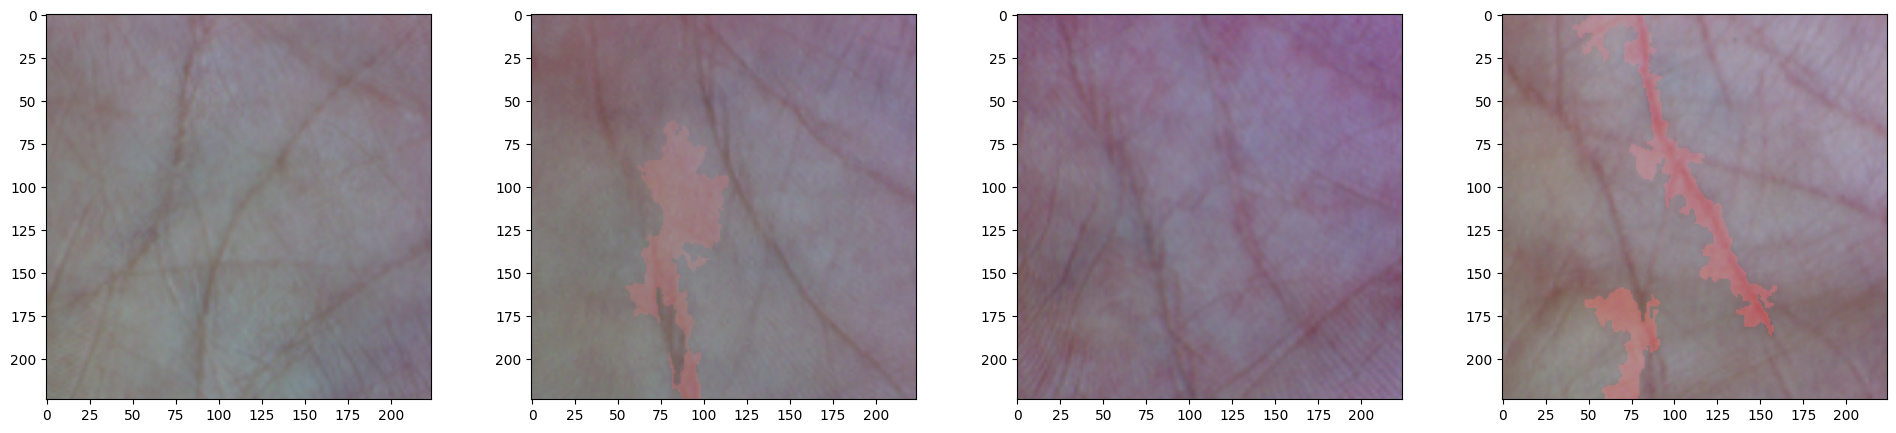

In [46]:
from skimage.segmentation import slic
from lime import lime_image

def predict(input_image):
    # input: numpy array, (batches, height, width, channels)         
    model.eval()
    # model = model.cuda()
    input_image = torch.FloatTensor(input_image.reshape(-1,3,224,224)).cuda()
    feats = model(input_image)
    # logits = criterion.classify(feats)
    # logits, loss = self.criterion(feats, target_class)
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)
    return feats.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input_image):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
    return slic(input_image, n_segments=100, compactness=1, sigma=1)                                                                                                              
    

i, (images, labels) = next(enumerate(validationDataloader_source))
images = images[12:16]
# labels = labels[12:16]
labels = torch.Tensor([3,3,3,3])

# img_indices = [1552, 1354, 9233, 9443]
# images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(24, 5))     
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)): 
    # image = image.cuda()
    label = label.unsqueeze(0).cuda()
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array
    
    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation, top_labels=500)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=500,                                                                                                                              
                                min_weight=0.05
                            )
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    # axs[idx].set_title(category_map[pred[idx]])
    # b,g,r = np.split(lime_img,3,axis=2)
    # rgb_img = np.concatenate([r,g,b],axis=2)
    axs[idx].imshow(lime_img)

# plt.savefig("lime.png")
plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。

In [362]:
from torch.nn import ReLU
    
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
            for i in grad_in:
                if torch.is_tensor(i):
                    print(i.shape)
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        input_image.requires_grad_(True)
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
    
class GuidedBackprop_resnest():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, head):
        self.model = model
        self.head = head
        self.gradients = None
        self.forward_relu_outputs = []
        self.hooks = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        self.hooks.append(self.model.conv1[0].register_backward_hook(hook_function))
        # first_layer = list(self.model.children())[0]
        # first_layer.register_backward_hook(hook_function)
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)
            
        # Loop through layers, hook up ReLUs with relu_hook_function
        for module in self.model.modules():
            if isinstance(module, ReLU):
                self.hooks.append(module.register_backward_hook(relu_backward_hook_function))
                self.hooks.append(module.register_forward_hook(relu_forward_hook_function))

    def generate_gradients(self, input_image, target_class):
        input_image.requires_grad_(True)
        # Forward pass
        # model_output = self.model(input_image)
        feats = self.model(input_image)
        margin_output, logits = self.head(feats, target_class)
        # logits, loss = self.criterion(feats, target_class)
        
        # # Zero gradients
        self.model.zero_grad()
        self.head.zero_grad()
        # # Target for backprop
        one_hot_output = torch.FloatTensor(1, logits.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # one_hot_output = torch.FloatTensor(1, feats.size()[-1]).zero_().cuda()
        # one_hot_output[0][3] = 1
        # # Backward pass
        margin_output.backward(gradient=one_hot_output)
        # logits.backward(gradient=one_hot_output)
        # feats.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        self.remove_hooks()
        return gradients_as_arr

In [356]:
#  show hooks
GBP.remove_hooks()
[m._forward_hooks for m in model.conv1.modules()]

[OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict(),
 OrderedDict()]

/home/r08942088/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided backprop completed


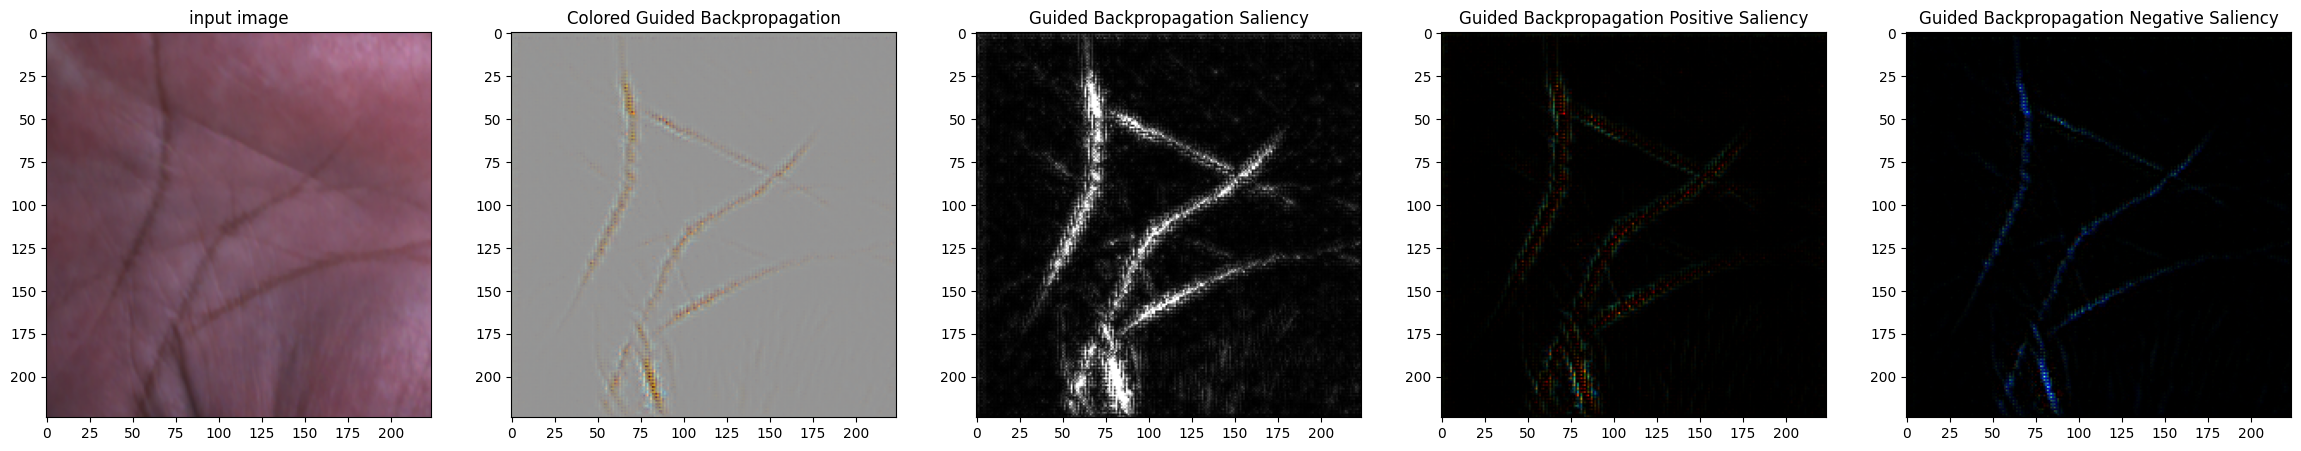

In [439]:
from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)

# target_example = 0  # Snake
# (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
#     get_example_params(target_example)

i, (images, labels) = next(enumerate(validationDataloader_target))
idx = 11
original_image = images[idx]
prep_img = images[idx].unsqueeze(0).cuda()
target_class = labels[idx].unsqueeze(0).cuda()
file_name_to_export = "test"
pretrained_model = model

# Guided backprop
# GBP = GuidedBackprop(pretrained_model)
GBP = GuidedBackprop_resnest(pretrained_model.cuda(), head.cuda())
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
gradient_image = save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
gradient_image_positive = save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
gradient_image_negative = save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

%matplotlib inline
plt.style.use('default')
fig, axs = plt.subplots(1, 5, figsize=(29, 5))
axs[0].set_title("input image")
axs[0].imshow(original_image.permute(1, 2, 0).numpy())
axs[1].set_title("Colored Guided Backpropagation")
axs[1].imshow(gradient_image.transpose(1, 2, 0))
axs[2].set_title("Guided Backpropagation Saliency")
axs[2].imshow(grayscale_guided_grads.transpose(1, 2, 0), cmap='gray')
axs[3].set_title("Guided Backpropagation Positive Saliency")
axs[3].imshow(gradient_image_positive.transpose(1, 2, 0))
axs[4].set_title("Guided Backpropagation Negative Saliency")
axs[4].imshow(gradient_image_negative.transpose(1, 2, 0))
plt.show()

In [220]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model, criterion):
    model.eval()
    criterion.eval()
    x = x.cuda()
    y = y.cuda()
    model = model.cuda()
    criterion = criterion.cuda()

    # 最關鍵的一行 code
    # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
    # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
    x.requires_grad_()

    feats = model(x)
    logits, loss = criterion(feats, y)
    # y_pred = model(x)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss = loss_func(y_pred, y.cuda())
    loss.backward()
    _, train_pred = torch.max(logits, 1)

    saliencies = x.grad.abs().detach().cpu()
    # saliencies: (batches, channels, height, weight)
    # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
    # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
    # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
    # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
    # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies, train_pred.cpu()

/home/r08942088/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


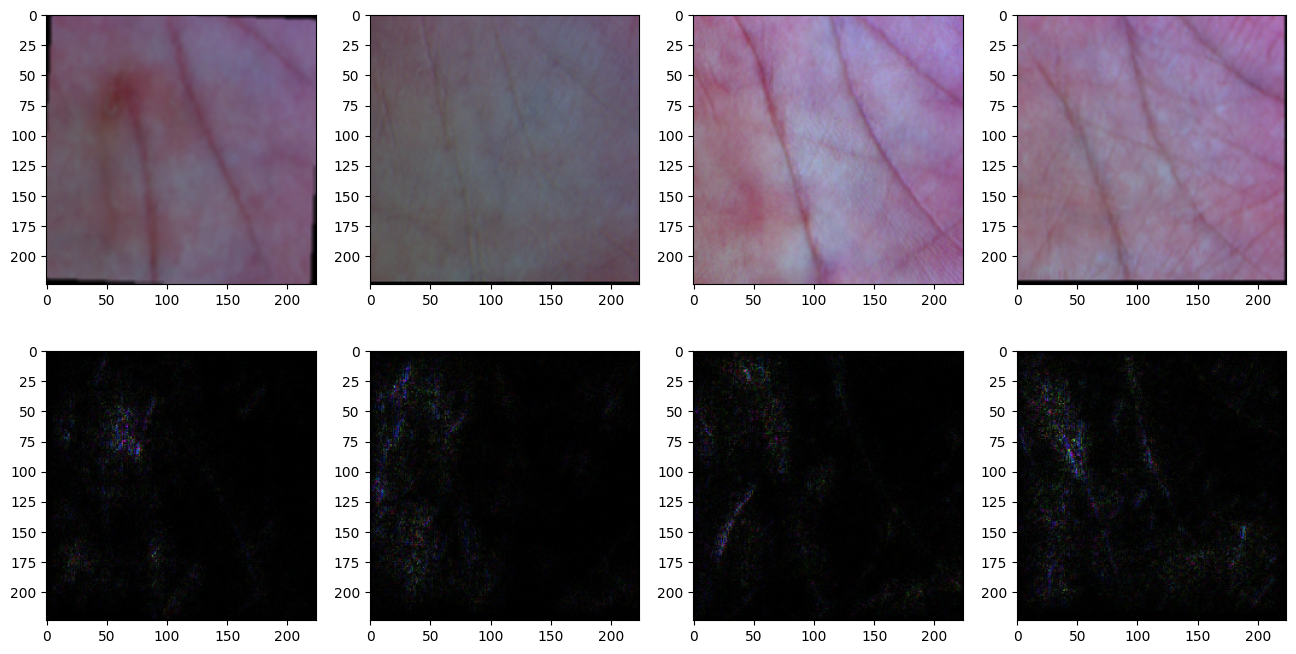

In [224]:
# 指定想要一起 visualize 的圖片 indices
i, (images, labels) = next(enumerate(trainingDataloader_source))
# images, labels = train_set.getbatch(img_indices)
saliencies, y_pred = compute_saliency_maps(images[:4], labels[:4], model, criterion)

# 使用 matplotlib 畫出來
plt.style.use("default")
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for row, target in enumerate([images[:4], saliencies]):
    for column, img in enumerate(target):
        # if row == 0:
        #     axs[row][column].set_title(category_map[labels.tolist()[column]])
        # else:
        #     axs[row][column].set_title(category_map[y_pred.tolist()[column]])
        
        # b,g,r = img.split(3)[0]
        # rgb_img = torch.stack([r,g,b])
        axs[row][column].imshow(img.permute(1, 2, 0).numpy())
        # 小知識：permute 是什麼，為什麼這邊要用?
        # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
        # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
        # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
        # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
        # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
        # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
        # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

# plt.savefig("saliencies.png")
plt.show()
plt.close()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

In [ ]:
## testing

In [19]:
## load model
checkpoint = torch.load("model/PolyU-5s-ResNet20_basic-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
criterion = checkpoint['criterion']
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimzer4center.load_state_dict(checkpoint['optimzer4center_state_dict'])
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']

In [12]:
## target dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m","PolyU_JPG","Tongji_JPG"]
dataset_target = dataset_choices[2]
val_ratio = 0
test_ratio = 0.5
shot = 5
num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]

print("------ dataset parameters ------")
print("dataset: ", dataset_target)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_target, 
validationDataset_target, 
galleryDataset_target, 
probeDataset_target, 
training_class_indices_target, 
testing_class_indices_target) = buildDatasets(dataset_target, shot, val_ratio, test_ratio)
trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
    trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)
print("------ target dataset parameters ------")
print("training classes: ", len(training_class_indices_target))
print("testing classes: ", len(testing_class_indices_target))
print("training samples: ", len(trainingDataset_target))
print("validation samples: ", len(validationDataset_target))
print("gallery samples: ", len(galleryDataset_target))
print("probe samples: ", len(probeDataset_target))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  MPD_h
val ratio:  0
test ratio:  0.5
number of shots:  5
------ target dataset parameters ------
training classes:  100
testing classes:  100
training samples:  4000
validation samples:  4000
gallery samples:  1000
probe samples:  3000
------ end dataset parameters ------


In [ ]:
## get feature embedding concat with mirror image
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.fliplr(img).cuda()
        feats_mirror = model(inputs_mirror)
        # feats = feats_mirror
        feats = torch.cat([feats, feats_mirror], 1)
        
        # inputs_mirror_2 = torch.flip(img, (2,)).cuda()
        # feats_mirror_2 = model(inputs_mirror_2)
        # feats = torch.cat([feats, feats_mirror, feats_mirror_2], 1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.fliplr(img).cuda()
        feats_mirror = model(inputs_mirror)
        # feats = feats_mirror
        feats = torch.cat([feats, feats_mirror], 1)
        
        # inputs_mirror_2 = torch.flip(img, (2,)).cuda()
        # feats_mirror_2 = model(inputs_mirror_2)
        # feats = torch.cat([feats, feats_mirror, feats_mirror_2], 1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

In [20]:
## verification: normal version
model = model.cuda()
model.eval()
# criterion.eval()
test_loss = 0.0
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)    
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

# test_loss = test_loss/(len(galleryDataset) + len(probeDataset))
# print("Test loss: ", test_loss)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

(1000, 1000, 3000, 3000)

In [159]:
## verification: normal version
model = model.cuda()
head = head.cuda()
model.eval()
# criterion.eval()
test_loss = 0.0
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    
    # calculate centers of each class
    labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
    unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
    counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
    counts[unique_labels[:,0]] = labels_count
    centers = centers / counts.unsqueeze(1) # divide by label counts
    
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
   
    centers = centers.cuda()
    probe_label_loader = probe_label_loader.cuda()
    logits = head.classify(probe_feature_loader, centers)     
    cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
    # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
    center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
    # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

# test_loss = test_loss/(len(galleryDataset) + len(probeDataset))
# print("Test loss: ", test_loss)
print("Cosine loss: ", cosine_loss)
print("Center loss: ", center_loss)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

Cosine loss:  0.9003767371177673
Center loss:  0.050689983367919925


(2000, 2000, 6000, 6000)

In [61]:
labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
counts[unique_labels[:,0]] = labels_count
centers = centers / counts.unsqueeze(1) # divide by label counts

In [473]:
gallery_feature_loader_total = gallery_feature_loader
gallery_label_loader_total = gallery_label_loader
probe_feature_loader_total = probe_feature_loader
probe_label_loader_total = probe_label_loader

In [290]:
gallery_feature_loader = gallery_feature_loader_total[2500:5500]
gallery_label_loader = gallery_label_loader_total[2500:5500]
probe_feature_loader = probe_feature_loader_total[3500:12500]
probe_label_loader = probe_label_loader_total[3500:12500]

In [472]:
gallery_label_loader[2500:] += 500
gallery_label_loader[5500:] += 600
# gallery_label_loader[7500:] += 400

probe_label_loader[3500:] += 500
probe_label_loader[12500:] += 600
# probe_label_loader[18500:] += 400

gallery_label_loader, probe_label_loader

(tensor([   0,    0,    0,  ..., 1499, 1498, 1499]),
 tensor([   0,    0,    0,  ..., 1499, 1498, 1499]))

In [24]:
from umap import UMAP

# source_embedded = UMAP(n_components=3, n_neighbors=25, min_dist=0.2).fit_transform(gallery_feature_loader.view(-1,128).cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(gallery_feature_loader_total.cpu())
source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(gallery_feature_loader.cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=10, min_dist=0.1).fit_transform(feature_loader.cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(torch.cat([gallery_feature_loader, probe_feature_loader], 0).cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=10, min_dist=0.5).fit_transform(torch.cat([gallery_feature_loader_total, probe_feature_loader_total], 0).cpu())


In [98]:
from sklearn.manifold import TSNE
source_embedded = TSNE(n_components=3).fit_transform(torch.cat([gallery_feature_loader, probe_feature_loader], 0).cpu())
# source_embedded = TSNE(n_components=3).fit_transform(feature_loader.cpu())
# source_embedded = TSNE(n_components=3, perplexity=30).fit_transform(gallery_feature_loader.cpu())
# source_embedded = TSNE(n_components=3).fit_transform(gallery_feature_loader.view(-1,128).cpu())
# source_embedded = TSNE(n_components=3).fit_transform(head.weight[training_class_indices_source].cpu().detach().numpy())


/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [217]:
source_embedded_polyu = source_embedded[:2500]
source_embedded_tongji = source_embedded[2500:5500]
source_embedded_mpdh = source_embedded[5500:7500]
source_embedded_mpdm = source_embedded[7500:9500]

In [25]:
# source_embedded_3d_polyu = source_embedded[:2500]
# source_embedded_3d_tongji = source_embedded[2500:5500]
# source_embedded_3d_mpdh = source_embedded[5500:7500]
# source_embedded_3d_mpdm = source_embedded[7500:9500]

source_embedded_3d = source_embedded

# source_embedded_3d_polyu = source_embedded[:2500]
# source_embedded_3d_mpdh = source_embedded[2500:4500]

/tmp/ipykernel_8825/2235274609.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


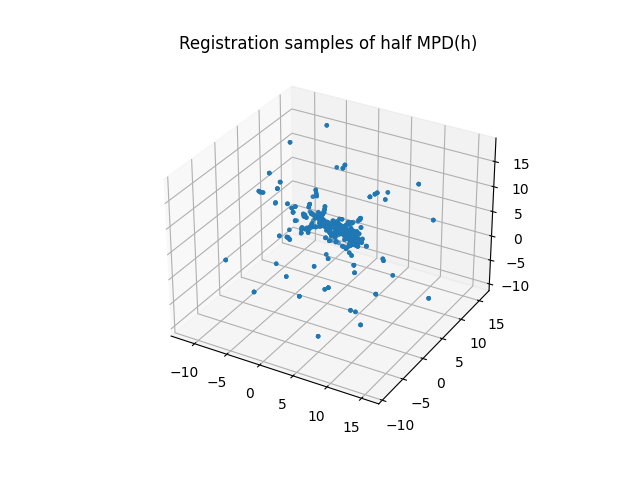

In [26]:
# chap5.2
%matplotlib widget
plt.style.use('default')
# plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.gca(projection='3d')

# ax.scatter(source_embedded_3d[1000:, 0], source_embedded_3d[1000:, 1], source_embedded_3d[1000:, 2], marker='.')
ax.scatter(source_embedded_3d[:1000, 0], source_embedded_3d[:1000, 1], source_embedded_3d[:1000, 2], marker='.')

ax.set_title("Registration samples of half MPD(h)")
# ax.legend(["registration sample"])
# ax.view_init(-166, -120)

# plt.scatter(source_embedded[:1000, 0], source_embedded[:1000, 1], marker='.')
# plt.title("Registration samples of half MPD(h)")
# plt.legend(["registration sample"])

plt.savefig("images/resnet20-mpdh-gallery-3d.pdf")
# plt.savefig("images/reduced-resnest50-mpdh-gallery-3d.pdf")
plt.show()

/tmp/ipykernel_395084/3420367063.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


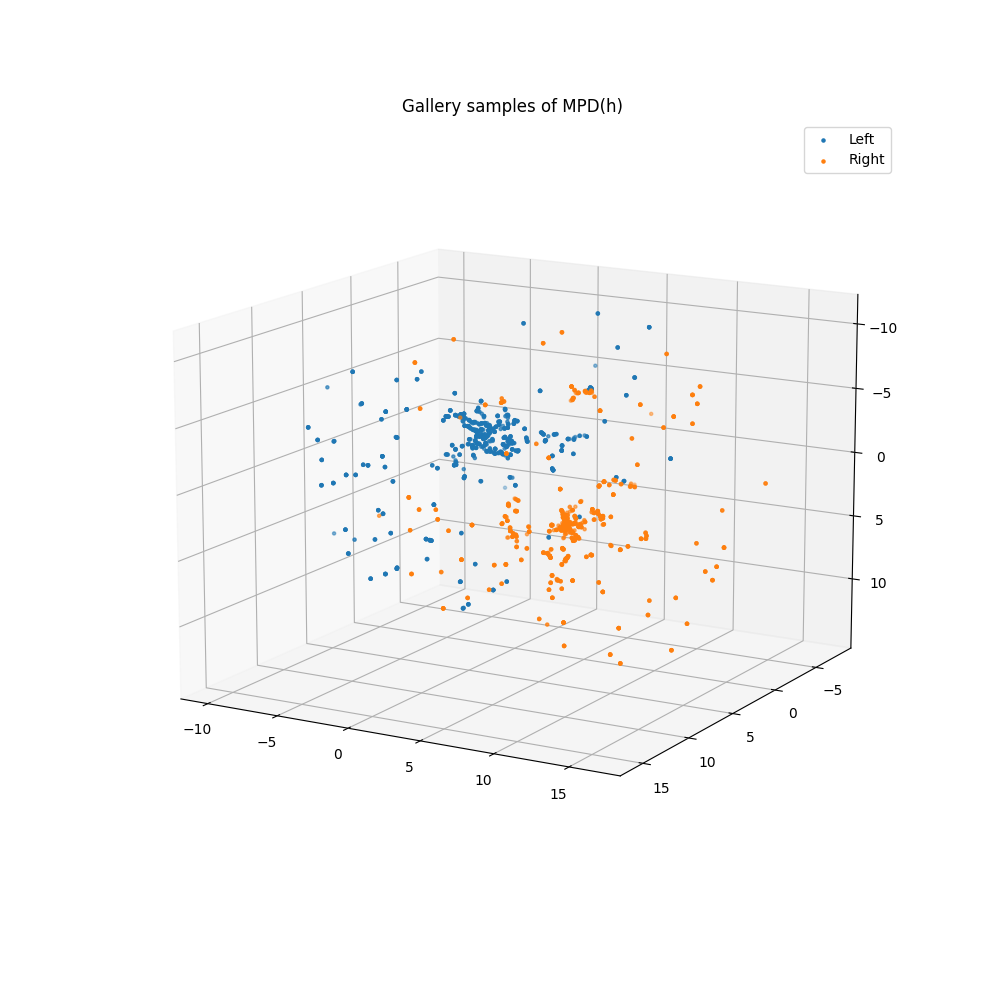

In [565]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# mpd
# for i in range(400):
#     a = int(i/2)
#     b = i%2
#     start = a*10+b
#     end = a*10+b+10
#     ax.scatter(source_embedded_3d_tongji[start:end:2, 0], source_embedded_3d_tongji[start:end:2, 1], source_embedded_3d_tongji[start:end:2, 2], marker='.')
# left and right
ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.')
ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.')

# tongji
# for i in range(600):
#     start = i*5
#     end = start+5
#     ax.scatter(source_embedded_3d_tongji[start:end, 0], source_embedded_3d_tongji[start:end, 1], source_embedded_3d_tongji[start:end, 2], marker='.')
ax.legend(["Left", "Right"])
ax.set_title("Gallery samples of MPD(h)")
ax.view_init(-166, -120)
# plt.savefig("images/polyu-baseline-mpdh-gallery.png")

plt.show()

In [83]:
source_embedded_3d.shape

(12000, 3)

/tmp/ipykernel_413986/3733805809.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


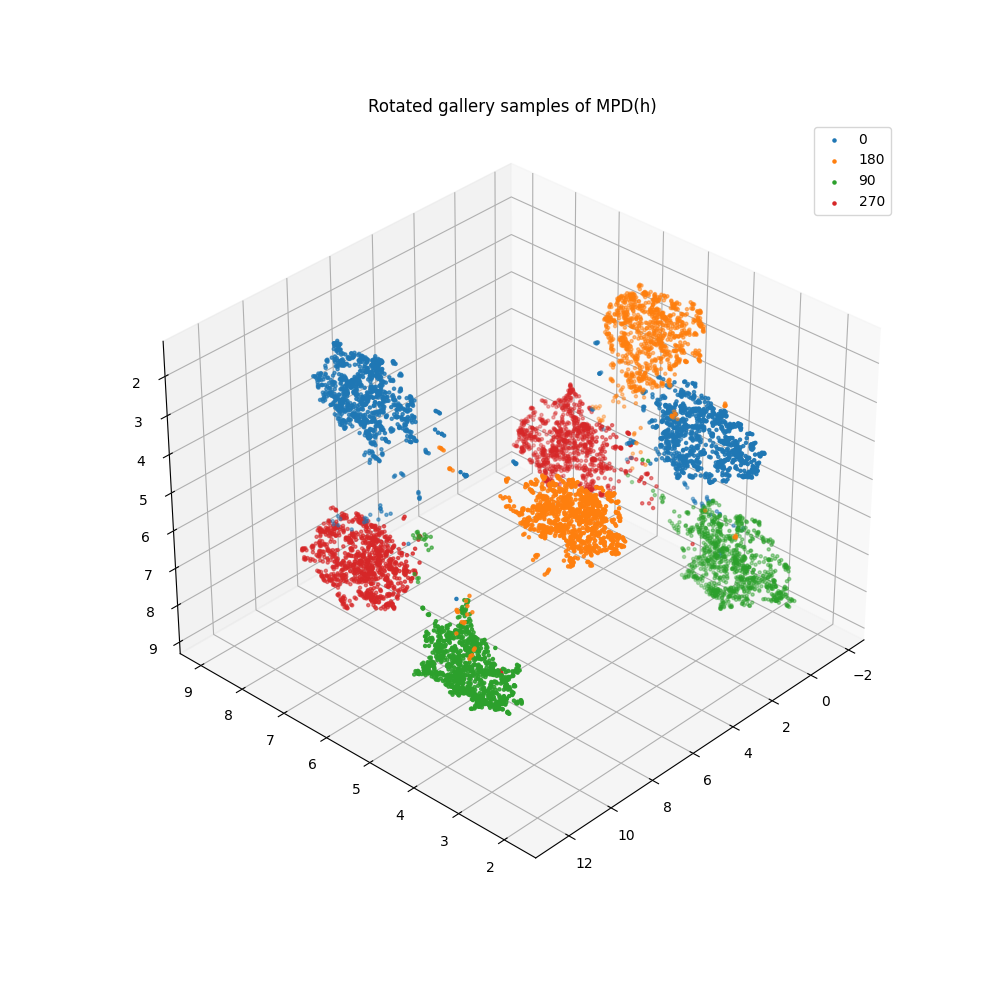

In [170]:
%matplotlib widget
plt.style.use('default')
fig = plt.figure(figsize=(10,10))
color = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
ax = fig.gca(projection='3d')
# ax.scatter(source_embedded_3d_polyu[:, 0], source_embedded_3d_polyu[:, 1], source_embedded_3d_polyu[:, 2], marker='.')
# ax.scatter(source_embedded_3d_tongji[:, 0], source_embedded_3d_tongji[:, 1], source_embedded_3d_tongji[:, 2], marker='.')
# ax.scatter(source_embedded_3d_mpdh[:, 0], source_embedded_3d_mpdh[:, 1], source_embedded_3d_mpdh[:, 2], marker='.')
# ax.scatter(source_embedded_3d_mpdm[:, 0], source_embedded_3d_mpdm[:, 1], source_embedded_3d_mpdm[:, 2], marker='.')

# ax.scatter(source_embedded_3d[:, 0], source_embedded_3d[:, 1], source_embedded_3d[:, 2], marker='.')

# UMAP
# fail_index = [2000+f[1] for f in fail_loader]
# true_index = np.ones(source_embedded_3d.shape[0], dtype=bool)
# true_index[fail_index] = False
# ax.scatter(source_embedded_3d[true_index][:, 0], source_embedded_3d[true_index][:, 1], source_embedded_3d[true_index][:, 2], marker='.')
# ax.scatter(source_embedded_3d[fail_index][:, 0], source_embedded_3d[fail_index][:, 1], source_embedded_3d[fail_index][:, 2], marker='.')
# ax.legend(["True", "False"])

# ax.scatter(source_embedded_3d[::2, 0], source_embedded_3d[::2, 1], source_embedded_3d[::2, 2], marker='.')
# ax.scatter(source_embedded_3d[1::2, 0], source_embedded_3d[1::2, 1], source_embedded_3d[1::2, 2], marker='.')
# ax.legend(["Left", "Right"])

temp = source_embedded_3d.reshape(2000, 4, -1).transpose(1,0,2)
# ax.scatter(temp[1, :, 0], temp[1, :, 1], temp[1, :, 2], marker='.')

# source_embedded_3d_mpdh = temp[3].reshape(-1,3)
# ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.', c="blue")
# ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.', c="orange")

# source_embedded_3d_mpdh = temp[2].reshape(-1,3)
# ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.', c="orange")
# ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.', c="blue")

# source_embedded_3d_mpdh = temp[:]
# for i,s in enumerate(source_embedded_3d_mpdh):
#     ax.scatter(s[::2, 0], s[::2, 1], s[::2, 2], marker='.')
#     ax.scatter(s[1::2, 0], s[1::2, 1], s[1::2, 2], marker='.')

for t in temp:
    ax.scatter(t[:, 0], t[:, 1], t[:, 2], marker='.')
ax.legend(["0", "180", "90", "270"])

# ax.legend(["PolyU", "Tongji", "MPD(h)", "MPD(m)"])
ax.set_title("Rotated gallery samples of MPD(h)")
# ax.set_title("Cross-subject samples")
ax.view_init(-147, 137)
# plt.savefig("images/polyu-color-Huber-mpdh-all-fail-UMAP.png")
plt.savefig("images/polyu_king_rotated_gallery_samples_UMAP.png")
plt.show()

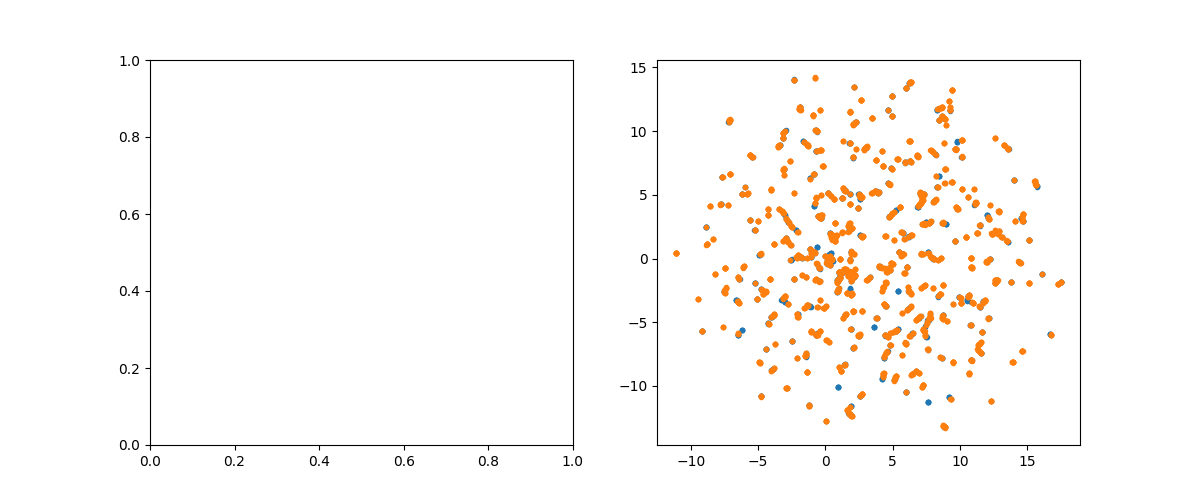

In [88]:
plt.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(12,5))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
sample_classes = 18
samples_of_class = 5

# for i in range(sample_classes):
#     ax[0].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

# plt.scatter(source_embedded_polyu[:, 0], source_embedded_polyu[:, 1], marker='.')
# plt.scatter(source_embedded_tongji[:, 0], source_embedded_tongji[:, 1], marker='.')
# plt.scatter(source_embedded_mpdm[:, 0], source_embedded_mpdm[:, 1], marker='.')
# plt.scatter(source_embedded_mpdh[:, 0], source_embedded_mpdh[:, 1], marker='.')
plt.scatter(source_embedded[:1000, 0], source_embedded[:1000, 1], marker='.')
plt.scatter(source_embedded[1000:, 0], source_embedded[1000:, 1], marker='.')
plt.show()

/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


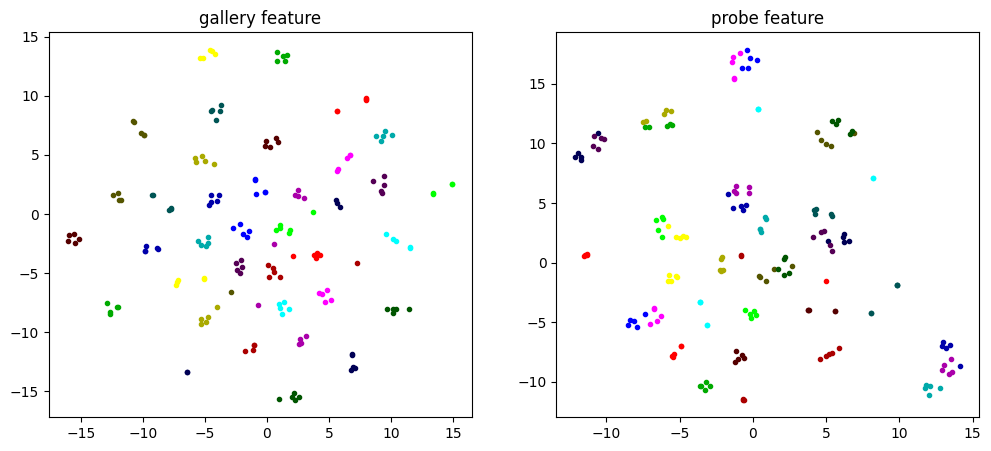

In [127]:
## plot gallery features
from sklearn.manifold import TSNE

fig, ax = plt.subplots(1,2, figsize=(12,5))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
sample_classes = 18

# Tongji
samples_of_class = 10
# PolyU
# samples_of_class = 6

ax[0].set_title("gallery feature")
source_embedded = TSNE(n_components=2).fit_transform(gallery_feature_loader[:sample_classes*samples_of_class].cpu())
for i in range(sample_classes):
    ax[0].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

ax[1].set_title("probe feature")
source_embedded = TSNE(n_components=2).fit_transform(probe_feature_loader[:sample_classes*samples_of_class].cpu())
for i in range(sample_classes):
    ax[1].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

# plt.savefig('plot/{}_{}_{}emb_{}l_{}_{}lr_{}e_tsne_compare.jpg'.format(dataset, model_type, feature_dim, lamb, loss_func, lr, epoch))
plt.show()
plt.close()

/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


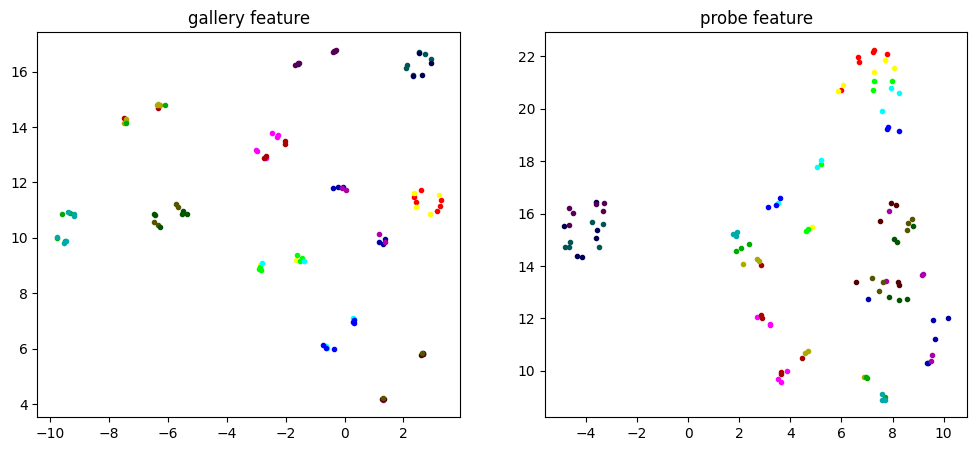

In [315]:
## plot gallery features
from sklearn.manifold import TSNE

fig, ax = plt.subplots(1,2, figsize=(12,5))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
sample_classes = 18

# Tongji
# samples_of_class = 10
# PolyU
samples_of_class = 6

ax[0].set_title("gallery feature")
source_embedded = TSNE(n_components=2).fit_transform(gallery_feature_loader[:sample_classes*samples_of_class].cpu())
for i in range(sample_classes):
    ax[0].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

ax[1].set_title("probe feature")
source_embedded = TSNE(n_components=2).fit_transform(probe_feature_loader[:sample_classes*samples_of_class].cpu())
for i in range(sample_classes):
    ax[1].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

# plt.savefig('plot/{}_{}_{}emb_{}l_{}_{}lr_{}e_tsne_compare.jpg'.format(dataset, model_type, feature_dim, lamb, loss_func, lr, epoch))
plt.show()
plt.close()

/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


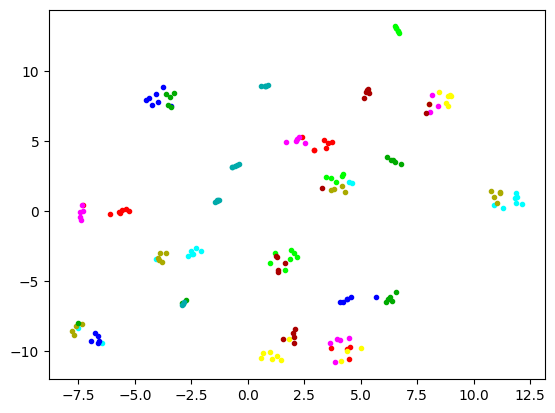

In [230]:
from sklearn.manifold import TSNE

c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']

sample_classes = 5
# Tongji
samples_of_class = 18
# PolyU
# samples_of_class = 6

# features = torch.cat([
#     probe_feature_loader[:5*samples_of_class].cpu(), 
#     probe_feature_loader[4340:4350].cpu(), 
#     gallery_feature_loader[:5*samples_of_class].cpu(),
#     gallery_feature_loader[4340:4350].cpu()
# ])
# source_embedded = TSNE(n_components=2).fit_transform(features)
# for i in range(sample_classes*2):
#     plt.plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])
    

features = torch.cat([probe_feature_loader[:sample_classes*samples_of_class].cpu(), gallery_feature_loader[:sample_classes*samples_of_class].cpu()])
source_embedded = TSNE(n_components=2).fit_transform(features)
for i in range(sample_classes*2):
    plt.plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])
    
# plt.legend(list(range(sample_classes)), loc='upper right')
# plt.savefig('plot/{}_{}_{}emb_{}l_{}_{}lr_{}e_tsne_combine.jpg'.format(dataset, model_type, feature_dim, lamb, loss_func, lr, epoch))
plt.show()
plt.close()

In [97]:
## calculate 1 to 1 match score and rank 1 accuracy
match_scores = torch.Tensor()
mathces = torch.Tensor()
# match_scores_rank1 = []
# mathces_rank1 = []
probe_label_loader = probe_label_loader.cpu()
cos = nn.CosineSimilarity()
test_acc = 0.0
# group_acc = 0.0
fail = []
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    test_pred = torch.max(cosine, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        # fail.append(i)
        # fail_index.append(i)
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
    
    # the group which total score is the gratest
    # group_pred = cosine.view(-1, 6).sum(dim=1).argmax()
    # group_acc += group_pred == probe_label_loader[i]
    
    # open-set verification: match scores for every gallery entry to every probe input
    match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    mathces = torch.cat([mathces, probe_label_loader[i] == gallery_label_loader], 0)
    
    # open-set identification: match scores for rank one gallery entry to every probe input
    # match_scores_rank1.append(cosine_max.cpu())
    # mathces_rank1.append(gallery_label_loader[test_pred] == probe_label_loader[i])
        
test_acc/=len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
# print("Group Acc: %3.6f" % (group_acc/len(probeDataset)))
print("Fail num: %d" % len(fail_loader))
len(match_scores), len(mathces)#, len(match_scores_rank1), len(mathces_rank1)

Test Acc: 0.872667
Fail num: 382


(3000000, 3000000)

In [127]:
# Euclidean distance
match_scores = torch.Tensor()
mathces = torch.Tensor()
# match_scores_rank1 = []
# mathces_rank1 = []
pdist = nn.PairwiseDistance()
test_acc = 0.0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    distance = pdist(p, gallery_feature_loader)
    test_pred = torch.min(distance, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        # fail.append(i)
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
    
    # the group which total score is the gratest
    # group_pred = cosine.view(-1, 6).sum(dim=1).argmax()
    # group_acc += group_pred == probe_label_loader[i]
    
    # open-set verification: match scores for every gallery entry to every probe input
    match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    mathces = torch.cat([mathces, probe_label_loader[i] == gallery_label_loader], 0)
    
    # open-set identification: match scores for rank one gallery entry to every probe input
    # match_scores_rank1.append(cosine_max.cpu())
    # mathces_rank1.append(gallery_label_loader[test_pred] == probe_label_loader[i])
    
    
test_acc/=len(probeDataset_target)
print("Test Acc: %3.6f" % (test_acc))
# print("Group Acc: %3.6f" % (group_acc/len(probeDataset)))
print("Fail num: %d" % len(fail_loader))
len(match_scores), len(mathces)#, len(match_scores_rank1), len(mathces_rank1)

Test Acc: 0.908333
Fail num: 550


(12000000, 12000000)

In [308]:
roc_loader = []

In [314]:
roc_loader.append({
    "eer":eer,
    "fpr":fpr,
    "fnr":fnr,
})
len(roc_loader)

3

In [299]:
torch.save(roc_loader, "plot/optuna-third-rotation-ROC-multi.pt")

In [313]:
## load log
checkpoint = torch.load("plot/optuna-third-rotation-ROC-multi.pt")[0]
eer = checkpoint['eer']
fpr = checkpoint['fpr']
fnr = checkpoint['fnr']
# log_loader = []

In [294]:
## calculate FAR, FRR and EER
from sklearn import metrics
import numpy as np

fpr, tpr, thresholds = metrics.roc_curve(mathces, match_scores, pos_label=1)
fnr = 1-tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]#, fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER: ", eer)

EER:  0.03881010860484545


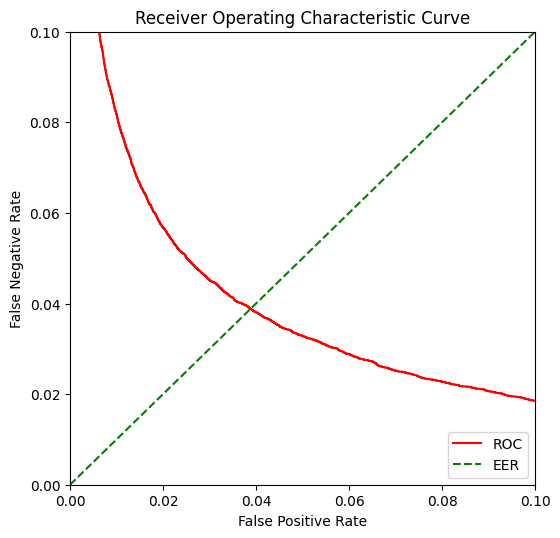

In [296]:
%matplotlib inline
fig = plt.figure(figsize=(6,6), dpi=100)

plt.plot(fpr, fnr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', label="EER", linestyle='--')
plt.xlim(0,0.1)
plt.ylim(0,0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
# plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
# plt.savefig('plot/{}_{}_{}emb_{}l_{}_{}lr_{}e_roc.jpg'.format(dataset, model_type, feature_dim, lamb, loss_func, lr, epoch))
plt.savefig("optuna-third-rotation-ROC-multi.jpg")
plt.show()

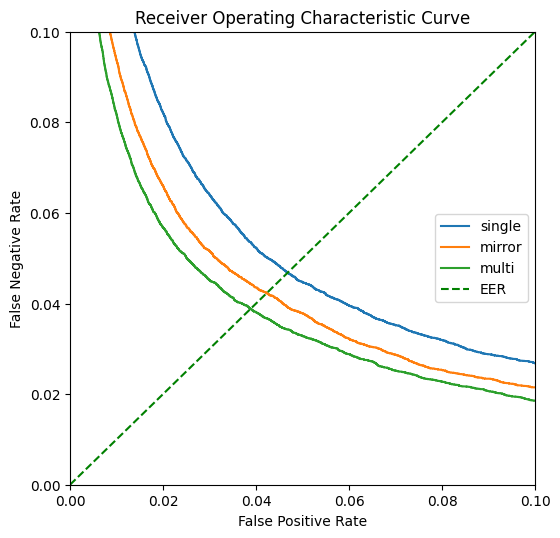

In [317]:
%matplotlib inline
fig = plt.figure(figsize=(6,6), dpi=100)

plt.plot(roc_loader[0]["fpr"], roc_loader[0]["fnr"], label='single')
plt.plot(roc_loader[1]["fpr"], roc_loader[1]["fnr"], label='mirror')
plt.plot(roc_loader[2]["fpr"], roc_loader[2]["fnr"], label='multi')
plt.plot([0, 1], [0, 1], color='green', label="EER", linestyle='--')
plt.xlim(0,0.1)
plt.ylim(0,0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
# plt.savefig("optuna-third-rotation-ROC-multi.jpg")
plt.show()

In [150]:
## calculate Ver@0.1%FAR and Ver@0.01%FAR
# valid_idx  = np.where(fpr <= 0.001)[0]
threshold_idx_0001 = np.where(fpr <= 0.001)[0].max()
threshold_idx_00001 = np.where(fpr <= 0.0001)[0].max()
print("Verfication TAR at 0.1% FAR: ", tpr[threshold_idx_0001])
print("Verfication TAR at 0.01% FAR: ", tpr[threshold_idx_00001])

Verfication TAR at 0.1% FAR:  0.9468571428571428
Verfication TAR at 0.01% FAR:  0.8778285714285714


In [42]:
## experiment records: cross dataset
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "learning rate", "epoch","source acc","target acc", "mirror acc"])
# ELR
df.loc[0] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.7076, 0]
df.loc[1] = ["PolyU", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5613, 0]
df.loc[2] = ["PolyU", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5915, 0]
df.loc[3] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.926, 0]
df.loc[4] = ["Tongji", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7288, 0]
df.loc[5] = ["Tongji", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7378, 0]
df.loc[6] = ["MPD_h", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8883, 0]
df.loc[7] = ["MPD_h", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8961, 0]
df.loc[8] = ["MPD_h", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.983, 0]
df.loc[9] = ["MPD_m", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.8134, 0]
df.loc[10] = ["MPD_m", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.7903, 0]
df.loc[11] = ["MPD_m", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.9647, 0]

# reduced 1 resnest50d pretrain lmcl focal huber 
df.loc[0] = ["PolyU", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001 40, 1, 0.9440, 0.9723]
df.loc[1] = ["PolyU", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 1, 0.8602, 0.8968]
df.loc[2] = ["PolyU", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 1, 0.8282, 0.8858]
df.loc[3] = ["Tongji", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9834, 0.9951]
df.loc[4] = ["Tongji", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9157, 0.9313]
df.loc[5] = ["Tongji", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9068, 0.9242]
df.loc[6] = ["MPD_h", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.9637, 0.9951]
df.loc[7] = ["MPD_h", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.9686, 0.9934]
df.loc[8] = ["MPD_h", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.99, 0.9967]
df.loc[9] = ["MPD_m", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9714, 0.9949]
df.loc[10] = ["MPD_m", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9773, 0.9899]
df.loc[11] = ["MPD_m", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9908, 0.9935]
df

source  target shot                  model feature_dim Loss function  \
0    PolyU  Tongji    5  ResNeSt26d-pretrained         128         CLMCL   
1    PolyU   MPD_h    5  ResNeSt26d-pretrained         128         CLMCL   
2    PolyU   MPD_m    5  ResNeSt26d-pretrained         128         CLMCL   
3   Tongji   PolyU    5  ResNeSt26d-pretrained         128         CLMCL   
4   Tongji   MPD_h    5  ResNeSt26d-pretrained         128         CLMCL   
5   Tongji   MPD_m    5  ResNeSt26d-pretrained         128         CLMCL   
6    MPD_h   PolyU    5  ResNeSt26d-pretrained         128         CLMCL   
7    MPD_h  Tongji    5  ResNeSt26d-pretrained         128         CLMCL   
8    MPD_h   MPD_m    5  ResNeSt26d-pretrained         128         CLMCL   
9    MPD_m   PolyU    5  ResNeSt26d-pretrained         128         CLMCL   
10   MPD_m  Tongji    5  ResNeSt26d-pretrained         128         CLMCL   
11   MPD_m   MPD_h    5  ResNeSt26d-pretrained         128         CLMCL   

    lambda learning rate epoch source acc  target acc  
0      0.1  0.001+ELR0.9    50          1      0.7076  
1      0.1  0.001+ELR0.9    50          1      0.5613  
2      0.1  0.001+ELR0.9    50          1      0.5915  
3      0.1  0.001+ELR0.9    50     0.9533      0.9260  
4      0.1  0.001+ELR0.9    50     0.9533      0.7288  
5      0.1  0.001+ELR0.9    50     0.9533      0.7378  
6      0.1  0.001+ELR0.9    50       0.98      0.8883  
7      0.1  0.001+ELR0.9    50       0.98      0.8961  
8      0.1  0.001+ELR0.9    50       0.98      0.9830  
9      0.1  0.001+ELR0.9    50     0.9667      0.8134  
10     0.1  0.001+ELR0.9    50     0.9667      0.7903  
11     0.1  0.001+ELR0.9    50     0.9667      0.9647

In [269]:
## experiment records: cross dataset fine tuning with new matching
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "learning rate", "epoch","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
df.loc[0] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, 1, 0.8217, "all, sum centers", 50, 1, '0.9197(92.46)']
df.loc[1] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 10, 0.9833, 0.97, "all, sum centers", 50, 0.9789, '0.9946(99.43)']

# ELR
df.loc[2] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.7768, "all, sum centers", 50, 1, '0.915(0.909)']
df.loc[3] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.926, "all, sum centers", 50, '0.9578(97.57)', '0.9909(99.43)']
df.loc[4] = ["PolyU", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5613, "all, sum centers", 50, 0.9971, 0.8143]
df.loc[5] = ["PolyU", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5917, "all, sum centers", 50, 0.9886, 0.7935]
df.loc[6] = ["Tongji", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7288, "all, sum centers", 50, 0.9544, 0.8653]
df.loc[7] = ["Tongji", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7378, "all, sum centers", 50, 0.9711, 0.8553]
df.loc[7] = ["MPD_h", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8886, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_h", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8961, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_h", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.983, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.8134, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.7903, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.9647, "all, sum centers", 50, 0, 0]

df

source  target shot                  model feature_dim Loss function  \
0   PolyU  Tongji    5  ResNeSt26d-pretrained         128         CLMCL   
1  Tongji   PolyU    5  ResNeSt26d-pretrained         128         CLMCL   
2   PolyU  Tongji    5  ResNeSt26d-pretrained         128         CLMCL   
3  Tongji   PolyU    5  ResNeSt26d-pretrained         128         CLMCL   
4   PolyU   MPD_h    5  ResNeSt26d-pretrained         128         CLMCL   
5   PolyU   MPD_m    5  ResNeSt26d-pretrained         128         CLMCL   
6  Tongji   MPD_h    5  ResNeSt26d-pretrained         128         CLMCL   
7  Tongji   MPD_m    5  ResNeSt26d-pretrained         128         CLMCL   

   lambda learning rate epoch     source acc     target acc  \
0     0.1         0.001    20              1         0.8217   
1     0.1         0.001    10         0.9833           0.97   
2     0.1  0.001+ELR0.9    50              1         0.7768   
3     0.1  0.001+ELR0.9    10  0.9689(98.11)  0.9426(91.14)   
4     0.1  0.001+ELR0.9    50              1         0.5613   
5     0.1  0.001+ELR0.9    50              1         0.5917   
6     0.1  0.001+ELR0.9    50         0.9533         0.7288   
7     0.1  0.001+ELR0.9    50         0.9533         0.7378   

  fine tuning method fine tuning epoch     source acc     target acc  
0   all, sum centers                50              1  0.9197(92.46)  
1   all, sum centers                50         0.9789  0.9946(99.43)  
2   all, sum centers                50              1   0.915(0.909)  
3   all, sum centers                50  0.9578(97.57)  0.9909(99.43)  
4   all, sum centers                50         0.9971         0.8143  
5   all, sum centers                50         0.9886         0.7935  
6   all, sum centers                50         0.9544         0.8653  
7   all, sum centers                50         0.9711         0.8553

In [105]:
## experiment records: cross subject feature matching
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "Loss function","identification acc","mirror","mean","half"])
df.loc[0] = ["MPD_h", "ResNet20_basic", 128, 0.1, '0.001', 200, "CLMCL", 0.7733, 0.7267, 0.7983, 0.8133]
df.loc[1] = ["MPD_h", "ResNet18_default", 128, 0.1, '0.001', 150, "CLMCL", 0.9033, 0.9183, 0.8833, 0.9133]
df.loc[2] = ["MPD_h", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR', 50, "CLMCL", 0.9667, 0.9533, 0.9783, 0.985]
df.loc[3] = ["MPD_m", "ResNet20_basic", 128, 0.1, '0.001', 200, "CLMCL", 0.86, 0.7017, 0.845, 0.8717]
df.loc[4] = ["MPD_m", "ResNet18_default", 128, 0.1, '0.001', 200, "CLMCL", 0.8483, 0.7733, 0.9017, 0.91]
df.loc[5] = ["MPD_m", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR', 50, "CLMCL", 0.98, 0.97, 0.9917, 0.9967]

df

dataset                     model feature_dim  lambda learning rate  \
0   MPD_h            ResNet20_basic         128     0.1         0.001   
1   MPD_h          ResNet18_default         128     0.1         0.001   
2   MPD_h  SE-ResNeXt26d-pretrained         128     0.1     0.001+ELR   
3   MPD_m            ResNet20_basic         128     0.1         0.001   
4   MPD_m          ResNet18_default         128     0.1         0.001   
5   MPD_m  SE-ResNeXt26d-pretrained         128     0.1     0.001+ELR   

  train epoch Loss function  identification acc  mirror    mean    half  
0         200         CLMCL              0.7733  0.7267  0.7983  0.8133  
1         150         CLMCL              0.9033  0.9183  0.8833  0.9133  
2          50         CLMCL              0.9667  0.9533  0.9783  0.9850  
3         200         CLMCL              0.8600  0.7017  0.8450  0.8717  
4         200         CLMCL              0.8483  0.7733  0.9017  0.9100  
5          50         CLMCL              0.9800  0.9700  0.9917  0.9967

In [ ]:
## experiment records: cross dataset
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "learning rate", "epoch","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
df.loc[0] = ["MPD_m", "PolyU", 5, "SE-ResNeXt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 10, '0.9767(95.67)', '0.8094(78.91)', "all, sum centers", 50, '0.9383(95)', '0.9926(99.4)']
df.loc[1] = ["MPD_m", "Tongji", 5, "SE-ResNeXt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 10, '0.9767(95.67)', '0.7313(75.26)', "all, sum centers", 50, '0.9283(94.5)', '0.945(94.86)']
df.loc[2] = ["PolyU", "Tongji", 5, "SE-ResNeXt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, '0.9943(100)', '0.6742(70.38)', "all, sum centers", 100, '1(99.72)', '0.886(91.21)']
df.loc[3] = ["Tongji", "PolyU", 5, "SE-ResNeXt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, '0.9622(97)', '0.892(88.63)', "all, sum centers", 50, '0.9556(95.89)', '0.9849(9843)']
df.loc[4] = ["Tongji", "PolyU", 5, "SE-ResNeXt26d", 128, "CLMCL", 0.1, 0.001, 200, '0.9578(98.89)', '0.8177(77.66)', "all, sum centers", 50, '0.8111(86.67)', '0.93(9354)']
df.loc[5] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, '1(99.71)', '0.7332(75.52)', "all, sum centers", 50, '0.9914(98.86)', '0.9137(92.46)']
df.loc[6] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, '0.9689(98.11)', '0.9426(91.14)', "all, sum centers", 50, '0.9578(97.57)', '0.9909(99.43)']

# ELR
df.loc[5] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, '1(100)', '0.68(70.77)', "all, sum centers", 50, '0.9914(98.86)', '0.9137(92.46)']
df.loc[6] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, '0.9689(98.11)', '0.9426(91.14)', "all, sum centers", 50, '0.9578(97.57)', '0.9909(99.43)']

df

In [406]:
## experiment records: unconstrained
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
df.loc[0] = ["MPD_h", "ResNet20_basic", 128, 0.1, 0.001, 200, "CLMCL", 0.7267, 0, 0, 0]#77.33 no mirror
df.loc[1] = ["MPD_h", "ResNet18_default", 128, 0.1, 0.001, 150, "CLMCL", 0.9183, 0, 0, 0]#90.33 no mirror
df.loc[2] = ["MPD_h", "ResNet18", 128, 0.1, 0.001, 50, "CLMCL", 0.64, 0, 0, 0]#76.83 no mirror
df.loc[3] = ["MPD_m", "ResNet20_basic", 128, 0.1, 0.001, 200, "CLMCL", 0.7017, 0, 0, 0]#86 no mirror
df.loc[4] = ["MPD_m", "ResNet18_default", 128, 0.1, 0.001, 200, "CLMCL", 0.7733, 0, 0, 0]#84.83 no mirror
df.loc[5] = ["MPD_m", "ResNet18", 128, 0.1, 0.001, 50, "CLMCL", 0.8017, 0, 0, 0]#87.67 no mirror


df.loc[5] = ["MPD_h", "SE-ResNeXt26d", 128, 0.1, 0.001, 300, "CLMCL", 0.8067, 0, 0, 0]#92.33 no mirror
df.loc[5] = ["MPD_m", "SE-ResNeXt26d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.9767, 0, 0, 0]#95.67 no mirror
df.loc[5] = ["MPD_h", "SE-ResNeXt26d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.9533, 0, 0, 0]#95.50 no mirror
df.loc[5] = ["MPD_h", "ResNeSt26d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.9583, 0, 0, 0]#96.33 no mirror
df.loc[5] = ["MPD_m", "ResNeSt26d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.9717, 0, 0, 0]#96.17 no mirror
df.loc[5] = ["MPD_h", "ResNeSt26d", 128, 0.1, 0.001, 200, "CLMCL", 0.8983, 0, 0, 0]#94.33 no mirror
df.loc[5] = ["MPD_h", "ResNeSt14d-pretrained", 128, 0.1, 0.001, 20, "CLMCL", 0.9667, 0, 0, 0]#96.17 no mirror
df.loc[5] = ["MPD_m", "ResNeSt14d-pretrained", 128, 0.1, 0.001, 20, "CLMCL", 0.9083, 0, 0, 0]#92.17 no mirror
df.loc[5] = ["MPD_m", "ResNeSt50d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.9967, 0, 0, 0]#97.83 no mirror
df.loc[5] = ["MPD_h", "ResNeSt50d-pretrained", 128, 0.1, 0.001, 10, "CLMCL", 0.945, 0, 0, 0]#94.5 no mirror

# ELR
df.loc[5] = ["MPD_h", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR0.9>5', 50, "CLMCL", 0.97(98), 0, 0, 0]
df.loc[5] = ["MPD_m", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR0.9>5', 50, "CLMCL", 0.9533(9667), 0, 0, 0]

df

dataset             model feature_dim  lambda  learning rate train epoch  \
0   MPD_h    ResNet20_basic         128     0.1          0.001         200   
1   MPD_h  ResNet18_default         128     0.1          0.001         150   
2   MPD_h          ResNet18         128     0.1          0.001          50   
3   MPD_m    ResNet20_basic         128     0.1          0.001         200   
4   MPD_m  ResNet18_default         128     0.1          0.001          50   
5   MPD_m          ResNet18         128     0.1          0.001          50   

  Loss function  identification acc Verification@0.01%FAR  \
0         CLMCL              0.7267                     0   
1         CLMCL              0.9183                     0   
2         CLMCL              0.6400                     0   
3         CLMCL              0.7017                     0   
4         CLMCL              0.7733                     0   
5         CLMCL              0.8017                     0   

  Verification@0.1%FAR EER  
0                    0   0  
1                    0   0  
2                    0   0  
3                    0   0  
4                    0   0  
5                    0   0

In [129]:
## experiment records: fine tuning 
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "epoch","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
df.loc[0] = ["Tongji", "PolyU", 5, "ResNet20_basic", 128, "CLMCL", 0.1, 200, '0.9956(99.67)', '0.9957(99.54)', "all, sum centers", 50, '0.9822', '0.9994']
df.loc[0] = ["Tongji", "PolyU", 5, "ResNet20_basic", 128, "CLMCL", 0.1, 200, '0.9956(99.67)', '0.9957(99.54)', "all, sum centers", 30, '0.9856(98.78)', '0.9994(99.94)']
df.loc[1] = ["PolyU", "Tongji", 5, "ResNet20_basic", 128, "CLMCL", 0.1, 200, '1(100)', '0.6068(67.32)', "all, sum centers", 150, '0.7771(79.43)', '0.6284(70.71)']
df.loc[2] = ["Tongji", "PolyU", 5, "ResNet18_default", 128, "CLMCL", 0.1, 500, '0.9611(95.22)', '0.8394(75.23)', "all, sum centers", 50, '0.9222(94.89)', '0.9760(96.23)']
df.loc[2] = ["Tongji", "PolyU", 5, "ResNet18_default", 128, "CLMCL", 0.1, 500, '0.9611(95.22)', '0.8394(75.23)', "all, sum centers", 30, '0.95(93.44)', '0.9769(96.69)']
df.loc[3] = ["PolyU", "Tongji", 5, "ResNet18_default", 128, "CLMCL", 0.1, 500, '1(100)', '0.7564(76.36)', "all, sum centers", 50, '1(99.71)', '0.8876(88.47)']
df.loc[4] = ["Tongji", "PolyU", 5, "ResNet18_modified", 128, "CLMCL", 0.1, 50, 0.9933, 0.9814, "all, sum centers", 50, 0.8556, 0.9966]
df.loc[4] = ["Tongji", "PolyU", 5, "ResNet18_modified", 128, "CLMCL", 0.1, 50, 0.9933, 0.9814, "all, sum centers", 30, 0.8844, 0.9969]
df.loc[5] = ["PolyU", "Tongji", 5, "ResNet18_modified", 128, "CLMCL", 0.1, 50, 1, 0.7573, "all, sum centers", 50, 1, 0.9252]
df

source  target shot              model feature_dim Loss function lambda  \
0  Tongji   PolyU    5     ResNet20_basic         128         CLMCL    200   
1   PolyU  Tongji    5     ResNet20_basic         128         CLMCL    200   
2  Tongji   PolyU    5   ResNet18_default         128         CLMCL    500   
3   PolyU  Tongji    5   ResNet18_default         128         CLMCL    500   
4  Tongji   PolyU    5  ResNet18_modified         128         CLMCL     50   
5   PolyU  Tongji    5  ResNet18_modified         128         CLMCL     50   

   epoch  source acc  target acc fine tuning method fine tuning epoch  \
0    0.1      0.9956      0.9957   all, sum centers               100   
1    0.1      1.0000      0.6068   all, sum centers               100   
2    0.1      0.9611      0.8394   all, sum centers               100   
3    0.1      1.0000      0.7564   all, sum centers               100   
4    0.1      0.9933      0.9814   all, sum centers               100   
5    0.1      1.0000      0.7573   all, sum centers                50   

   source acc  target acc  
0      0.7060      0.6320  
1      0.7057      0.6322  
2      0.7060      0.6320  
3      0.7060      0.6320  
4      0.7060      0.6320  
5      1.0000      0.9334

In [100]:
## experiment records: reproduction
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "epoch","source acc","target acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
df.loc[0] = ["Tongji", "PolyU", 5, "ResNet20_basic", 128, "CLMCL", 200, 0.1, 0.9956, 0.9957, 0.8553, 0.9299, 0.01475]
df.loc[1] = ["PolyU", "Tongji", 5, "ResNet20_basic", 128, "CLMCL", 200, 0.1, 1, 0.6068,  0.0825, 0.1653, 0.2486]
df.loc[2] = ["Tongji", "PolyU", 5, "ResNet18_default", 128, "CLMCL", 500, 0.1, 0.9611, 0.8394, 0.4278, 0.5830, 0.0886]
df.loc[3] = ["PolyU", "Tongji", 5, "ResNet18_default", 128, "CLMCL", 500, 0.1, 1, 0.7564,  0.4879, 0.6099, 0.071]
df.loc[4] = ["Tongji", "PolyU", 5, "ResNet18_modified", 128, "CLMCL", 50, 0.1, 0.9933, 0.9814, 0.8149, 0.9098, 0.0177]
df.loc[5] = ["PolyU", "Tongji", 5, "ResNet18_modified", 128, "CLMCL", 50, 0.1, 1, 0.7573,  0.2709, 0.4793, 0.1379]
df

source  target shot              model feature_dim Loss function lambda  \
0  Tongji   PolyU    5     ResNet20_basic         128         CLMCL    200   
1   PolyU  Tongji    5     ResNet20_basic         128         CLMCL    200   
2  Tongji   PolyU    5   ResNet18_default         128         CLMCL    500   
3   PolyU  Tongji    5   ResNet18_default         128         CLMCL    500   
4  Tongji   PolyU    5  ResNet18_modified         128         CLMCL     50   
5   PolyU  Tongji    5  ResNet18_modified         128         CLMCL     50   

   epoch  source acc  target acc  Verification@0.01%FAR  Verification@0.1%FAR  \
0    0.1      0.9956      0.9957                 0.8553                0.9299   
1    0.1      1.0000      0.6068                 0.0825                0.1653   
2    0.1      0.9611      0.8394                 0.4278                0.5830   
3    0.1      1.0000      0.7564                 0.4879                0.6099   
4    0.1      0.9933      0.9814                 0.8149                0.9098   
5    0.1      1.0000      0.7573                 0.2709                0.4793   

       EER  
0  0.01475  
1  0.24860  
2  0.08860  
3  0.07100  
4  0.01770  
5  0.13790

In [817]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "epoch","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
## cross dataset fine tuning 5 shot
# df.loc[0] = ["PolyU", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 200, 1, 0.607, "all, sum centers", 100, 0.706, 0.632]
# # 直接在目標資料集上用5張影像做訓練
# df.loc[1] = ["PolyU", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 0, 0, 0, "all, none", 100, 0.95, 0.679]
# resnet18的預訓練模型，loss(0.1CLMCL)卡在25降不下去
# resnet18 - avgpool + linear  
# df.loc[3] = ["Tongji", "PolyU", 5, "ResNet18", 128, "CLMCL", 0.1, 50, 0.993, 0.98, "all, none", 0, 0, 0] 
# 2model + 1feature combine + 0.1 clmcl, only train one model, and use this model to test, the acc 0.67, but mirror acc 0.98
# df.loc[3] = ["PolyU", "Tongji", 5, "ResNet20_2", 128, "CLMCL", 0.1, 200, 1, 0.607, "all, sum", 60, 0.963, 0.661]
# df.loc[3] = ["PolyU", "Tongji", 5, "ResNet20_2", 128, "CLMCL", 0.1, 200, 1, 0.607, "all, sum", 50, 0.974, 0.633]
# df.loc[3] = ["PolyU", "Tongji", 5, "ResNet18_2", 128, "CLMCL", 0.1, 25, 1, 0.633, "all, sum", 20, 1, 0.92]
# df.loc[3] = ["PolyU", "Tongji", 5, "ResNet18_2", 128, "CLMCL", 0.1, 50, 1, 0.757, "all, sum", 20, 1, 0.92]
df.loc[0] = ["PolyU", "Tongji", 5, "ResNet18", 128, "CLMCL", 0.1, 50, 1, 0.757, "all, sum", 50, 1, 0.933]
df.loc[1] = ["PolyU", "Tongji", 5, "ResNet18", 128, "CLMCL", 0.1, 0, 0, 0, "all, none", 100, 1, 0.9]
# df.loc[3] = ["MPD_h", "PolyU", 5, "ResNet18", 128, "CLMCL", 0.1, 50, 0.538, 0.66, "all, none", 0, 0, 0]
df.loc[2] = ["PolyU", "Tongji", 3, "ResNet18", 128, "CLMCL", 0.1, 50, 1, 0.757, "all, sum", 200, 1, 0.912]
df.loc[3] = ["PolyU", "Tongji", 3, "ResNet18", 128, "CLMCL", 0.1, 0, 0, 0, "all, none", 200, 0.97, 0.85]
df.loc[4] = ["PolyU", "Tongji", 1, "ResNet18", 128, "CLMCL", 0.1, 50, 1, 0.757, "all, sum", 200, 1, 0.824]
df.loc[5] = ["PolyU", "Tongji", 1, "ResNet18", 128, "CLMCL", 0.1, 0, 0, 0, "all, none", 200, 0.967, 0.88]
df.loc[6] = ["PolyU", "MPD_h", 5, "ResNet18", 128, "CLMCL", 0.1, 50, 1, 0.475, "all, sum", 0, 0, 0]
df.loc[7] = ["PolyU", "MPD_m", 5, "ResNet18", 128, "CLMCL", 0.1, 50, 1, 0.466, "all, sum", 0, 0, 0]

# df.loc[3] = ["PolyU", "Tongji", 1, "SEResNet18", 128, "CLMCL", 0.1, 50, 1, 0.486, "all, none", 0, 0, 0]

# df.loc[3] = ["PolyU", "MPD_h", 5, "ResNet20", 128, "CLMCL", 0.1, 200, 1, 0.337, "all, sum", 300, 0.897, 0.446]
# df.loc[3] = ["PolyU", "MPD_m", 5, "ResNet20", 128, "CLMCL", 0.1, 200, 1, 0.552, "all, sum", 100, 0.917, 0.489]

df

source  target shot     model feature_dim Loss function  lambda epoch  \
0  PolyU  Tongji    5  ResNet18         128         CLMCL     0.1    50   
1  PolyU  Tongji    5  ResNet18         128         CLMCL     0.1     0   
2  PolyU  Tongji    3  ResNet18         128         CLMCL     0.1    50   
3  PolyU  Tongji    3  ResNet18         128         CLMCL     0.1     0   
4  PolyU  Tongji    1  ResNet18         128         CLMCL     0.1    50   
5  PolyU  Tongji    1  ResNet18         128         CLMCL     0.1     0   
6  PolyU   MPD_h    5  ResNet18         128         CLMCL     0.1    50   
7  PolyU   MPD_m    5  ResNet18         128         CLMCL     0.1    50   

  source acc  target acc fine tuning method fine tuning epoch source acc  \
0          1       0.757           all, sum                50          1   
1          0       0.000          all, none               100          1   
2          1       0.757           all, sum               200          1   
3          0       0.000          all, none               200       0.97   
4          1       0.757           all, sum               200          1   
5          0       0.000          all, none               200      0.967   
6          1       0.475           all, sum                 0          0   
7          1       0.466           all, sum                 0          0   

   target acc  
0       0.933  
1       0.900  
2       0.912  
3       0.850  
4       0.824  
5       0.880  
6       0.000  
7       0.000

In [349]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
## cross dataset fine tuning 5 shot: 200e
# df.loc[0] = ["MPD", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 0.8, 0.57, 0, 0, 0]
# df.loc[0] = ["MPD", "PolyU", 5, "ResNet20", 128, "CLMCL", 0.1, 0.8, 0.83, 0, 0, 0]
df.loc[0] = ["Tongji", "PolyU", 5, "ResNet20", 128, "CLMCL", 0.1, 0.996, 0.996]
# df.loc[0] = ["Tongji", "MPD", 5, "ResNet20", 128, "CLMCL", 0.1, 0.996, 0.6, 0, 0, 0]
df.loc[1] = ["Tongji", "MPD_h", 5, "ResNet20", 128, "CLMCL", 0.1, 0.996, 0.546]
df.loc[2] = ["Tongji", "MPD_m", 5, "ResNet20", 128, "CLMCL", 0.1, 0.996, 0.55]
df.loc[3] = ["PolyU", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 1, 0.607, "all, sum centers", 100, 0.706, 0.632]
df.loc[4] = ["PolyU", "MPD_h", 5, "ResNet20", 128, "CLMCL", 0.1, 1, 0.337]
df.loc[5] = ["PolyU", "MPD_m", 5, "ResNet20", 128, "CLMCL", 0.1, 1, 0.552]
df.loc[6] = ["MPD_h", "PolyU", 5, "ResNet20", 128, "CLMCL", 0.1, 0.727, 0.893]
df.loc[7] = ["MPD_h", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 0.727, 0.684]
df.loc[8] = ["MPD_h", "MPD_m", 5, "ResNet20", 128, "CLMCL", 0.1, 0.727, 0.897]
df.loc[9] = ["MPD_m", "PolyU", 5, "ResNet20", 128, "CLMCL", 0.1, 0.7, 0.974]
df.loc[10] = ["MPD_m", "Tongji", 5, "ResNet20", 128, "CLMCL", 0.1, 0.7, 0.683]
df.loc[11] = ["MPD_m", "MPD_h", 5, "ResNet20", 128, "CLMCL", 0.1, 0.7, 0.5]

# 提昇模型效果
# df.loc[6] = ["MPD_h", "PolyU", 5, "MIR V2", 128, "CLMCL", 0.1, 0.83, 0.899]
# df.loc[9] = ["MPD_m", "PolyU", 5, "MIR V2", 128, "CLMCL", 0.1, 0.76, 0.843]
# df.loc[6] = ["MPD_h", "PolyU", 5, "SEMIR V2", 128, "CLMCL", 0.1, 0.577, 0.995]
# SEIR V2 比 SEMIR V2 再更好一點
df

source  target shot     model feature_dim Loss function  lambda  \
0   Tongji   PolyU    5  ResNet20         128         CLMCL     0.1   
1   Tongji   MPD_h    5  ResNet20         128         CLMCL     0.1   
2   Tongji   MPD_m    5  ResNet20         128         CLMCL     0.1   
3    PolyU  Tongji    5  ResNet20         128         CLMCL     0.1   
4    PolyU   MPD_h    5  ResNet20         128         CLMCL     0.1   
5    PolyU   MPD_m    5  ResNet20         128         CLMCL     0.1   
6    MPD_h   PolyU    5  ResNet20         128         CLMCL     0.1   
7    MPD_h  Tongji    5  ResNet20         128         CLMCL     0.1   
8    MPD_h   MPD_m    5  ResNet20         128         CLMCL     0.1   
9    MPD_m   PolyU    5  ResNet20         128         CLMCL     0.1   
10   MPD_m  Tongji    5  ResNet20         128         CLMCL     0.1   
11   MPD_m   MPD_h    5  ResNet20         128         CLMCL     0.1   

    source acc  target acc  
0        0.996       0.996  
1        0.996       0.546  
2        0.996       0.550  
3        1.000       0.607  
4        1.000       0.337  
5        1.000       0.552  
6        0.727       0.893  
7        0.727       0.684  
8        0.727       0.897  
9        0.700       0.974  
10       0.700       0.683  
11       0.700       0.500

In [28]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function","identification acc"])
## cross dataset few shot: half
df.loc[0] = ["PolyU", "Tongji", 10, "MIR_V2", 128, "LMCL", 0.536]
df.loc[1] = ["PolyU", "MPD", 10, "MIR_V2", 128, "LMCL", 0.49]
df.loc[2] = ["Tongji", "PolyU", 6, "MIR_V2", 128, "LMCL", 0.953]
df.loc[3] = ["Tongji", "MPD", 10, "MIR_V2", 128, "LMCL", 0.35]
df.loc[4] = ["MPD", "PolyU", 6, "MIR_V2", 128, "LMCL", 0.985]
df.loc[5] = ["MPD", "Tongji", 10, "MIR_V2", 128, "LMCL", 0.926]

## cross dataset few shot: PolyU cross Tongji
df.loc[0] = ["PolyU", "Tongji", 10, "MIR_V2", 128, "LMCL", 0.536]
df.loc[1] = ["PolyU", "Tongji", 5, "MIR_V2", 128, "LMCL", 0.68]
df.loc[2] = ["PolyU", "Tongji", 3, "MIR_V2", 128, "LMCL", 0.706]
df.loc[3] = ["PolyU", "Tongji", 1, "MIR_V2", 128, "LMCL", 0.656]

## cross dataset few shot: PolyU cross MPD
df.loc[4] = ["PolyU", "MPD", 10, "MIR_V2", 128, "LMCL", 0.49]
df.loc[5] = ["PolyU", "MPD", 5, "MIR_V2", 128, "LMCL", 0.526]
df.loc[6] = ["PolyU", "MPD", 3, "MIR_V2", 128, "LMCL", 0.519]
df.loc[7] = ["PolyU", "MPD", 1, "MIR_V2", 128, "LMCL", 0.378]

## cross dataset few shot: Tongji cross PolyU
df.loc[8] = ["Tongji", "PolyU", 6, "MIR_V2", 128, "LMCL", 0.953]
df.loc[9] = ["Tongji", "PolyU", 5, "MIR_V2", 128, "LMCL", 0.956]
df.loc[10] = ["Tongji", "PolyU", 3, "MIR_V2", 128, "LMCL", 0.957]
df.loc[11] = ["Tongji", "PolyU", 1, "MIR_V2", 128, "LMCL", 0.91]

## cross dataset few shot: Tongji cross MPD
df.loc[12] = ["Tongji", "MPD", 10, "MIR_V2", 128, "LMCL", 0.35]
df.loc[13] = ["Tongji", "MPD", 5, "MIR_V2", 128, "LMCL", 0.419]
df.loc[14] = ["Tongji", "MPD", 3, "MIR_V2", 128, "LMCL", 0.425]
df.loc[15] = ["Tongji", "MPD", 1, "MIR_V2", 128, "LMCL", 0.288]

## cross dataset few shot: MPD cross PolyU
df.loc[16] = ["MPD", "PolyU", 6, "MIR_V2", 128, "LMCL", 0.985]
df.loc[17] = ["MPD", "PolyU", 5, "MIR_V2", 128, "LMCL", 0.983]
df.loc[18] = ["MPD", "PolyU", 3, "MIR_V2", 128, "LMCL", 0.983]
df.loc[19] = ["MPD", "PolyU", 1, "MIR_V2", 128, "LMCL", 0.962]

## cross dataset few shot: MPD cross Tongji
df.loc[20] = ["MPD", "Tongji", 10, "MIR_V2", 128, "LMCL", 0.926]
df.loc[21] = ["MPD", "Tongji", 5, "MIR_V2", 128, "LMCL", 0.941]
df.loc[22] = ["MPD", "Tongji", 3, "MIR_V2", 128, "LMCL", 0.938]
df.loc[23] = ["MPD", "Tongji", 1, "MIR_V2", 128, "LMCL", 0.89]

df

source  target shot   model feature_dim Loss function  identification acc
0    PolyU  Tongji   10  MIR_V2         128          LMCL               0.536
1    PolyU  Tongji    5  MIR_V2         128          LMCL               0.680
2    PolyU  Tongji    3  MIR_V2         128          LMCL               0.706
3    PolyU  Tongji    1  MIR_V2         128          LMCL               0.656
4    PolyU     MPD   10  MIR_V2         128          LMCL               0.490
5    PolyU     MPD    5  MIR_V2         128          LMCL               0.526
6    PolyU     MPD    3  MIR_V2         128          LMCL               0.519
7    PolyU     MPD    1  MIR_V2         128          LMCL               0.378
8   Tongji   PolyU    6  MIR_V2         128          LMCL               0.953
9   Tongji   PolyU    5  MIR_V2         128          LMCL               0.956
10  Tongji   PolyU    3  MIR_V2         128          LMCL               0.957
11  Tongji   PolyU    1  MIR_V2         128          LMCL               0.910
12  Tongji     MPD   10  MIR_V2         128          LMCL               0.350
13  Tongji     MPD    5  MIR_V2         128          LMCL               0.419
14  Tongji     MPD    3  MIR_V2         128          LMCL               0.425
15  Tongji     MPD    1  MIR_V2         128          LMCL               0.288
16     MPD   PolyU    6  MIR_V2         128          LMCL               0.985
17     MPD   PolyU    5  MIR_V2         128          LMCL               0.983
18     MPD   PolyU    3  MIR_V2         128          LMCL               0.983
19     MPD   PolyU    1  MIR_V2         128          LMCL               0.962
20     MPD  Tongji   10  MIR_V2         128          LMCL               0.926
21     MPD  Tongji    5  MIR_V2         128          LMCL               0.941
22     MPD  Tongji    3  MIR_V2         128          LMCL               0.938
23     MPD  Tongji    1  MIR_V2         128          LMCL               0.890

In [13]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "training loss", "L2 Norm", "mirror", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, crossPT
# df.loc[0] = ["CrossTP", "ResNet20_basic", 128, 0.001, 0.01, 14, 0.7, 0, None, "CLMCL", 0.967, 0.706, 0.82, 0.0342] # 32 batch
# df.loc[1] = ["CrossTP", "ResNet20_basic", 128, 0.001, 0.01, 14, 0.7, 0, "mirror", "CLMCL", 0.992, 0.822, 0.9, 0.023]
df.loc[0] = ["CrossPT", "ResNet20_basic", 128, 0.001, 0.01, 14, 1.2, 0, None, "CLMCL", 0.519, 0.294, 0.375, 0.31] # mirror same
# LMCL fail
df.loc[1] = ["CrossPT", "ResNet20_basic", 128, 0.001, 0.01, 24, 0.08, 0, None, "arcFace", 0.523, 0.258, 0.36, 0.339] # mirror same
df.loc[2] = ["CrossPT", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 19, 0.4, 1, None, "arcFace", 0.52, 0.3, 0.39, 0.37] # mirror same
df.loc[3] = ["CrossPT", "Modified Inception ResNet V2 without avgpool", 128, 0.01, 0.01, 21, 1.5, 1, None, "CLMCL", 0.536, 0.28, 0.386, 0.146] # mirror same
df.loc[4] = ["CrossPT", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 0.9, 1, None, "LMCL", 0.52, 0.3, 0.39, 0.38] # mirror same

df

dataset                                         model feature_dim  lambda  \
0  CrossPT                                ResNet20_basic         128   0.001   
1  CrossPT                                ResNet20_basic         128   0.001   
2  CrossPT  Modified Inception ResNet V2 without avgpool         128   0.000   
3  CrossPT  Modified Inception ResNet V2 without avgpool         128   0.010   
4  CrossPT  Modified Inception ResNet V2 without avgpool         128   0.000   

   learning rate train epoch  training loss L2 Norm mirror Loss function  \
0           0.01          14           1.20       0   None         CLMCL   
1           0.01          24           0.08       0   None       arcFace   
2           0.01          19           0.40       1   None       arcFace   
3           0.01          21           1.50       1   None         CLMCL   
4           0.01          15           0.90       1   None          LMCL   

   identification acc  Verification@0.01%FAR  Verification@0.1%FAR    EER  
0               0.519                  0.294                 0.375  0.310  
1               0.523                  0.258                 0.360  0.339  
2               0.520                  0.300                 0.390  0.370  
3               0.536                  0.280                 0.386  0.146  
4               0.520                  0.300                 0.390  0.380

In [88]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "training loss", "L2 Norm", "mirror", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, parameter testing
# df.loc[28] = ["CrossTP", "Modified Inception ResNet V2", 256, 0, 0.01, 37, 1.4, "LMCL", 0.74, 0.07, 0.18, 0.20]
# Modified Inception ResNet V2 + LMCL + center weight decay=1: acc = 0.68(43e)
# df.loc[0] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 1.1, 0, None, "LMCL", 0.886, 0.283, 0.46, 0.085]
# df.loc[1] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 1.1, 0, "mirror", "LMCL", 0.903, 0.383, 0.546, 0.079] # mirror
# df.loc[2] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 16, 0.9, 0.1, None, "LMCL", 0.881, 0.389, 0.55, 0.074]
# df.loc[3] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 16, 0.9, 0.1, "mirror", "LMCL", 0.896, 0.45, 0.6, 0.07] # mirror
df.loc[4] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 16, 0.8, 1, None, "LMCL", 0.954, 0.644, 0.78, 0.038]
df.loc[5] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 16, 0.8, 1, "mirror", "LMCL", 0.98, 0.73, 0.85, 0.0285] # mirror
df.loc[6] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 16, 0.8, 1, "mirror*2", "LMCL", 0.99, 0.78, 0.886, 0.0216] # mirror
# ResNet20 + LMCL + center weight decay = 1 is also hard to train
# ResNet20 + CLMCL + center weight decay = 1: acc = 0.76
df.loc[7] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.01, 0.01, 15, 1.3, 1, None, "CLMCL", 0.87, 0.39, 0.59, 0.068]
df.loc[8] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.01, 0.01, 15, 1.3, 1, "mirror", "CLMCL", 0.9, 0.46, 0.63, 0.059] # mirror
df.loc[9] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.01, 0.01, 15, 1.3, 1, "mirror*2", "CLMCL", 0.913, 0.48, 0.65, 0.052] # mirror
df.loc[10] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 0.19, 1, None, "arcFace", 0.927, 0.49, 0.67, 0.058]
df.loc[11] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 0.19, 1, "mirror", "arcFace", 0.94, 0.52, 0.67, 0.06] # mirror
df.loc[12] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0, 0.01, 15, 0.19, 1, "mirror*2", "arcFace", 0.96, 0.57, 0.71, 0.053] # mirror
# df.loc[8] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.001, 0.01, 14, 0.9, None, 1, "CLMCL", 0.88, 0.41, 0.58, 0.071] # mirror almost same
# df.loc[8] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.001, 0.01, 15, 1, None, 1, "CLMCL", 0.92, 0.52, 0.68, 0.055] # image size 299
# df.loc[8] = ["CrossTP", "Modified Inception ResNet V2 without avgpool", 128, 0.001, 0.01, 15, 1, "mirror", 1, "CLMCL", 0.958, 0.6, 0.747, 0.046] # mirror
# CLMCL 0.01 0.01 256 dim is now well
df.iloc[:,[1,7,8,9,10,11,12,13]]

model L2 Norm    mirror  \
4   Modified Inception ResNet V2 without avgpool       1      None   
5   Modified Inception ResNet V2 without avgpool       1    mirror   
6   Modified Inception ResNet V2 without avgpool       1  mirror*2   
7   Modified Inception ResNet V2 without avgpool       1      None   
8   Modified Inception ResNet V2 without avgpool       1    mirror   
9   Modified Inception ResNet V2 without avgpool       1  mirror*2   
10  Modified Inception ResNet V2 without avgpool       1      None   
11  Modified Inception ResNet V2 without avgpool       1    mirror   
12  Modified Inception ResNet V2 without avgpool       1  mirror*2   

   Loss function  identification acc  Verification@0.01%FAR  \
4           LMCL               0.954                  0.644   
5           LMCL               0.980                  0.730   
6           LMCL               0.990                  0.780   
7          CLMCL               0.870                  0.390   
8          CLMCL               0.900                  0.460   
9          CLMCL               0.913                  0.480   
10       arcFace               0.927                  0.490   
11       arcFace               0.940                  0.520   
12       arcFace               0.960                  0.570   

    Verification@0.1%FAR     EER  
4                  0.780  0.0380  
5                  0.850  0.0285  
6                  0.886  0.0216  
7                  0.590  0.0680  
8                  0.630  0.0590  
9                  0.650  0.0520  
10                 0.670  0.0580  
11                 0.670  0.0600  
12                 0.710  0.0530

In [64]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "training loss", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, resnet 20 vs Modified inception resnet v2
# df.loc[1] = ["Tongji", "ResNet20", 128, 0.001, 0.01, 20, 0.49, "CLMCL", 0.903, 0.57, 0.68, 0.0852]
# df.loc[2] = ["Tongji", "ResNet20", 128, 0.001, 0.01, 20, 0.49, "CLMCL", 0.925, 0.62, 0.74, 0.0696] #mirror
# df.loc[4] = ["Tongji", "ResNet20", 128, 0, 0.01, 20, 0.46, "LMCL", 0.8075, 0.04, 0.49, 0.116]
# df.loc[6] = ["Tongji", "ResNet20", 128, 0, 0.01, 25, 0.5, "arcFace", 0.934, 0.617, 0.744, 0.0532] # mirror lower
df.loc[3] = ["Tongji", "ResNet20_basic", 128, 0.001, 0.01, 19, 0.5, "CLMCL", 0.92, 0.58, 0.72, 0.0664] # mirror 0.8925
df.loc[4] = ["Tongji", "ResNet20_basic", 128, 0, 0.01, 20, 0.5, "LMCL", 0.9125, 0.60, 0.713, 0.0645] # mirror lower
df.loc[5] = ["Tongji", "ResNet20_basic", 128, 0, 0.01, 15, 0.1, "arcFace", 0.86, 0.52, 0.65, 0.0814] # mirror lower
df.loc[7] = ["Tongji", "Modified Inception ResNet V2", 128, 0, 0.01, 39, 1, "LMCL", 0.9325, 0.61, 0.77, 0.052] # mirror lower
df.loc[8] = ["Tongji", "Modified Inception ResNet V2", 128, 0, 0.01, 29, 0.1, "arcFace", 0.9375, 0.61, 0.76, 0.036] # mirror lower
df.loc[9] = ["Tongji", "Modified Inception ResNet V2", 128, 0.1, 0.01, 41, 1.3, "CLMCL", 0.964, 0.64, 0.81, 0.034] # mirror lower

# df.loc[10] = ["PolyU", "ResNet20", 128, 0.001, 0.01, 40, 0.32, "CLMCL", 0.99, 0.7375, 0.852, 0.041]
# df.loc[11] = ["PolyU", "ResNet20", 128, 0, 0.01, 20, 0.45, "LMCL", 0.96, 0.674, 0.805, 0.0483]
df.loc[12] = ["PolyU", "ResNet20_basic", 128, 0, 0.01, 20, 0.1, "arcFace", 0.988, 0.83, 0.92, 0.019]
df.loc[13] = ["PolyU", "ResNet20_basic", 128, 0, 0.01, 20, 0.1, "arcFace", 0.993, 0.86, 0.9375, 0.014] # mirror
df.loc[14] = ["PolyU", "ResNet20_basic", 128, 0, 0.01, 24, 0.9, "LMCL", 0.985, 0.796, 0.9, 0.0273]
df.loc[15] = ["PolyU", "ResNet20_basic", 128, 0, 0.01, 24, 0.9, "LMCL", 0.992, 0.84, 0.923, 0.019] # mirror
df.loc[16] = ["PolyU", "ResNet20_basic", 128, 0.001, 0.01, 27, 0.5, "CLMCL", 0.987, 0.797, 0.886, 0.029]
df.loc[17] = ["PolyU", "ResNet20_basic", 128, 0.001, 0.01, 27, 0.5, "CLMCL", 0.997, 0.827, 0.9, 0.024] # mirror
df.loc[18] = ["PolyU", "Modified Inception ResNet V2", 128, 0.1, 0.01, 50, 1.2, "CLMCL", 1, 0.85, 0.95, 0.00888] # mirror lower
df.loc[19] = ["PolyU", "Modified Inception ResNet V2", 128, 0, 0.01, 50, 0.9, "LMCL", 0.995, 0.8, 0.9, 0.019] # mirror lower
df.loc[20] = ["PolyU", "Modified Inception ResNet V2", 128, 0, 0.01, 39, 0.1, "arcFace", 0.982, 0.75, 0.88, 0.0258] # mirror lower

# df.loc[21] = ["CrossTP", "ResNet20", 128, 0.001, 0.01, 20, 0.832, "CLMCL", 0.54, 0.011, 0.11, 0.288]
# df.loc[22] = ["CrossTP", "ResNet20", 128, 0, 0.01, 20, 1.4, "LMCL", 0.948, 0.605, 0.74, 0.0588] # hard to train
df.loc[23] = ["CrossTP", "ResNet20_basic", 128, 0, 0.01, 25, 0.7, "LMCL", 0.77, 0.2, 0.42, 0.1]
df.loc[24] = ["CrossTP", "ResNet20_basic", 128, 0, 0.01, 16, 0.3, "arcFace", 0.85, 0.257, 0.507, 0.0728] # lr*0.1 per 10e, mirror lower
df.loc[25] = ["CrossTP", "ResNet20_basic", 128, 0.001, 0.01, 23, 0.6, "CLMCL", 0.9, 0.315, 0.508, 0.0746] # lr*0.1 per 10e, mirror lower
df.loc[25] = ["CrossTP", "ResNet20_basic", 128, 0.001, 0.01, 23, 0.6, "CLMCL", 0.927, 0.42, 0.6, 0.059] # mirror
df.loc[26] = ["CrossTP", "Modified Inception ResNet V2", 128, 0, 0.01, 35, 0.1, "arcFace", 0.724, 0.07, 0.15, 0.185] # mirror lower
df.loc[27] = ["CrossTP", "Modified Inception ResNet V2", 128, 0, 0.01, 36, 1.5, "LMCL", 0.746, 0.124, 0.24, 0.17] # mirror almost same
df.loc[28] = ["CrossTP", "Modified Inception ResNet V2", 128, 0.1, 0.01, 26, 1.9, "CLMCL", 0.85, 0.2, 0.38, 0.1] # mirror almost same

df.loc[29] = ["CrossTP", "Inception ResNet V1", 128, 0.1, 0.01, 60, 4.3, "CLMCL", 0.8, 0.22, 0.39, 0.11]
df.loc[30] = ["CrossTP", "Inception ResNet V1", 128, 0.1, 0.01, 60, 4.3, "CLMCL", 0.864, 0.345, 0.508, 0.098] # mirror
df.loc[31] = ["CrossTP", "Inception ResNet V1", 128, 0, 0.01, 62, 1.1, "LMCL", 0.77, 0.14, 0.28, 0.15]
df.loc[32] = ["CrossTP", "Inception ResNet V1", 128, 0, 0.01, 62, 1.1, "LMCL", 0.8, 0.23, 0.37, 0.15] # mirror
df.loc[33] = ["CrossTP", "Inception ResNet V2", 128, 0.1, 0.01, 26, 1.8, "CLMCL", 0.81, 0.17, 0.34, 0.12]
df.loc[34] = ["CrossTP", "Inception ResNet V2", 128, 0.1, 0.01, 26, 1.8, "CLMCL", 0.83, 0.25, 0.42, 0.129] # mirror
df

dataset                model feature_dim  lambda  learning rate  \
29  CrossTP  Inception ResNet V1         128     0.1           0.01   
31  CrossTP  Inception ResNet V1         128     0.1           0.01   
33  CrossTP  Inception ResNet V2         128     0.1           0.01   

   train epoch  training loss Loss function  identification acc  \
29          60            4.3         CLMCL                0.80   
31          62            1.1          LMCL                0.77   
33          26            1.8         CLMCL                0.81   

    Verification@0.01%FAR  Verification@0.1%FAR   EER  
29                   0.22                  0.39  0.11  
31                   0.14                  0.28  0.15  
33                   0.17                  0.34  0.12

In [443]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "training loss", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, 256 dim
df.loc[0] = ["Tongji", "ResNet20", 256, 0, 0.01, 20, 0.06, "arcFace", 0.9325, 0.50, 0.759, 0.047]
df.loc[1] = ["Tongji", "ResNet20", 256, 0, 0.01, 20, 0.27, "LMCL", 0.924, 0.616, 0.731, 0.0621]
df.loc[2] = ["Tongji", "ResNet20", 256, 0.001, 0.01, 20, 0.36, "CLMCL", 0.975, 0.752, 0.856, 0.04]
df.loc[3] = ["Tongji", "ResNet20", 256, 0.1, 5e-4, 50, 1.38, "CLMCL", 0.8625, 0.52, 0.65, 0.0722]
# df.loc[4] = ["Tongji", "ResNet18", 256, 0, 0.01, 40, 0.15, "arcFace", 0.73, 0.40, 0.523, 0.093]
# df.loc[5] = ["Tongji", "ResNet18", 256, 0, 0.01, 40, 1.1, "LMCL", 0.71, 0.402, 0.51, 0.13]
# df.loc[6] = ["Tongji", "MobileNet V3 Large", 256, 0, 0.01, 40, 1.21, "LMCL", 0.8525, 0.324, 0.575, 0.0716]
# df.loc[7] = ["Tongji", "MobileNet V3 Large", 256, 0, 0.01, 60, 2.7, "CLMCL", 0.775, 0.359, 0.51, 0.082]
df.loc[8] = ["PolyU", "ResNet20", 256, 0.001, 0.01, 25, 0.42, "CLMCL", 0.998, 0.8675, 0.94, 0.015]
df.loc[9] = ["CrossPT", "ResNet20", 256, 0.001, 0.01, 25, 0.37, "CLMCL", 0.469, 0.239, 0.336, 0.2924]
df.loc[10] = ["CrossTP", "ResNet20", 256, 0.001, 0.01, 20, 0.47, "CLMCL", 0.973, 0.753, 0.846, 0.038]
df.loc[11] = ["CrossTP", "ResNet20", 256, 0.1, 5e-4, 35, 1.88, "CLMCL", 0.832, 0.353, 0.492, 0.115]
df.loc[12] = ["CrossPT", "ResNet20", 256, 0.1, 5e-4, 40, 1.78, "CLMCL", 0.5185, 0.14, 0.31, 0.27]
df.loc[11] = ["Tongji", "Inception ResNet V1", 256, 0, 0.01, 80, 2.1, "LMCL", 0.966, 0.696, 0.862, 0.028]
df.loc[11] = ["Tongji", "Inception ResNet V1", 256, 0, 0.01, 70, 0.3, "arcFace", 0.96, 0.31, 0.865, 0.025]
df.loc[11] = ["Tongji", "Inception ResNet V1", 256, 0, 0.01, 95, 4.55, "CLMCL", 0.96, 0.62, 0.82, 0.036]
df

dataset     model feature_dim lambda  learning rate train epoch  \
0    Tongji  ResNet20         256      0         0.0100          20   
1    Tongji  ResNet20         256      0         0.0100          20   
2    Tongji  ResNet20         256  0.001         0.0100          20   
3    Tongji  ResNet20         256    0.1         0.0005          50   
8     PolyU  ResNet20         256  0.001         0.0100          25   
9   CrossPT  ResNet20         256  0.001         0.0100          25   
10  CrossTP  ResNet20         256  0.001         0.0100          20   
11  CrossTP  ResNet20         256    0.1         0.0005          35   
12  CrossPT  ResNet20         256    0.1         0.0005          40   

    training loss Loss function  identification acc  Verification@0.01%FAR  \
0            0.06       arcFace              0.9325                 0.5000   
1            0.27          LMCL              0.9240                 0.6160   
2            0.36         CLMCL              0.9750                 0.7520   
3            1.38         CLMCL              0.8625                 0.5200   
8            0.42         CLMCL              0.9980                 0.8675   
9            0.37         CLMCL              0.4690                 0.2390   
10           0.47         CLMCL              0.9730                 0.7530   
11           1.88         CLMCL              0.8320                 0.3530   
12           1.78         CLMCL              0.5185                 0.1400   

    Verification@0.1%FAR     EER  
0                  0.759  0.0470  
1                  0.731  0.0621  
2                  0.856  0.0400  
3                  0.650  0.0722  
8                  0.940  0.0150  
9                  0.336  0.2924  
10                 0.846  0.0380  
11                 0.492  0.1150  
12                 0.310  0.2700

In [120]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "lambda", "learning rate", "train epoch", "training loss", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, model test
df.loc[0] = ["Tongji", "ResNet18", 0.1, 0.01, 50, 1.45, "CLMCL", 0.77, 0.38, 0.537, 0.0968]
df.loc[1] = ["Tongji", "ResNet18", 0, 0.01, 50, 1, "LMCL", 0.63, 0.17, 0.36, 0.1507]
df.loc[2] = ["Tongji", "ResNet18", 0, 0.01, 40, 0.14, "arcFace", 0.67, 0.376, 0.492, 0.1222]
df.loc[3] = ["Tongji", "ResNet34", 0, 0.01, 30, 1.39, "LMCL", 0.64, 0.33, 0.466, 0.1557]
df.loc[4] = ["Tongji", "ResNet34", 0, 0.01, 30, 0.14, "arcFace", 0.66, 0.349, 0.48, 0.115]
df.loc[5] = ["Tongji", "ResNet34", 0.1, 0.01, 40, 1.41, "CLMCL", 0.72, 0.299, 0.483, 0.124]
df.loc[6] = ["Tongji", "DenseNet121", 0, 0.01, 60, 1.8, "LMCL", 0.55, None, None, None]
df.loc[7] = ["Tongji", "MobileNet V3 Large", 0, 0.01, 30, 2.36, "LMCL", 0.85, 0.306, 0.508, 0.092]
df.loc[8] = ["Tongji", "MobileNet V3 Large", 0.1, 0.01, 40, 2.81, "CLMCL", 0.82, 0.418, 0.5805, 0.0764]
df.loc[9] = ["Tongji", "MobileNet V3 Large", 0, 0.01, 40, 0.1, "arcFace", 0.73, 0.383, 0.528, 0.103]
# df.loc[10] = ["Tongji", "ResNet20", 0, 0.01, 25, 0.5, "arcFace", 0.934, 0.617, 0.744, 0.0532]
# df.loc[11] = ["Tongji", "ResNet20_BN", 0.1, 0.001, 38, 1.9, "CLMCL", 0.858, 0.51, 0.66, 0.075]
# df.loc[12] = ["Tongji", "ResNet20_BN", 0.01, 0.01, 29, 0.83, "CLMCL", 0.886, 0.55, 0.674, 0.0716]
# df.loc[13] = ["Tongji", "ResNet20_BN", 0.1, 5e-4, 34, 1.2, "CLMCL", 0.815, 0.507, 0.605, 0.0846]
# df.loc[14] = ["Tongji", "ResNet20_BN", 0.0001, 0.01, 17, 0.5, "CLMCL", 0.91, 0.60, 0.72, 0.059]
# df.loc[15] = ["Tongji", "SE_ResNet18", 0, 0.01, 41, 1, "LMCL", 0.78, 0.41, 0.57, 0.084]
# df.loc[16] = ["Tongji", "Modified Inception ResNet V2", 0, 0.01, 39, 1, "LMCL", 0.9325, 0.61, 0.77, 0.052]
# df.loc[17] = ["Tongji", "Modified Inception ResNet V2", 0, 0.01, 29, 0.1, "arcFace", 0.9375, 0.61, 0.76, 0.036]
# df.loc[18] = ["Tongji", "Modified Inception ResNet V2", 0.1, 0.01, 41, 1.3, "CLMCL", 0.96, 0.64, 0.81, 0.034]
# df.loc[19] = ["Tongji", "Inception ResNet V2", 0, 0.01, 34, 0.9, "LMCL", 0.93, 0.62, 0.77, 0.0495]
# se inception v3 爛
df

dataset               model  lambda  learning rate train epoch  \
0  Tongji            ResNet18     0.1           0.01          50   
1  Tongji            ResNet18     0.0           0.01          50   
2  Tongji            ResNet18     0.0           0.01          40   
3  Tongji            ResNet34     0.0           0.01          30   
4  Tongji            ResNet34     0.0           0.01          30   
5  Tongji            ResNet34     0.1           0.01          40   
6  Tongji         DenseNet121     0.0           0.01          60   
7  Tongji  MobileNet V3 Large     0.0           0.01          30   
8  Tongji  MobileNet V3 Large     0.1           0.01          40   
9  Tongji  MobileNet V3 Large     0.0           0.01          40   

   training loss Loss function  identification acc Verification@0.01%FAR  \
0           1.45         CLMCL                0.77                  0.38   
1           1.00          LMCL                0.63                  0.17   
2           0.14       arcFace                0.67                 0.376   
3           1.39          LMCL                0.64                  0.33   
4           0.14       arcFace                0.66                 0.349   
5           1.41         CLMCL                0.72                 0.299   
6           1.80          LMCL                0.55                  None   
7           2.36          LMCL                0.85                 0.306   
8           2.81         CLMCL                0.82                 0.418   
9           0.10       arcFace                0.73                 0.383   

  Verification@0.1%FAR     EER  
0                0.537  0.0968  
1                 0.36  0.1507  
2                0.492  0.1222  
3                0.466  0.1557  
4                 0.48   0.115  
5                0.483   0.124  
6                 None    None  
7                0.508   0.092  
8               0.5805  0.0764  
9                0.528   0.103

In [67]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "lambda", "learning rate", "train epoch", "training loss", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject independent, reproduce
# df.loc[0] = ["Tongji", 0.1, 5e-4, 20, 1.63, "CLMCL", 0.866, 0.473, 0.6, 0.0988] # use gallery not gallery_train
# df.loc[1] = ["Tongji", 0.1, 5e-4, 40, 0.89, "CLMCL", 0.877, 0.489, 0.62, 0.0962]
# df.loc[2] = ["Tongji", 0.1, 5e-4, 60, 0.71, "CLMCL", 0.8725, 0.495, 0.621, 0.0944]
df.loc[3] = ["Tongji", 0.001, 0.01, 20, 0.49, "CLMCL", 0.903, 0.57, 0.68, 0.0852]
df.loc[4] = ["Tongji", 0, 0.01, 20, 0.46, "LMCL", 0.8075, 0.04, 0.49, 0.116]
df.loc[10] = ["Tongji", 0, 0.01, 25, 0.5, "arcFace", 0.934, 0.617, 0.744, 0.0532]
# df.loc[5] = ["Tongji", 0.1, 5e-4, 40, 6.13, "Center", 0.804, 0.4055, 0.5445, 0.126]
df.loc[6] = ["Tongji", 0.1, 5e-4, 20, 7.47, "Center", 0.865, 0.471, 0.61, 0.104]
df.loc[7] = ["PolyU", 0.1, 5e-4, 20, 1.58, "CLMCL", 0.96, 0.659, 0.794, 0.0547]
# df.loc[8] = ["PolyU", 0.1, 5e-4, 40, 0.8, "CLMCL", 0.955, 0.688, 0.811, 0.054]
# df.loc[9] = ["PolyU", 0.1, 5e-4, 60, 0.62, "CLMCL", 0.958, 0.696, 0.811, 0.0532]
# df.loc[10] = ["PolyU", 0.001, 0.01, 20, 0.98, "CLMCL", 0.982, 0.7325, 0.832, 0.045]
df.loc[11] = ["PolyU", 0.001, 0.01, 40, 0.32, "CLMCL", 0.99, 0.7375, 0.852, 0.041]
df.loc[12] = ["PolyU", 0, 0.01, 20, 0.45, "LMCL", 0.96, 0.674, 0.805, 0.0483]
df.loc[13] = ["PolyU", 0.1, 5e-4, 40, 5.93, "Center", 0.988, 0.767, 0.87, 0.0364]
df.loc[14] = ["CrossTP", 0.1, 5e-4, 20, 2.8, "CLMCL", 0.691, 0.047, 0.191, 0.21]
df.loc[15] = ["CrossTP", 0.001, 0.01, 20, 0.832, "CLMCL", 0.54, 0.011, 0.11, 0.288]
df.loc[16] = ["CrossTP", 0, 0.01, 20, 1.4, "LMCL", 0.948, 0.605, 0.74, 0.0588]
df.loc[17] = ["CrossTP", 0.1, 5e-4, 20, 7.4, "center", 0.9, 0.51, 0.68, 0.06]
df.loc[18] = ["CrossPT", 0.1, 5e-4, 30, 1.2, "CLMCL", 0.494, 0.233, 0.316, 0.294]
df.loc[19] = ["CrossPT", 0, 0.01, 20, 1.4, "LMCL", 0.337, 0.002, 0.007, 0.359]
df.loc[20] = ["CrossPT", 0.1, 5e-4, 30, 6.55, "center", 0.504, 0.255, 0.345, 0.384]
df

dataset  lambda  learning rate train epoch  training loss Loss function  \
3    Tongji   0.001         0.0100          20          0.490         CLMCL   
4    Tongji   0.000         0.0100          20          0.460          LMCL   
6    Tongji   0.100         0.0005          20          7.470        Center   
7     PolyU   0.100         0.0005          20          1.580         CLMCL   
11    PolyU   0.001         0.0100          40          0.320         CLMCL   
12    PolyU   0.000         0.0100          20          0.450          LMCL   
13    PolyU   0.100         0.0005          40          5.930        Center   
14  CrossTP   0.100         0.0005          20          2.800         CLMCL   
15  CrossTP   0.001         0.0100          20          0.832         CLMCL   
16  CrossTP   0.000         0.0100          20          1.400          LMCL   
17  CrossTP   0.100         0.0005          20          7.400        center   
18  CrossPT   0.100         0.0005          30          1.200         CLMCL   
19  CrossPT   0.000         0.0100          20          1.400          LMCL   
20  CrossPT   0.100         0.0005          30          6.550        center   

    identification acc  Verification@0.01%FAR  Verification@0.1%FAR     EER  
3               0.9030                 0.5700                 0.680  0.0852  
4               0.8075                 0.0400                 0.490  0.1160  
6               0.8650                 0.4710                 0.610  0.1040  
7               0.9600                 0.6590                 0.794  0.0547  
11              0.9900                 0.7375                 0.852  0.0410  
12              0.9600                 0.6740                 0.805  0.0483  
13              0.9880                 0.7670                 0.870  0.0364  
14              0.6910                 0.0470                 0.191  0.2100  
15              0.5400                 0.0110                 0.110  0.2880  
16              0.9480                 0.6050                 0.740  0.0588  
17              0.9000                 0.5100                 0.680  0.0600  
18              0.4940                 0.2330                 0.316  0.2940  
19              0.3370                 0.0020                 0.007  0.3590  
20              0.5040                 0.2550                 0.345  0.3840

In [461]:
## experiment records
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "lambda", "learning rate", "train epoch", "training loss", "test epoch", "test loss", "Loss function","identification acc","Verification@0.01%FAR","Verification@0.1%FAR","EER"])
## subject dependent
df.loc[0] = ["Tongji", 0.1, 5e-4, 20, 1.63, 20, 0.99, "CLMCL", 0.818, 0.705, 0.788, 0.059] # use gallery not gallery_train
df.loc[1] = ["Tongji", 0.1, 5e-4, 40, 0.89, 20, 0.92, "CLMCL", 0.856, 0.742, 0.829, 0.0488]
df.loc[2] = ["Tongji", 0.1, 5e-4, 60, 0.71, 20, 0.89, "CLMCL", 0.8575, 0.731, 0.829, 0.0485]
df.loc[3] = ["Tongji", 0.001, 0.01, 20, 0.49, 10, 0.53, "CLMCL", 0.935, 0.873, 0.931, 0.0202]
df.loc[4] = ["Tongji", 0, 0.01, 20, 0.46, 10, 0.56, "LMCL", 0.897, 0.812, 0.892, 0.0375]
df.loc[5] = ["Tongji", 0.1, 5e-4, 40, 6.13, 10, 6.47, "Center", 0.781, 0.591, 0.717, 0.0734]
df.loc[6] = ["Tongji", 0.1, 5e-4, 20, 7.47, 10, 6.75, "Center", 0.8, 0.614, 0.738, 0.0613]
df.loc[7] = ["PolyU", 0.1, 5e-4, 20, 1.58, 20, 0.91, "CLMCL", 0.977, 0.951, 0.981, 0.0103]
df.loc[8] = ["PolyU", 0.1, 5e-4, 40, 0.8, 20, 0.88, "CLMCL", 0.977, 0.96, 0.982, 0.00892]
df.loc[9] = ["PolyU", 0.1, 5e-4, 60, 0.62, 20, 0.84, "CLMCL", 0.982, 0.955, 0.982, 0.009]
df.loc[10] = ["PolyU", 0.001, 0.01, 20, 0.98, 10, 0.51, "CLMCL", 0.978, 0.965, 0.983, 0.0138]
df.loc[11] = ["PolyU", 0.001, 0.01, 40, 0.32, 10, 0.48, "CLMCL", 0.983, 0.974, 0.984, 0.0115]
df.loc[12] = ["PolyU", 0, 0.01, 20, 0.45, 20, 0.38, "LMCL", 0.983, 0.976, 0.984, 0.011]
df.loc[13] = ["PolyU", 0.1, 5e-4, 40, 5.93, 20, 6.62, "Center", 0.98, 0.92, 0.968, 0.0126]
df

dataset  lambda  learning rate train epoch  training loss test epoch  \
0   Tongji   0.100         0.0005          20           1.63         20   
1   Tongji   0.100         0.0005          40           0.89         20   
2   Tongji   0.100         0.0005          60           0.71         20   
3   Tongji   0.001         0.0100          20           0.49         10   
4   Tongji   0.000         0.0100          20           0.46         10   
5   Tongji   0.100         0.0005          40           6.13         10   
6   Tongji   0.100         0.0005          20           7.47         10   
7    PolyU   0.100         0.0005          20           1.58         20   
8    PolyU   0.100         0.0005          40           0.80         20   
9    PolyU   0.100         0.0005          60           0.62         20   
10   PolyU   0.001         0.0100          20           0.98         10   
11   PolyU   0.001         0.0100          40           0.32         10   
12   PolyU   0.000         0.0100          20           0.45         20   
13   PolyU   0.100         0.0005          40           5.93         20   

    test loss Loss function  identification acc  Verification@0.01%FAR  \
0        0.99         CLMCL              0.8180                  0.705   
1        0.92         CLMCL              0.8560                  0.742   
2        0.89         CLMCL              0.8575                  0.731   
3        0.53         CLMCL              0.9350                  0.873   
4        0.56          LMCL              0.8970                  0.812   
5        6.47        Center              0.7810                  0.591   
6        6.75        Center              0.8000                  0.614   
7        0.91         CLMCL              0.9770                  0.951   
8        0.88         CLMCL              0.9770                  0.960   
9        0.84         CLMCL              0.9820                  0.955   
10       0.51         CLMCL              0.9780                  0.965   
11       0.48         CLMCL              0.9830                  0.974   
12       0.38          LMCL              0.9830                  0.976   
13       6.62        Center              0.9800                  0.920   

    Verification@0.1%FAR      EER  
0                  0.788  0.05900  
1                  0.829  0.04880  
2                  0.829  0.04850  
3                  0.931  0.02020  
4                  0.892  0.03750  
5                  0.717  0.07340  
6                  0.738  0.06130  
7                  0.981  0.01030  
8                  0.982  0.00892  
9                  0.982  0.00900  
10                 0.983  0.01380  
11                 0.984  0.01150  
12                 0.984  0.01100  
13                 0.968  0.01260

In [107]:
import timm
model = timm.create_model('cait_xxs36_224', pretrained=True)

total = sum(p.numel() for p in model.parameters())
print('model parameter total:{}'.format(total))
model

model parameter total:17299720


Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): LayerScaleBlock(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_l): Linear(in_features=4, out_features=4, bias=True)
        (proj_w): Linear(in_features=4, out_features=4, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_